In [1]:
# import required libraries to munge data
import pandas as pd
import numpy as np
import os

In [2]:
# import matplotlib to draw plot inside of notebook
%matplotlib inline
from mpl_toolkits.mplot3d.axes3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
# Start from grid table
grid_table = pd.read_csv("../../log/revised-20epochs.csv", header=0)
grid_table.describe()

/usr/local/lib/python2.7/dist-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


Msec          Step         Epoch  Elapsed Time    Test Error  \
count  32256.000000  32256.000000  32256.000000  32256.000000  32256.000000   
mean     499.536365   9408.095238     10.952381     65.164820      0.026129   
std      288.240850   5136.844839      5.980029     47.648339      0.117897   
min        0.000000    859.000000      1.000000      6.860000      0.005000   
25%      251.000000   5154.000000      6.000000     31.300000      0.008000   
50%      500.000000   9449.000000     11.000000     56.400000      0.009000   
75%      749.000000  13744.000000     16.000000     83.700000      0.011000   
max      999.000000  17180.000000     20.000000    413.000000      0.904000   

       Validation Error  Training Error   filter_size   conv1_depth  \
count      32256.000000             0.0  32256.000000  32256.000000   
mean           0.022842             NaN      5.000000     46.875000   
std            0.118384             NaN      1.633018     41.408484   
min            0.000000             NaN      3.000000     16.000000   
25%            0.002000             NaN      3.000000     18.500000   
50%            0.005000             NaN      5.000000     27.000000   
75%            0.009000             NaN      7.000000     55.000000   
max            0.897000             NaN      7.000000    143.000000   

        conv2_depth     fc1_width  
count  32256.000000  32256.000000  
mean      46.876302    576.000000  
std       41.407576    293.289391  
min       16.000000    128.000000  
25%       19.000000    352.000000  
50%       27.000000    576.000000  
75%       55.000000    800.000000  
max      143.000000   1024.000000

In [4]:
from math import log
def log_scale(list, base=2):
    """apply log2 function to all list item"""
    for i in range(len(list)):
        list[i] = log(list[i], base)
    return list

In [5]:
def select_case(table, kv):
    subset_table = table
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
       
    return (subset_table)    

In [6]:
def create_subset_table(grid_table, measureType):
    
    subset_table = grid_table[grid_table["Measure Type"] == measureType]
    
    subset_table = pd.DataFrame(subset_table[["Step", "Epoch", "filter_size", "conv1_depth", "conv2_depth", "fc1_width", "Elapsed Time", "Test Error"]])
    subset_table = subset_table.sort_values(["Step", "filter_size", "conv1_depth", "conv2_depth", "fc1_width"], \
                                                    ascending=[True, True, True, True, True])
    subset_table = subset_table.reset_index(drop=True)

    #subset_table.describe()
    return subset_table

In [7]:
def create_best_error_table(best_list, total_only_table):
    merged_list = []
    for best_condition in best_list:
        selection = {"filter_size": best_condition["filter_size"],\
                     "conv1_depth" : best_condition["conv1_depth"],\
                     "conv2_depth" : best_condition["conv2_depth"],\
                     "fc1_width" : best_condition["fc1_width"]}
        row = select_case(total_only_table, selection)        
        items = row.values.tolist()
        
        if len(items) >= 1:            
            item = items[0]
            #print item
            best_condition["Elapsed Time"] = row["Elapsed Time"].values.tolist()[0] 
            if item[5] > best_condition["Best Test Error"]:
                best_condition["Best Test Error"] = row["Test Error"].values.tolist()[0]  
        else:
            #print (selection) # print out missing conditions
            best_condition["Elapsed Time"] = "NA"
        merged_list.append(best_condition)
    merged_table = pd.DataFrame(merged_list)
    #merged_table.head(10)
    return merged_table

In [8]:
# Extract an one dimension
def get_one_dim(table, kv, selected_dim, output, log_x=True, log_y= True, plot=False):
    subset_table = table
    x_col = selected_dim
    for k in kv:
        subset_table = subset_table[subset_table[k] == kv[k]]
    
    if log_x: # log 2 transformation
        logscale_x = "log2(" + selected_dim + ")"
        subset_table[logscale_x] = log_scale(subset_table[selected_dim].values.tolist())
        x_col = logscale_x

    if log_y:  # log 10 transformation
        logscale_y = "log10(" + output + ")"
        subset_table[logscale_y] = log_scale(subset_table[output].values.tolist(), 10)
        output = logscale_y
        
    if plot:
        subset_table.plot(x=x_col, y=[output], figsize=(8, 8))
        
    return (subset_table)

In [9]:
def create_best_error_list(grid_table):
    # munge table to record best accuracy of hyperparameter vector which measured at each epochs
    epoch_table = grid_table[grid_table["Measure Type"] == "epoch"]

    best_list = []
    filter_sizes = set(grid_table['filter_size'].values.tolist()) 
    conv1_depths = set(grid_table['conv1_depth'].values.tolist()) 
    conv2_depths = set(grid_table['conv2_depth'].values.tolist()) 
    fc_depths = set(grid_table['fc1_width'].values.tolist()) 
    
    for filter_size in filter_sizes:
        for conv1_depth in conv1_depths:
            for conv2_depth in conv2_depths:
                for fc_depth in fc_depths:
                    selection = {"filter_size": filter_size, "conv1_depth" : conv1_depth, "conv2_depth" : conv2_depth, "fc1_width" : fc_depth}
                    case = select_case(epoch_table, selection)
                    if len(case) == 0:
                        print "missing case: " + str(selection)
                    else:
                        best_test_error =  min(case["Test Error"])
                        best_case = {"filter_size" : filter_size, "conv1_depth": conv1_depth, \
                                 "conv2_depth" : conv2_depth, "fc1_width" : fc_depth, "Best Test Error" : best_test_error}
                        best_list.append(best_case)
    
    return best_list

In [10]:
best_list = create_best_error_list(grid_table)
total_only_table = create_subset_table(grid_table, "total")
best_only_table = create_best_error_table(best_list, total_only_table)

missing case: {'filter_size': 7, 'fc1_width': 1024, 'conv1_depth': 19, 'conv2_depth': 17}


In [11]:
import numpy as np
import matplotlib.pyplot as plt

# TODO: draw box plot diagram here
def draw_box_plots(table, selected_dim, output):
    fig = plt.figure(num=None, figsize=(25, 15), dpi=200, facecolor='w', edgecolor='k')
    
    ax = fig.add_subplot(111)
    x_values = sorted(set(table[selected_dim]))
    box_list = []
    selection = {}    
    for x_value in x_values:
        selection[selected_dim] = x_value
        x = select_case(table, selection)
        x = x[output].values.tolist()
        box_list.append(x)

    ax.boxplot(box_list)
    ax.set_xticklabels(x_values, fontsize=20)
    plt.ylabel(output, fontsize=20)
    plt.xlabel(selected_dim, fontsize=20)
    plt.show()

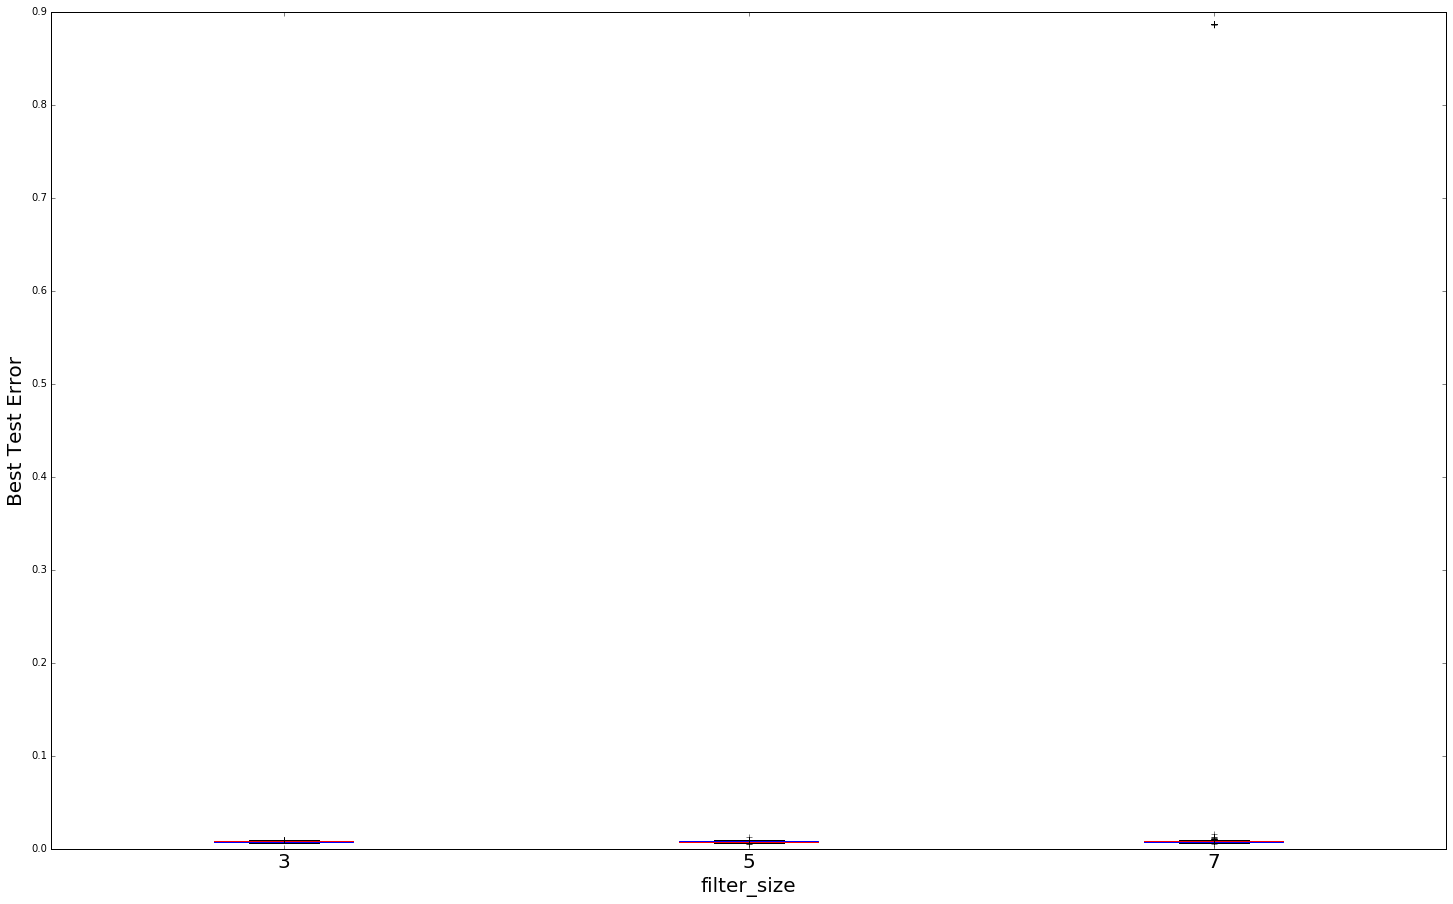

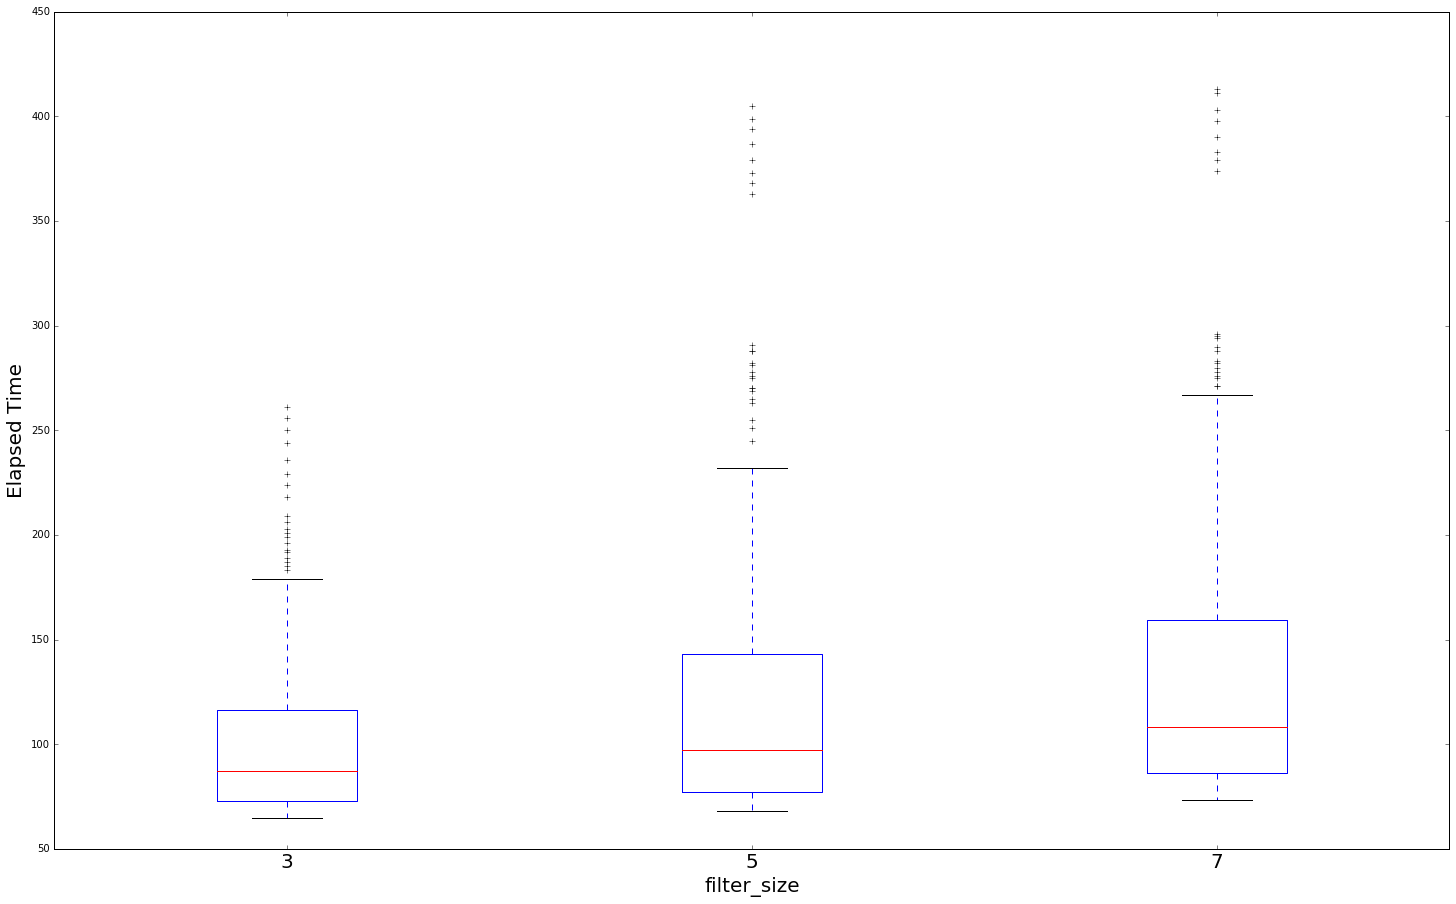

In [12]:
selected_dim = "filter_size"
draw_box_plots(best_only_table, selected_dim, "Best Test Error")
draw_box_plots(best_only_table, selected_dim, "Elapsed Time")

In [13]:
import matplotlib
# set global font size
font = {'size'   : 20}
matplotlib.rc('font', **font)

def draw_summary_plot(table, selected_dim, title, output = "Best Test Error"):
    
    fig = plt.figure(num=None, figsize=(25, 25), dpi=150, facecolor='w', edgecolor='k')
    fig.suptitle(title, fontsize=40)
    
    x_values = sorted(set(table[selected_dim]))
    error_box_list = []
    best_error_list = [100]
    time_box_list = []
    selection = {}
    best_time_list = [0]
    for x_value in x_values:
        selection[selected_dim] = x_value
        #print selection
        x = select_case(table, selection)
        #print len(x[output])
        
        best_error_value = min(x[output])
        best_error_list.append(best_error_value)
        #print x[output]
        # find the appropriate elapsed time
        time_box_values = x["Elapsed Time"].values.tolist()
        time_box_list.append(time_box_values)

        best_time = x[x[output] == best_error_value]["Elapsed Time"]
        best_time = best_time.values[0]
        best_time_list.append(best_time)
        
        error_box_values = x[output].values.tolist()
        logscale_box = log_scale(error_box_values, 10)        
        error_box_list.append(logscale_box)
    
    #print(len(time_box_list))
    #print(len(box_list))
    subplot = fig.add_subplot(211)
    subplot.boxplot(error_box_list) # test error box plot

    subplot2 = subplot.twinx()
    subplot.set_ylim([log(0.005, 10), log(1, 10)]) # 0 - 1 scale
    subplot.set_yticklabels([])
    #print(x_values)
    #print(best_list)
    subplot2.semilogy(best_error_list, color="black", linestyle='--', marker='o', label="Best Test Error")
    subplot2.grid(True)
    subplot2.set_ylim([0.005, 1]) # 0 - 1 scale
    subplot.set_xticklabels(x_values)
    subplot.set_xlim([0, len(x_values) + 1])
    plt.ylabel(output)
    
    plt.legend(loc="best")
    
    subplot3 = fig.add_subplot(212)
    subplot3.plot(best_time_list, color="black", linestyle='--', marker='o', label="Training Time of Best Test Error")
    
    #subplot4 = subplot3.twinx()
    subplot3.boxplot(time_box_list)
    subplot3.set_xlim([0, len(x_values) + 1])
    
    subplot3.set_xticklabels([])
    
    #print(x_values)
    
    subplot.xaxis.grid()
    #subplot.yaxis.grid()
    subplot3.xaxis.grid()
    subplot3.yaxis.grid()
    
    plt.ylabel("Elapsed Time")
    plt.xlabel(selected_dim)
    plt.legend(loc="best")    
    file_name = title + ".png"
    file_name = file_name.replace(" ", "_")
    fig.savefig("revision_test/" + file_name, format='png', dpi=200, show=False)
    plt.show()

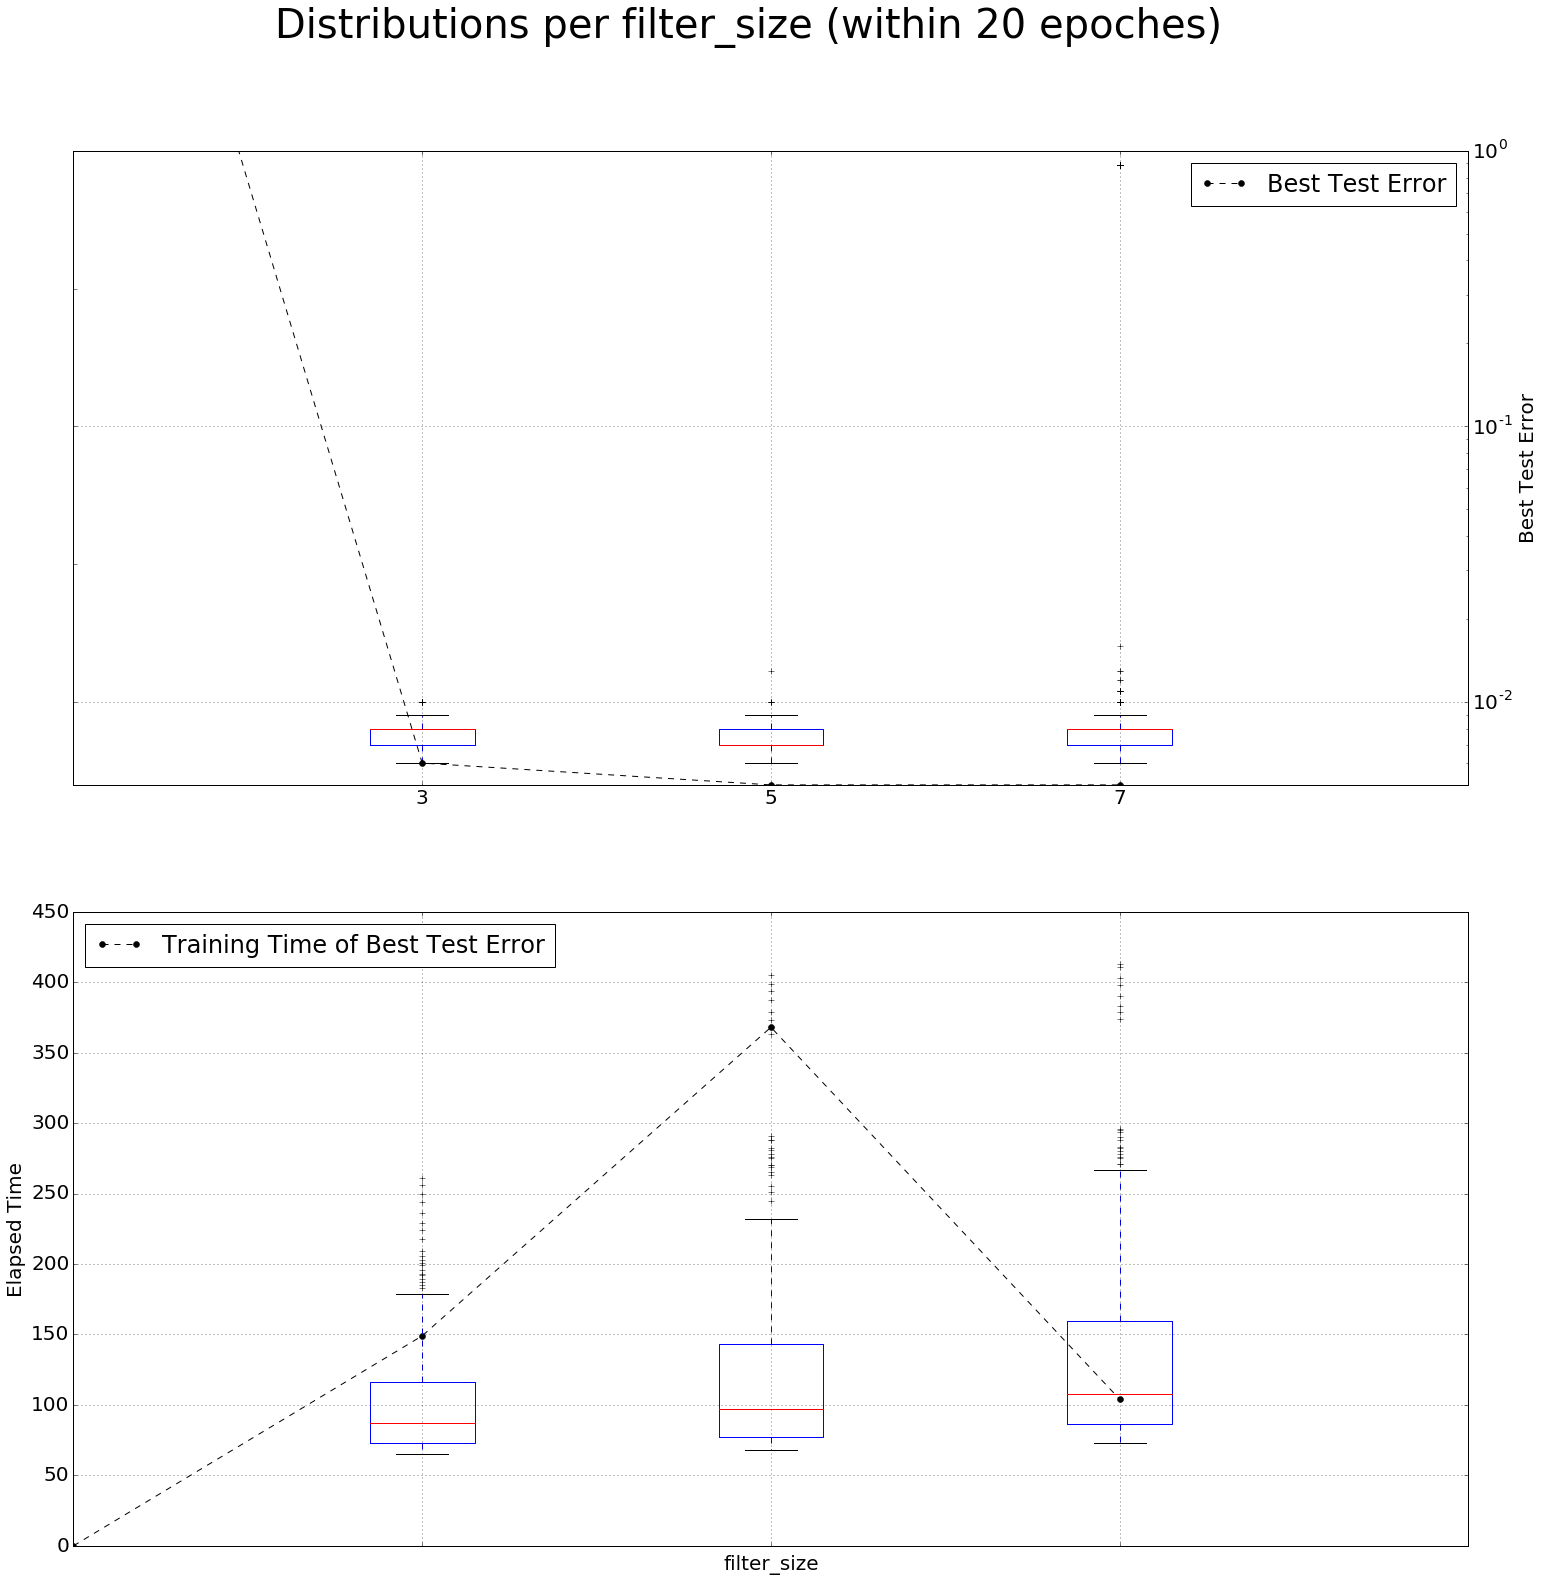

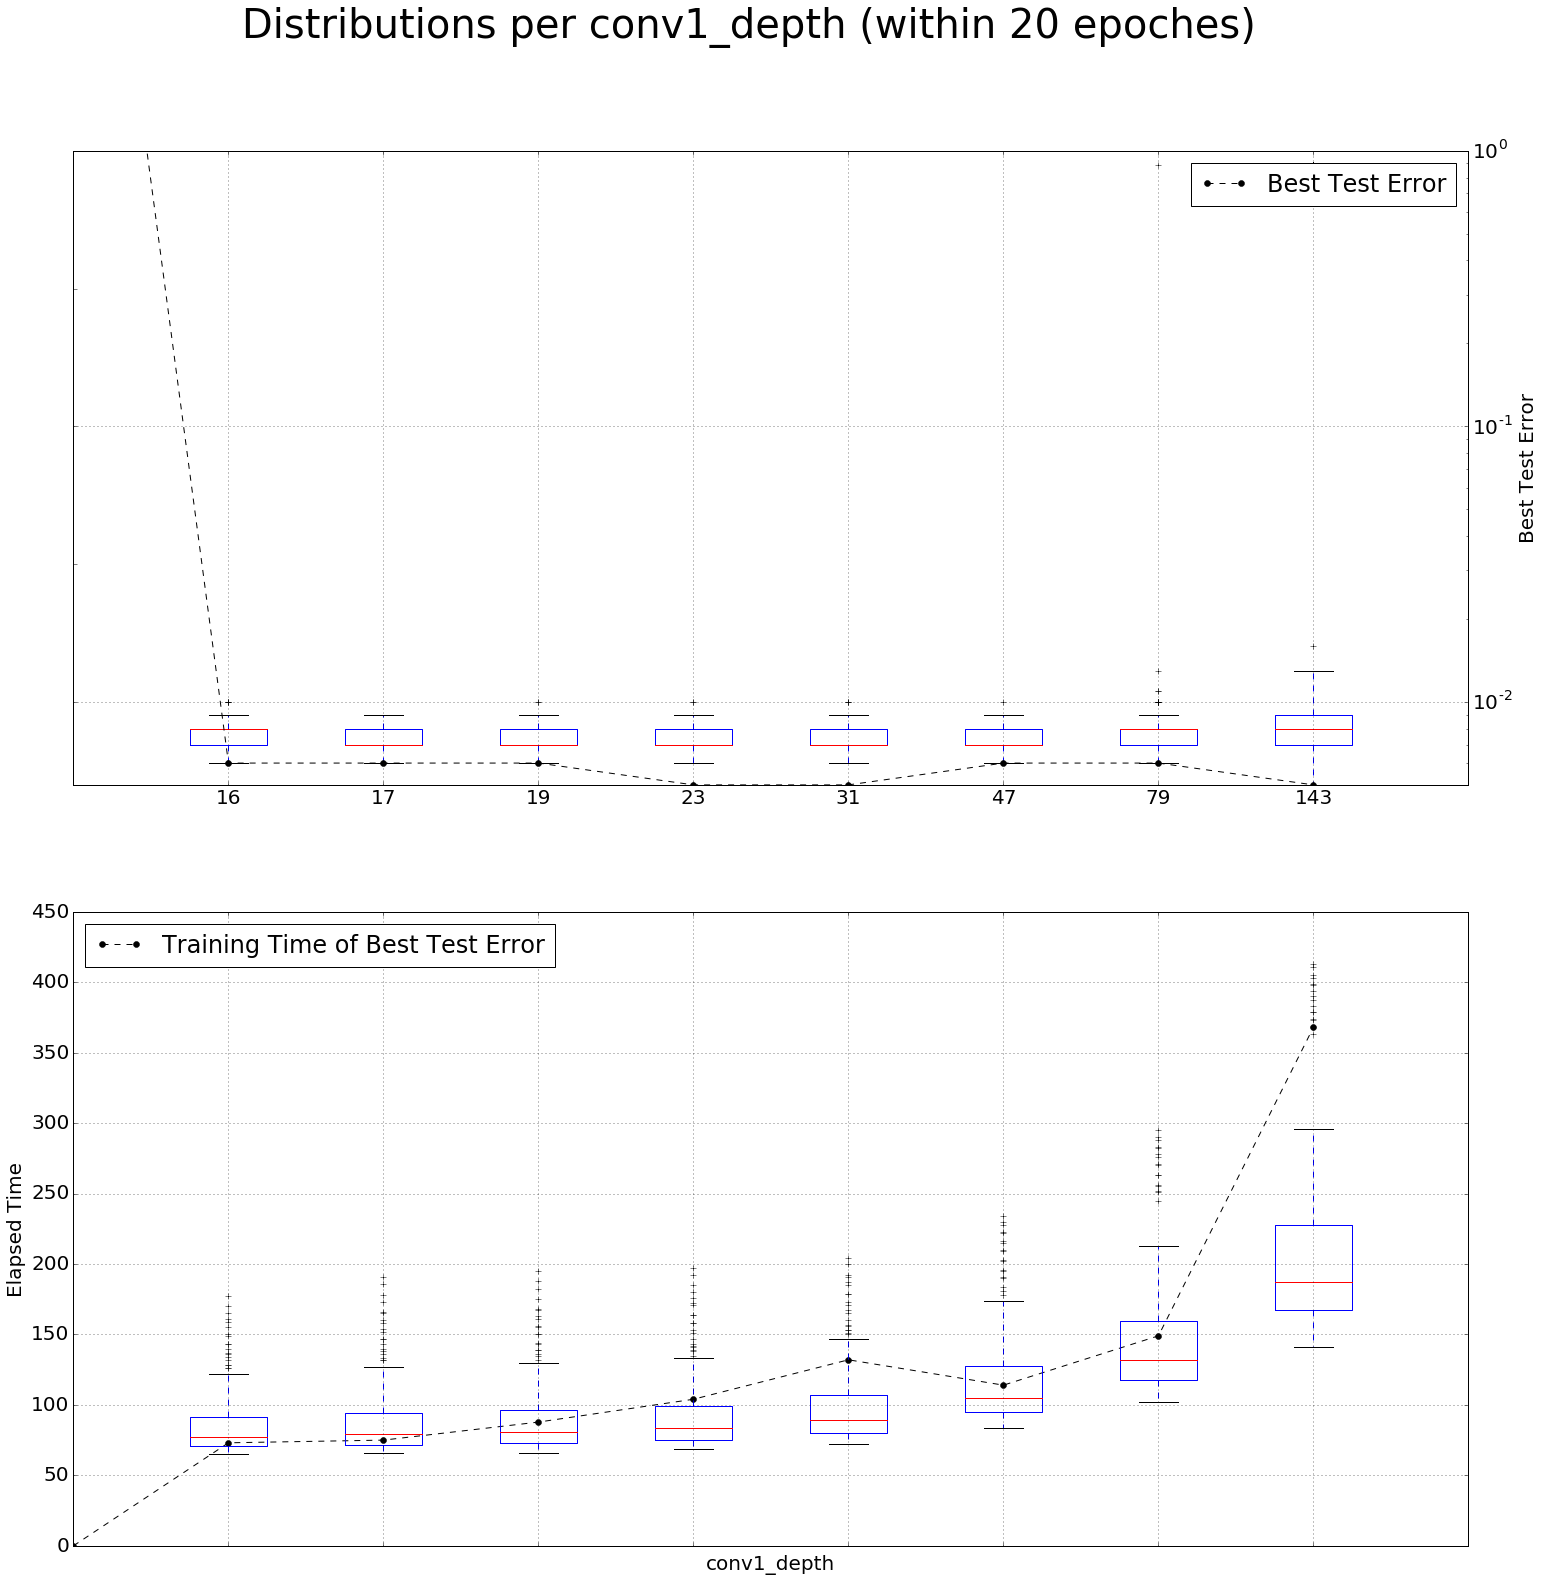

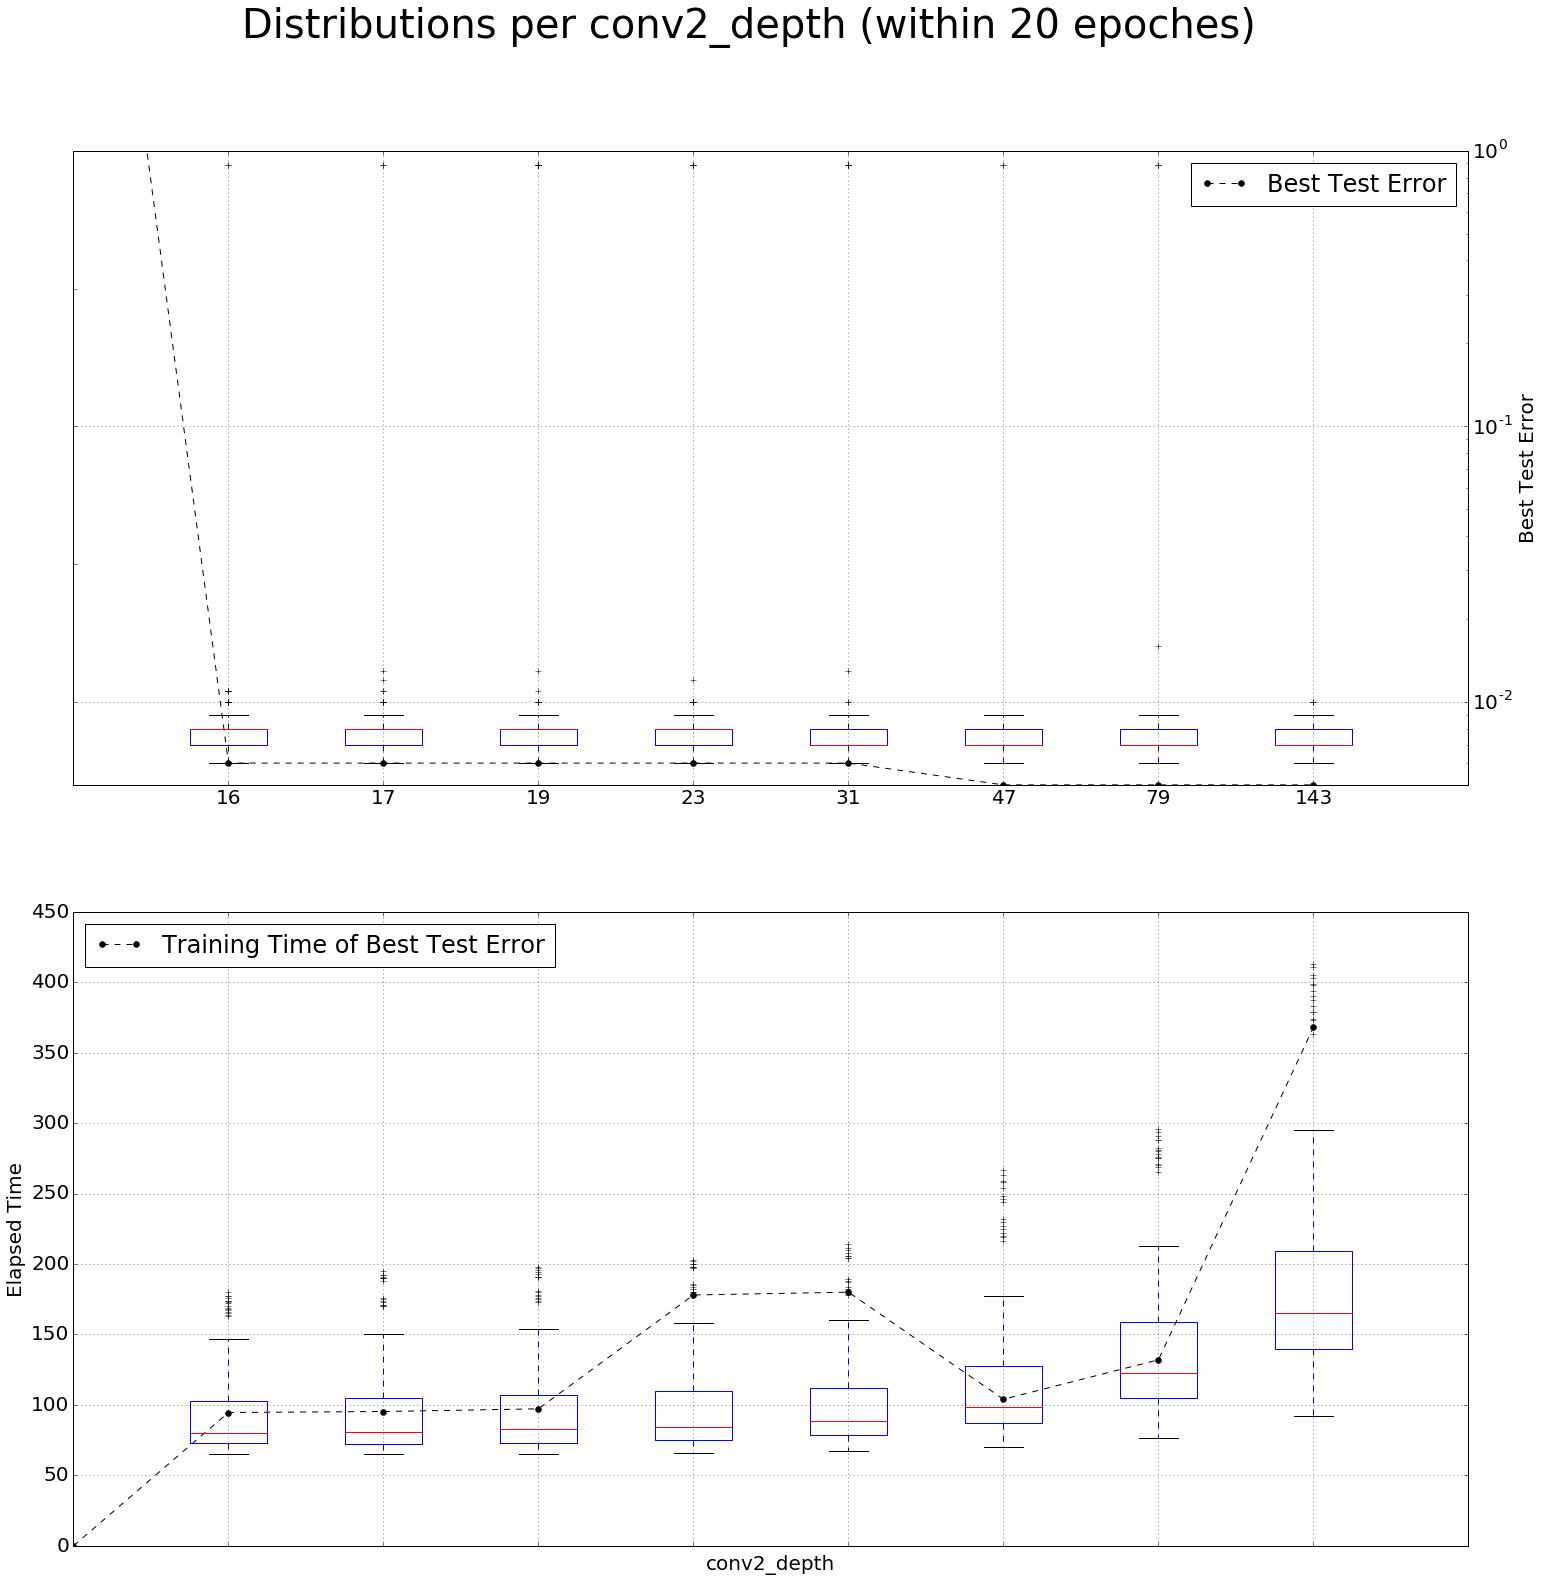

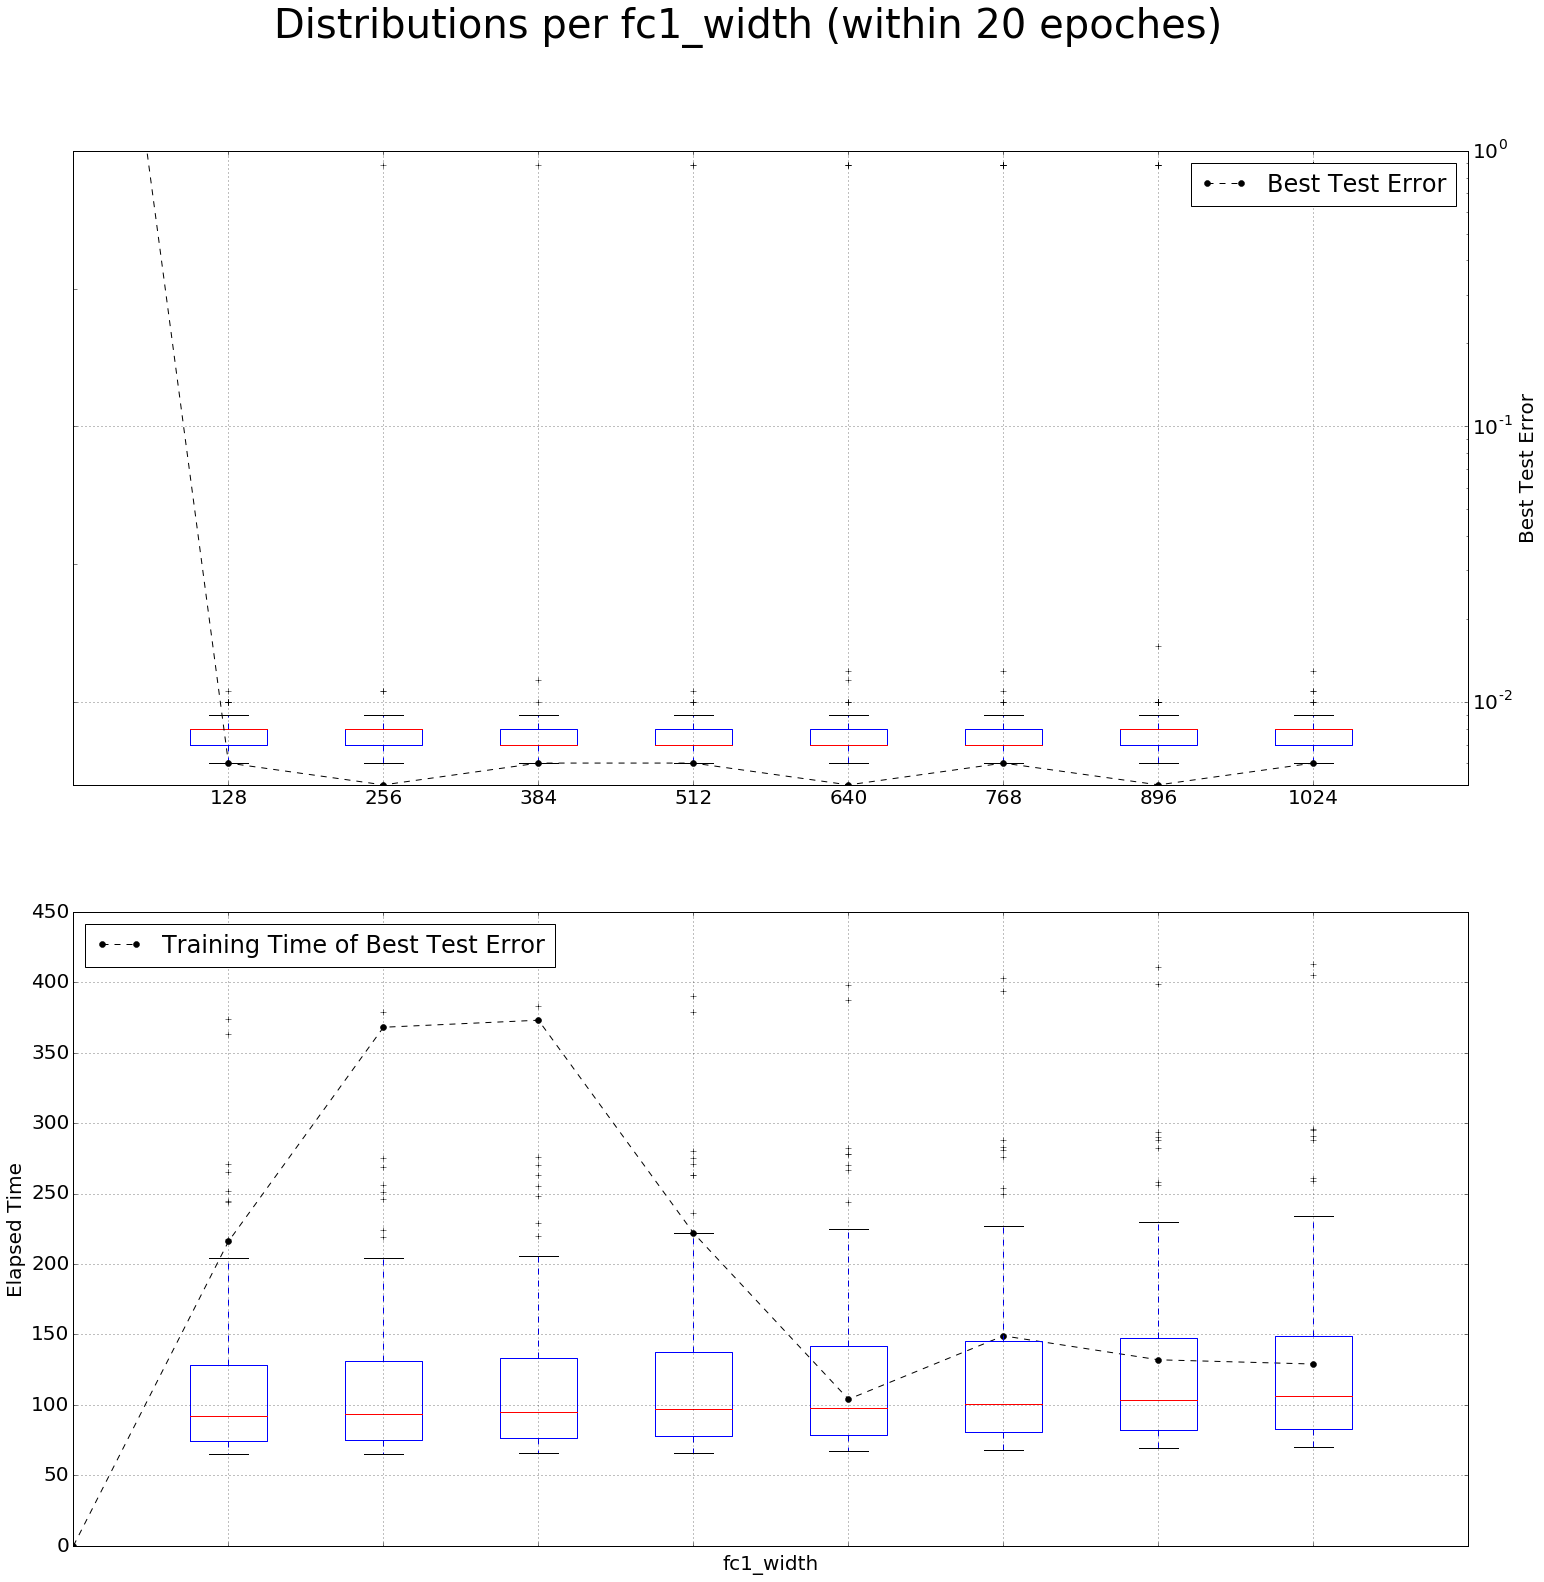

In [14]:
selected_dims = ["filter_size", "conv1_depth", "conv2_depth", "fc1_width"]
for selected_dim in selected_dims:
    draw_summary_plot(best_only_table, selected_dim, "Distributions per " + selected_dim + " (within 20 epoches)")

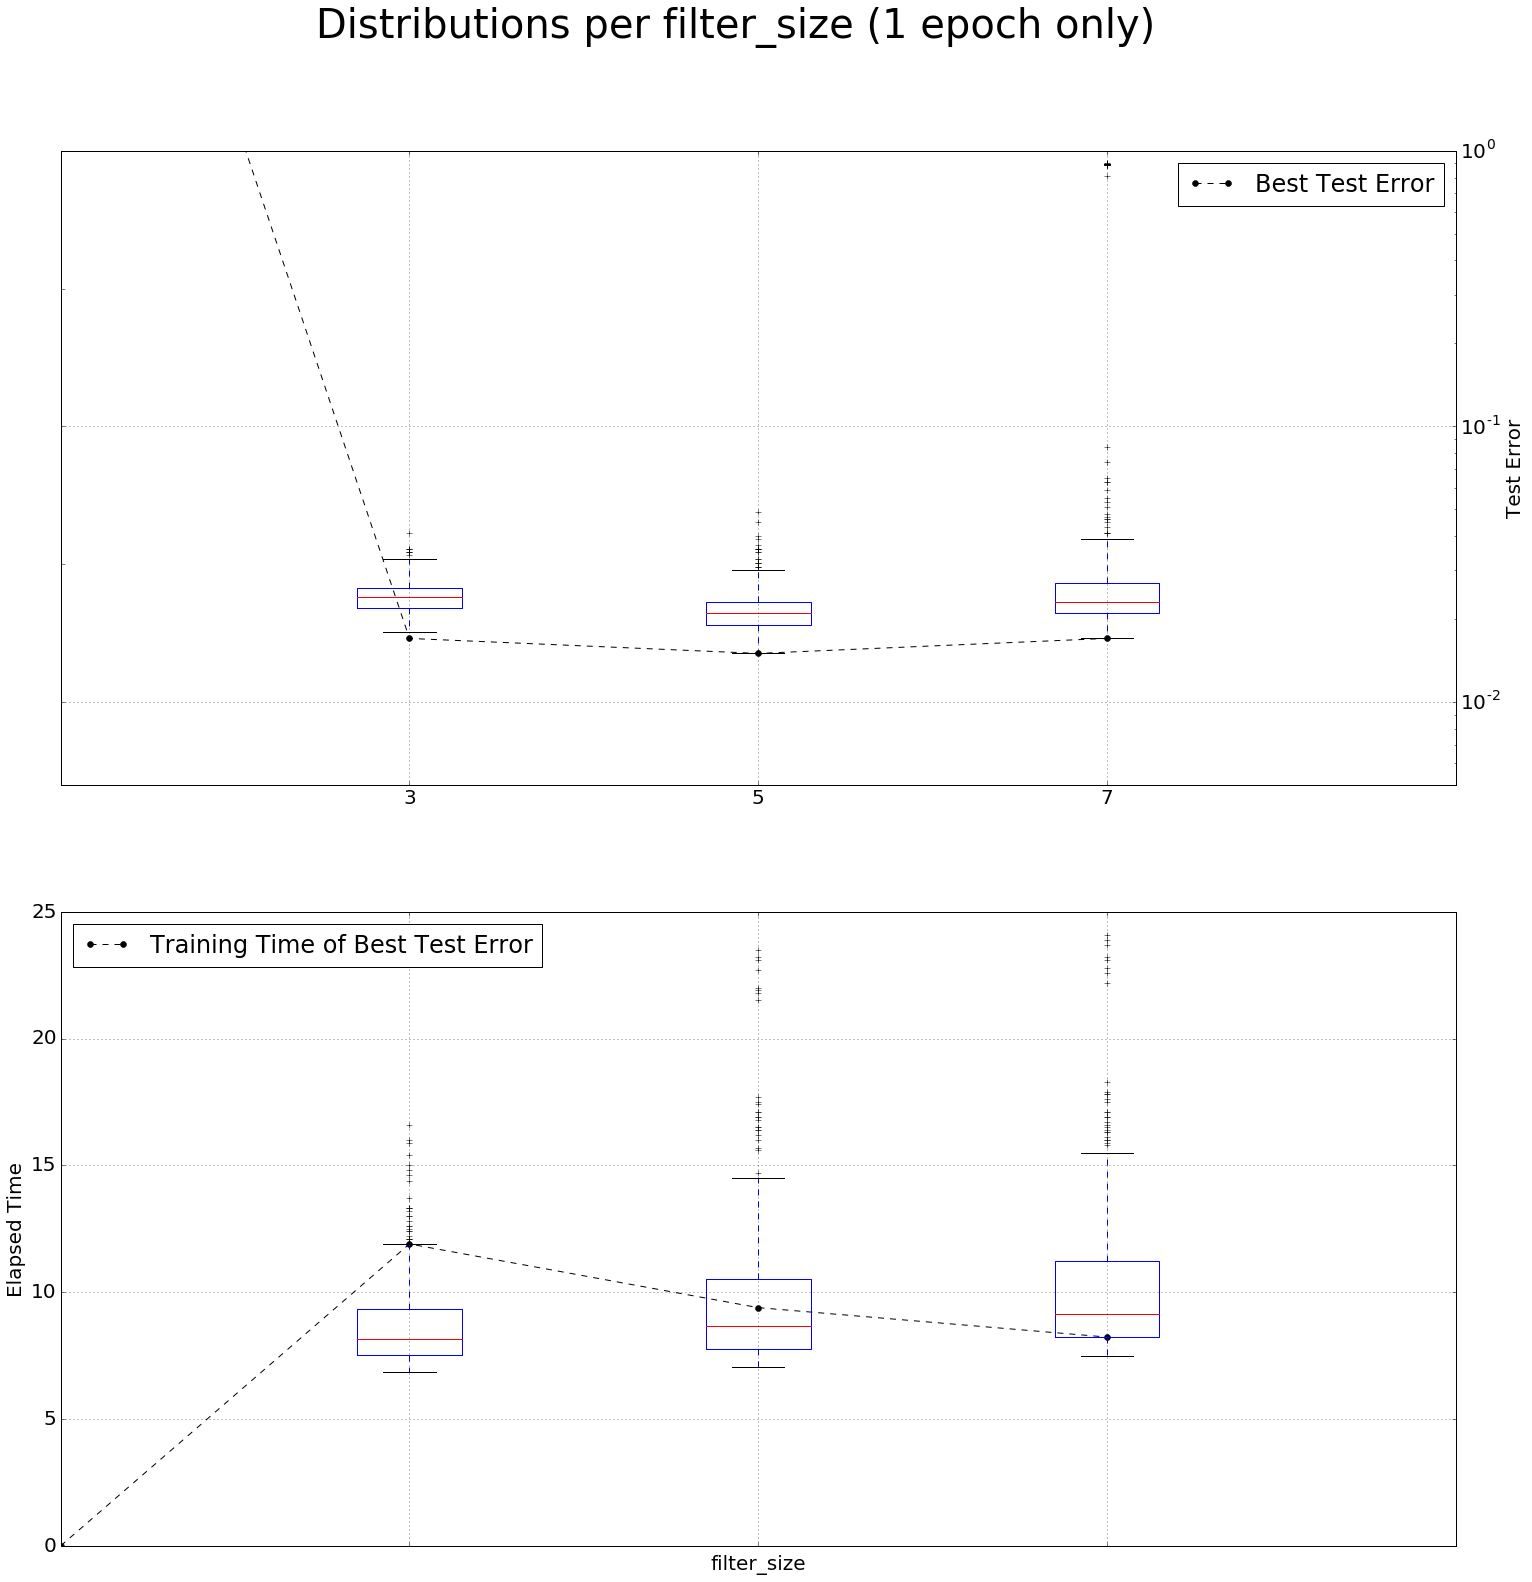

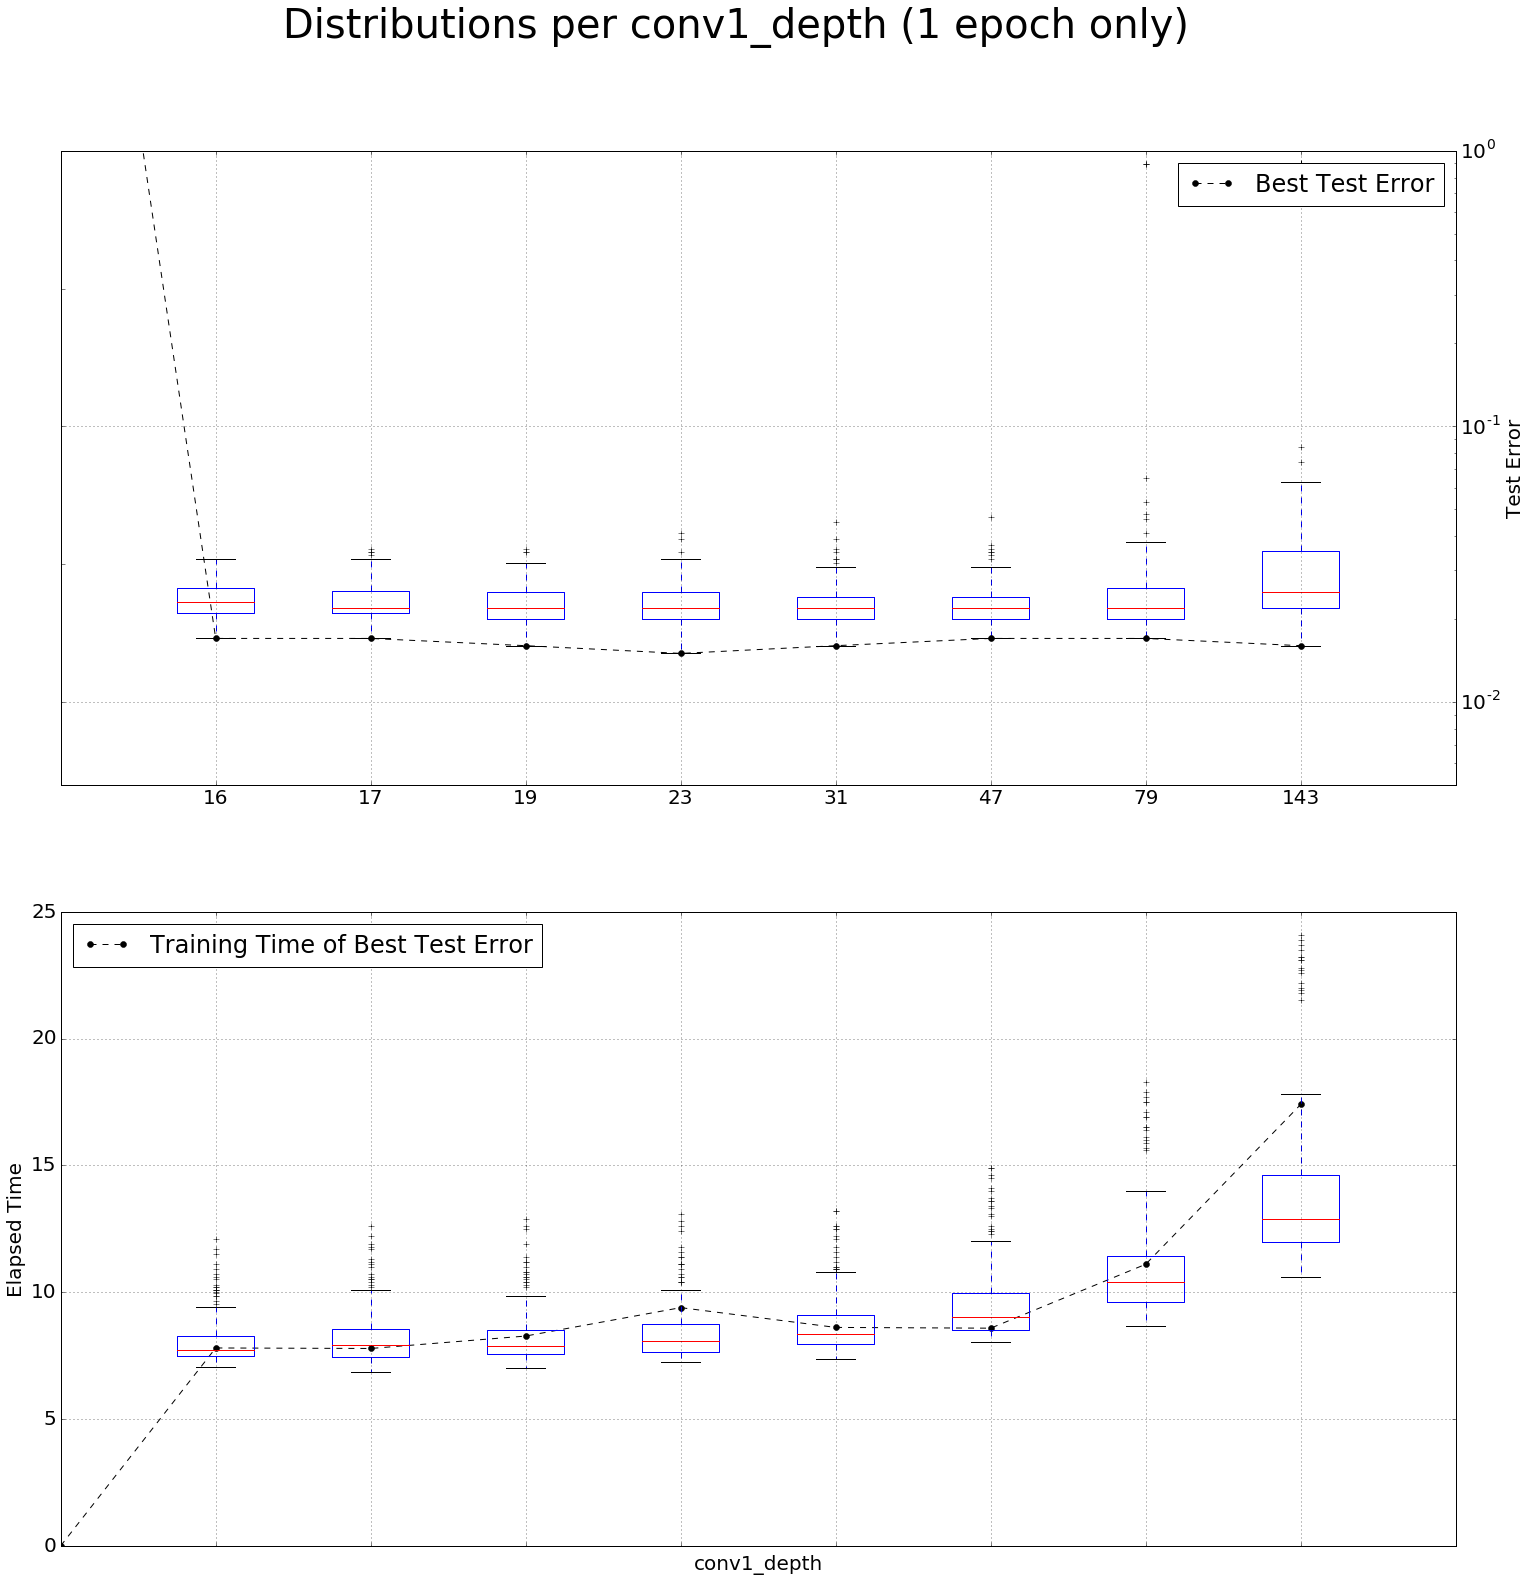

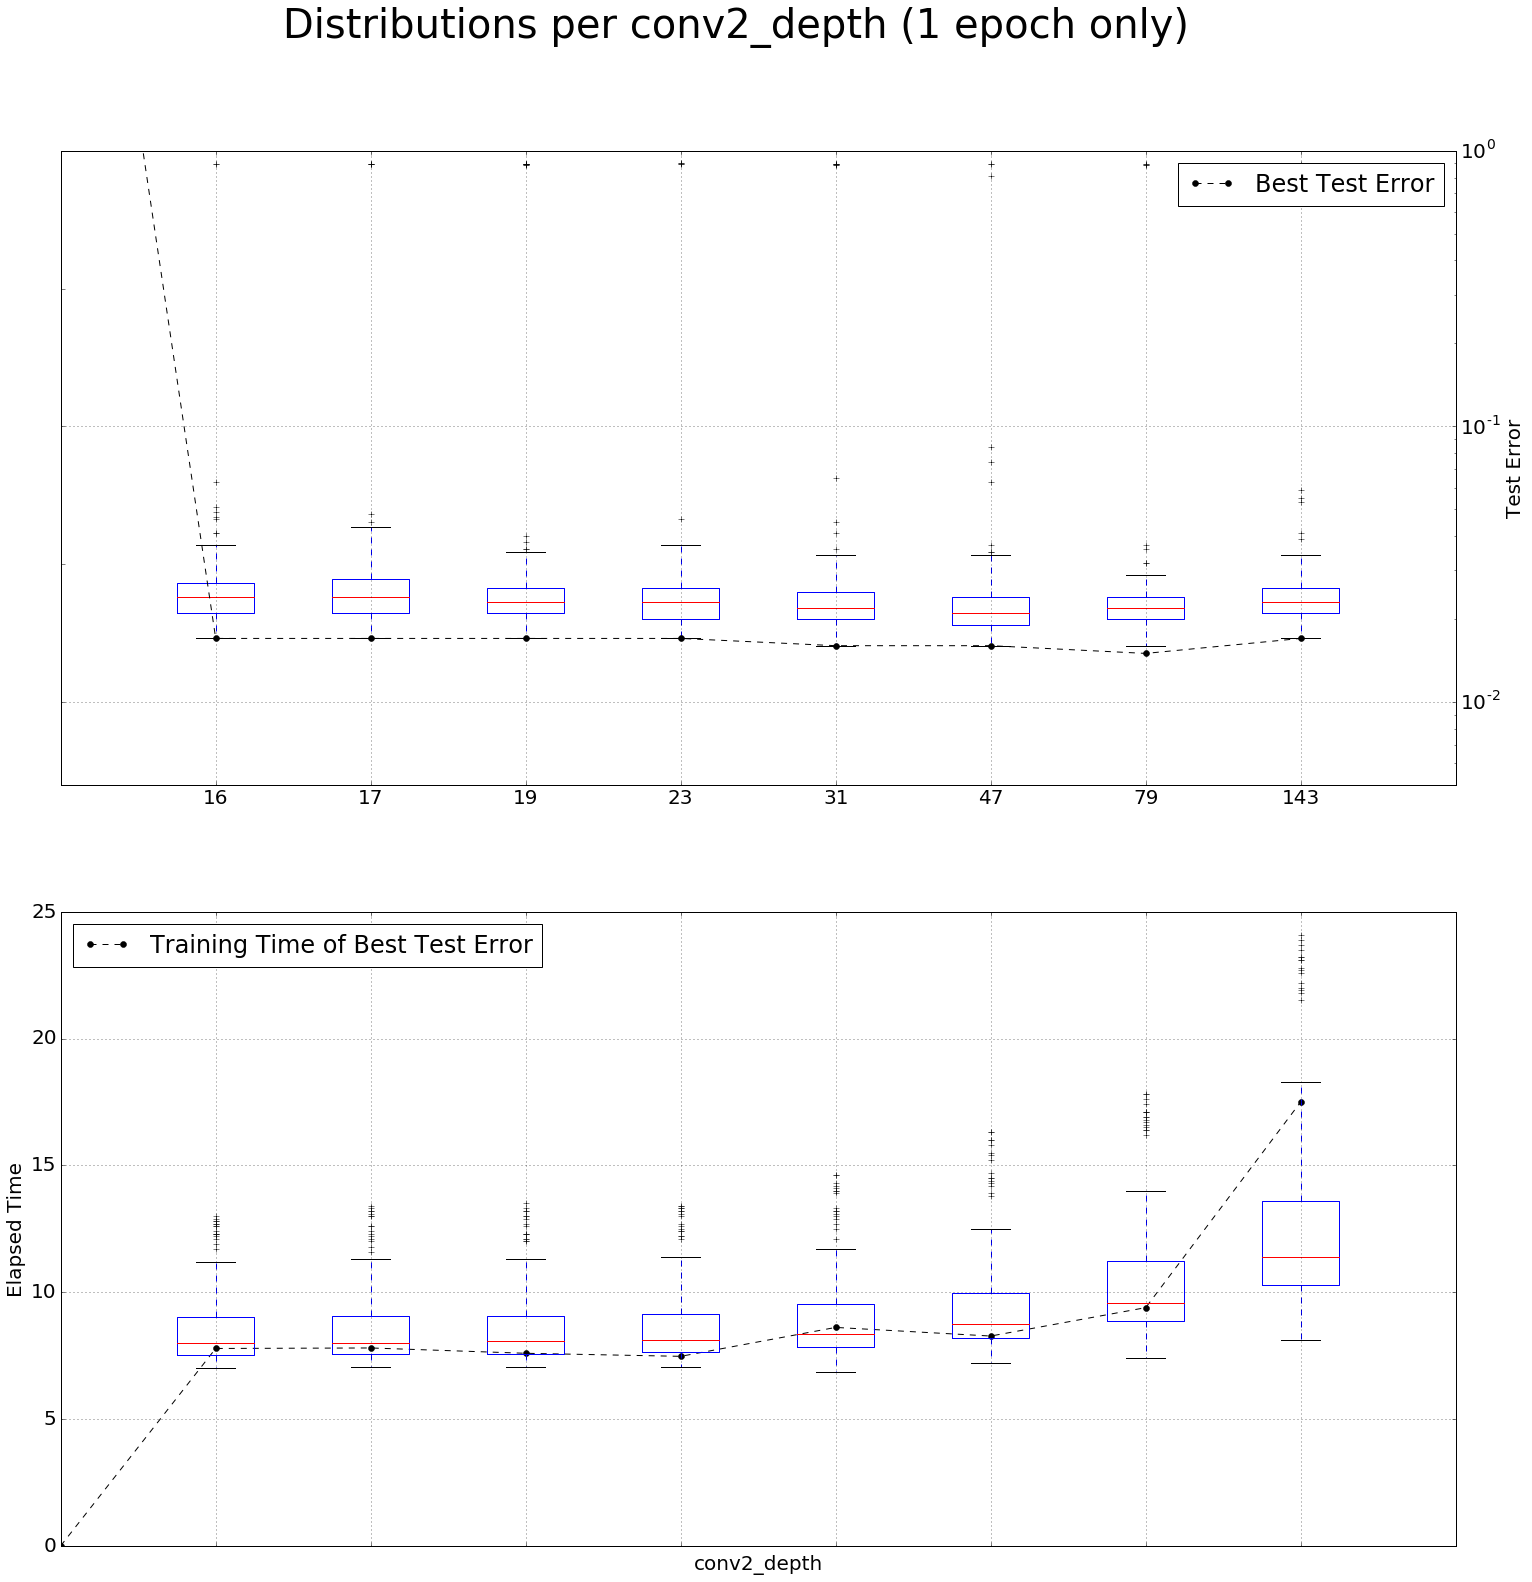

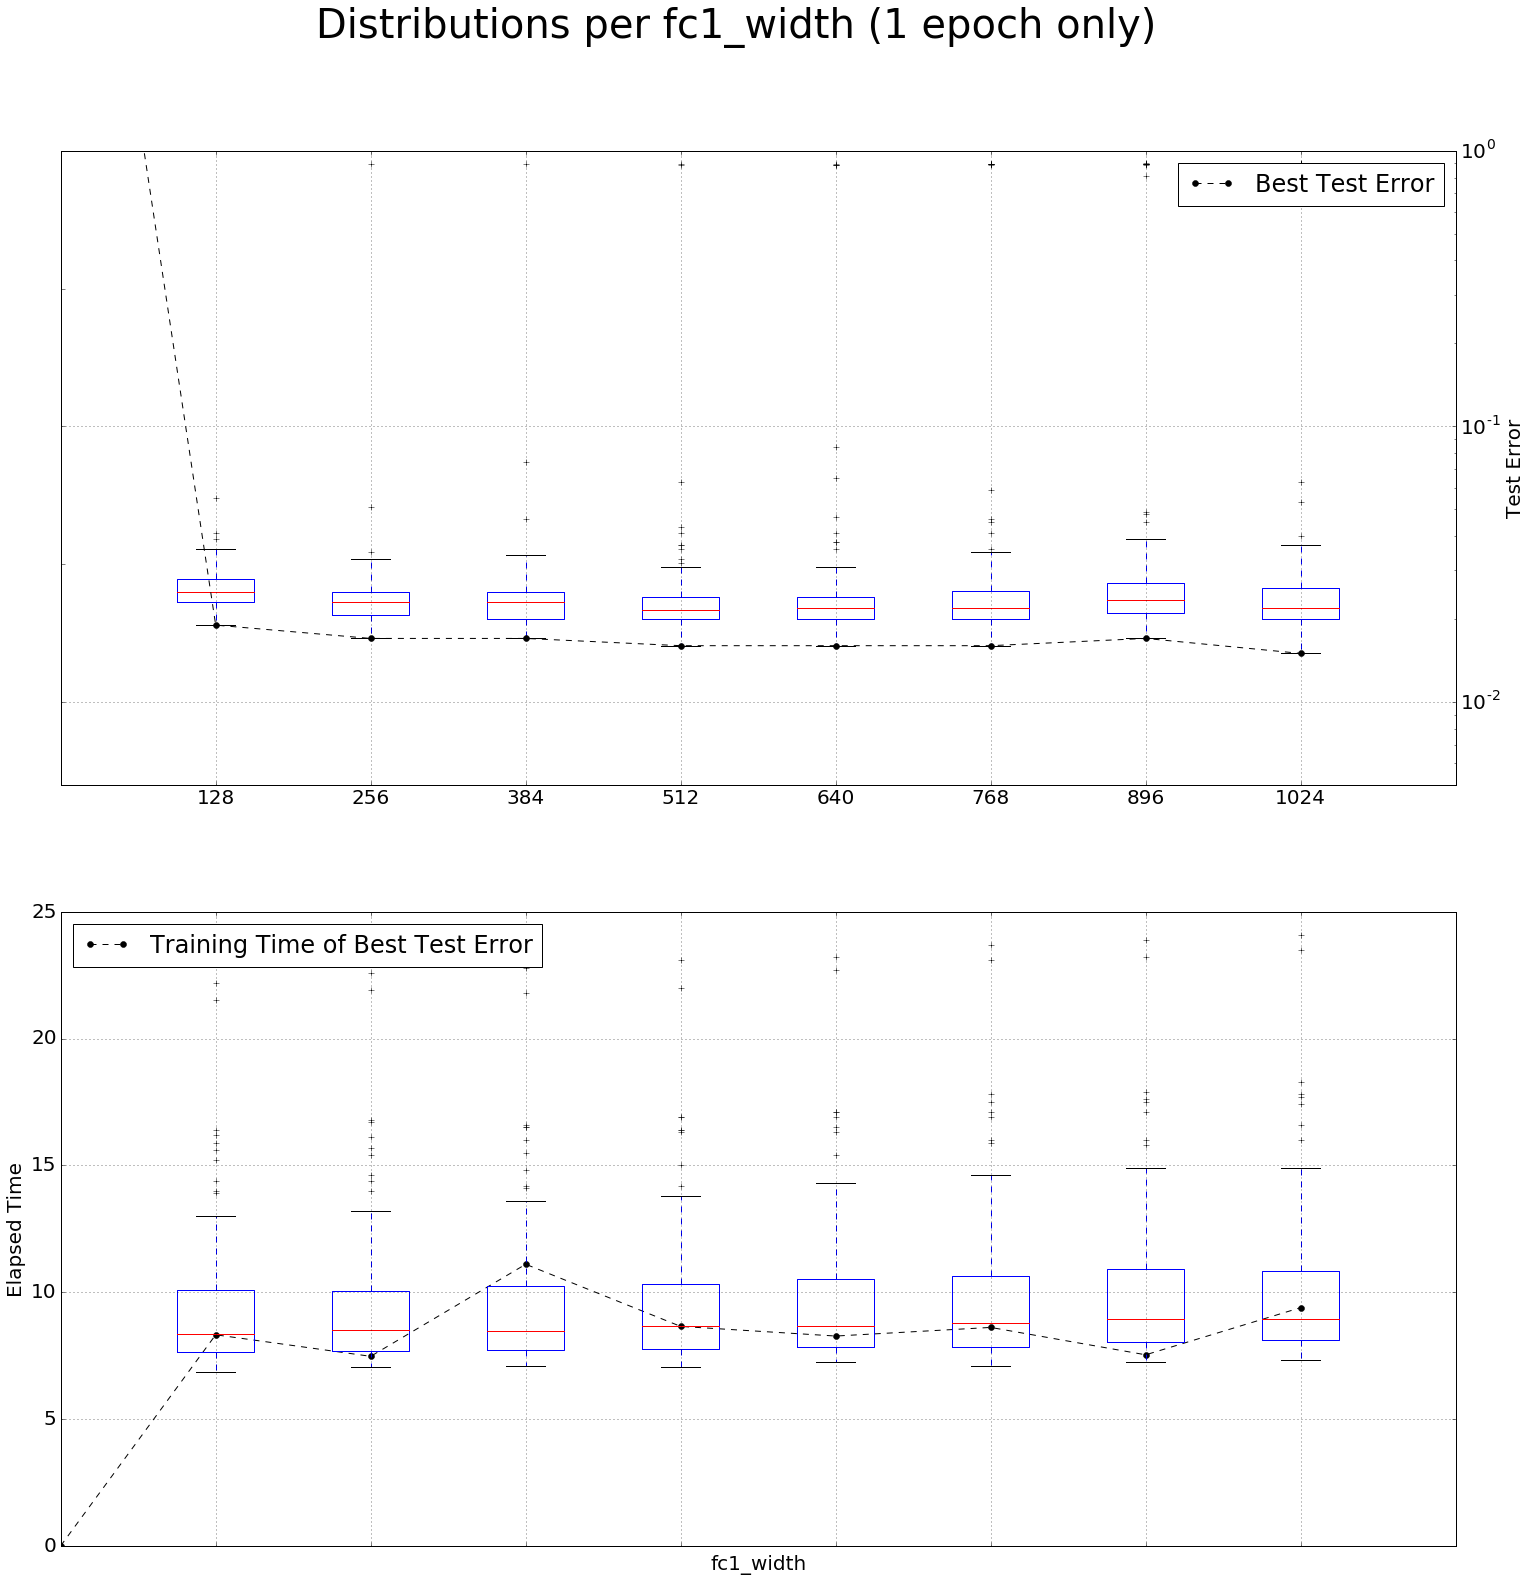

In [15]:

epoch_table = create_subset_table(grid_table, "epoch")
epoch_1_table = epoch_table[epoch_table["Epoch"] == 1.00]

for selected_dim in selected_dims:
    draw_summary_plot(epoch_1_table, selected_dim, "Distributions per " + selected_dim + " (1 epoch only)", output = "Test Error")

In [19]:
# find the distribution of best test error in each epochs
best_error_list = []

filter_sizes = set(grid_table["filter_size"].values.tolist()) 
conv1_depths = set(grid_table["conv1_depth"].values.tolist()) 
conv2_depths = set(grid_table["conv2_depth"].values.tolist()) 
fc_depths = set(grid_table["fc1_width"].values.tolist()) 

for filter_size in filter_sizes:
    for conv1_depth in conv1_depths:
        for conv2_depth in conv2_depths:
            for fc_depth in fc_depths:
                selection = {"filter_size": filter_size, "conv1_depth" : conv1_depth, "conv2_depth" : conv2_depth, "fc1_width" : fc_depth}
                case = select_case(epoch_table, selection)
                if len(case["Test Error"]) > 0:
                    epoch_best = case[case["Test Error"] == min(case["Test Error"])]["Epoch"]
                    epoch_best = epoch_best.values.tolist()[0]
                    epoch_num = int(epoch_best)
                    best_error_list.append(epoch_num)

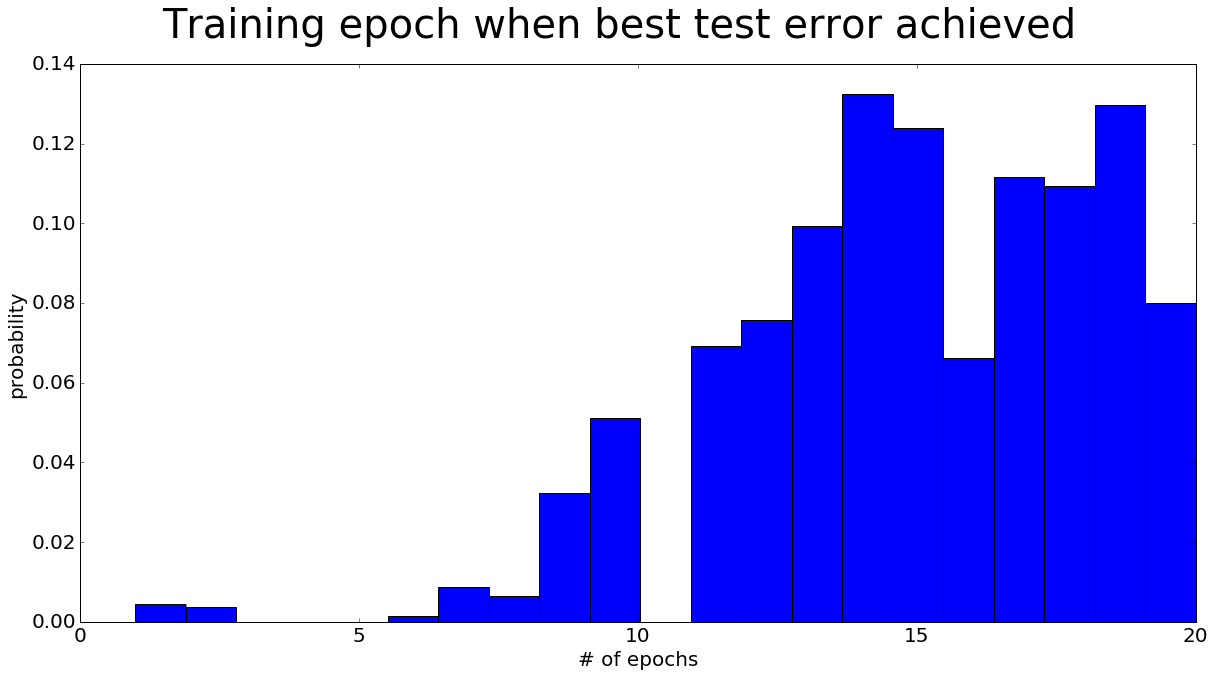

In [21]:
fig = plt.figure(num=None, figsize=(20, 10), dpi=100, facecolor='w', edgecolor='k')
fig.suptitle("Training epoch when best test error achieved", fontsize=40)
subplot = fig.add_subplot(1, 1, 1)

subplot.hist(best_error_list, 21, normed=True)
plt.xlabel("# of epochs")
plt.ylabel("probability")
fig.savefig("revision_test/20epochs_for_best.png", format='png', dpi=200, show=False)
plt.show()

In [22]:
# modified version (Test Error is transformated by log 10 scale)
def draw_n_by_n_plots(table, fixed, x_axis, y_axis, selected_dim, output, show_fig=False, save_fig=True, to_log_scale=True):
    condition = {}
    condition[fixed["name"]] = fixed["value"]

    fig = plt.figure(num=None, figsize=(50, 50), dpi=200, facecolor='w', edgecolor='k')
    fig.suptitle("Fixed hyperparameter - " + fixed["name"] + ": " + str(fixed["value"]), fontsize=50)
    fig_index = 1
    
    if output == "Elapsed Time":
        # for fixed output range setting
        condition[x_axis["name"]] = max(x_axis["values"])
        condition[y_axis["name"]] = max(y_axis["values"])
        one_dim_table = get_one_dim(table, condition, selected_dim, output)
        y_range = [0, max(one_dim_table[output])]      
    elif output == "Test Error":
        y_range = [log(0.001, 10), log(1, 10)] # 0 - 1 scale
    else:
        print("unsupported output type")
    
    x_axis_length = len(x_axis["values"])
    y_axis_length = len(y_axis["values"])
    for i in range(x_axis_length):
        condition[x_axis["name"]] = x_axis["values"][i]
        for j in range(y_axis_length):
            subplot = fig.add_subplot(x_axis_length, y_axis_length, fig_index)
            fig_index += 1
            condition[y_axis["name"]] = y_axis["values"][j]
            
            one_dim_table = get_one_dim(table, condition, selected_dim, output)
            # print(one_dim_table.head(10)) # for debugging 
            x_col_name = selected_dim
            # To show log scale
            if to_log_scale:
                logscale_col = "log2(" + selected_dim + ")"
                x_col_name = logscale_col
                
            subplot.plot(one_dim_table[x_col_name], one_dim_table["log10(" + output + ")"])
            title = x_axis["name"] + ":" + str(condition[x_axis["name"]]) + ", " + \
                y_axis["name"] + ":" + str(condition[y_axis["name"]])
            subplot.set_title(title)
            subplot.set_ylim(y_range)
            if j == 0:
                if output == "Elapsed Time":
                    y_label = output
                elif output == "Test Error":    
                    y_label = "log10(" + output + ")"
                plt.ylabel(y_label)

            if j == 0:
                plt.xlabel(x_col_name)

    if show_fig:
        plt.show()
    if save_fig:
        working_dir = os.getcwd()
        file_name = fixed["name"] + "_" + str(condition[fixed["name"]]) + '-' + output + '.png'
        file_name = file_name.replace(" ", "_")
        output_folder = output.replace(" ", "_")
        selected_dim_folder = selected_dim.replace(" ", "_")
        
        try:
            os.chdir("revision_test") # for testing only
            if not os.path.exists(output_folder):
                os.makedirs(output_folder)
                #print(output_folder + " is created")
                
            os.chdir(output_folder)

            if not os.path.exists(selected_dim_folder):
                os.makedirs(selected_dim_folder)
                
            os.chdir(selected_dim_folder)
        except OSError as exception:
            print("folder creation error: " + str(exception))
            os.chdir(working_dir)
            
        fig.savefig(file_name, format='png', dpi=200, show=False)
        os.chdir(working_dir)
        print(file_name + " is saved successfully.")
        
    return

In [28]:
def select_partial_item(full_list):
    result_list = []
    for i in range(len(full_list)):
        if i % 2 == 0:
            selected_item = full_list[i]
            result_list.append(selected_item)
    return result_list


In [29]:
filter_sizes = list(set(grid_table["filter_size"].values.tolist())) 
conv1_depths = select_partial_item(list(set(grid_table["conv1_depth"].values.tolist()))) 
conv2_depths = select_partial_item(list(set(grid_table["conv2_depth"].values.tolist()))) 
fc_depths = select_partial_item(list(set(grid_table["fc1_width"].values.tolist()))) 

filter_size_3-Elapsed_Time.png is saved successfully.
filter_size_3-Test_Error.png is saved successfully.
filter_size_5-Elapsed_Time.png is saved successfully.
filter_size_5-Test_Error.png is saved successfully.
filter_size_7-Elapsed_Time.png is saved successfully.
filter_size_7-Test_Error.png is saved successfully.


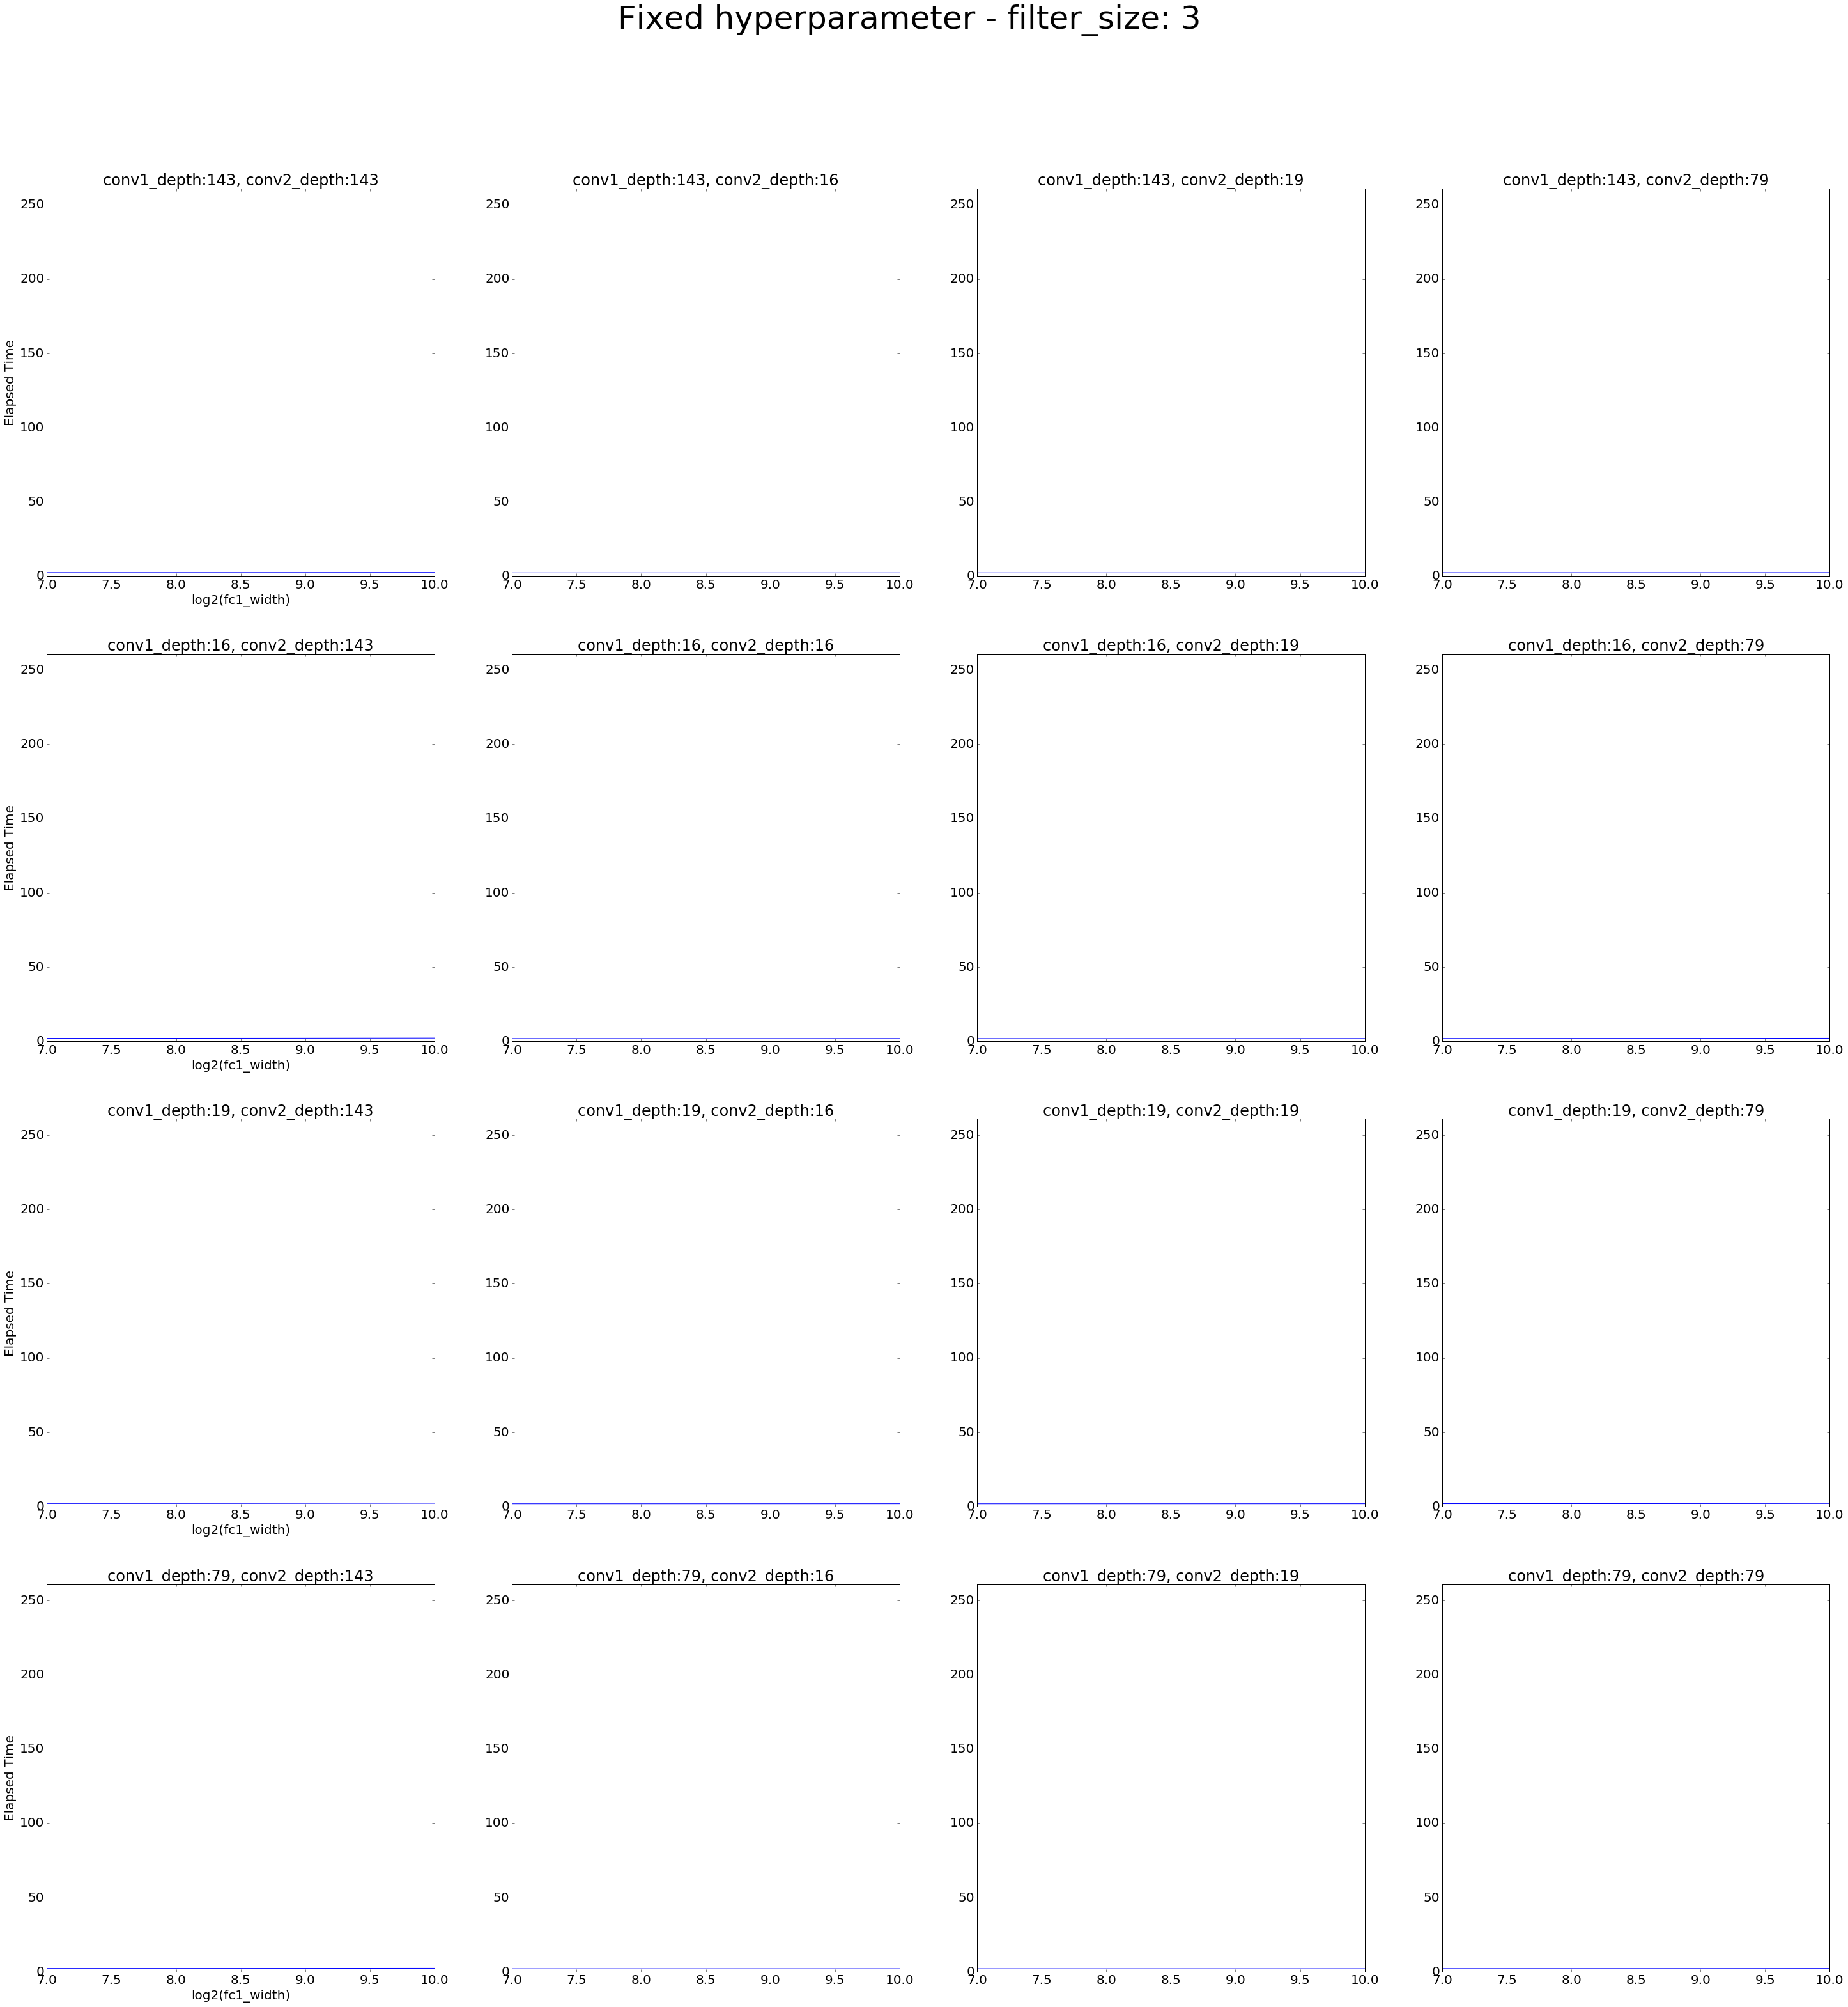

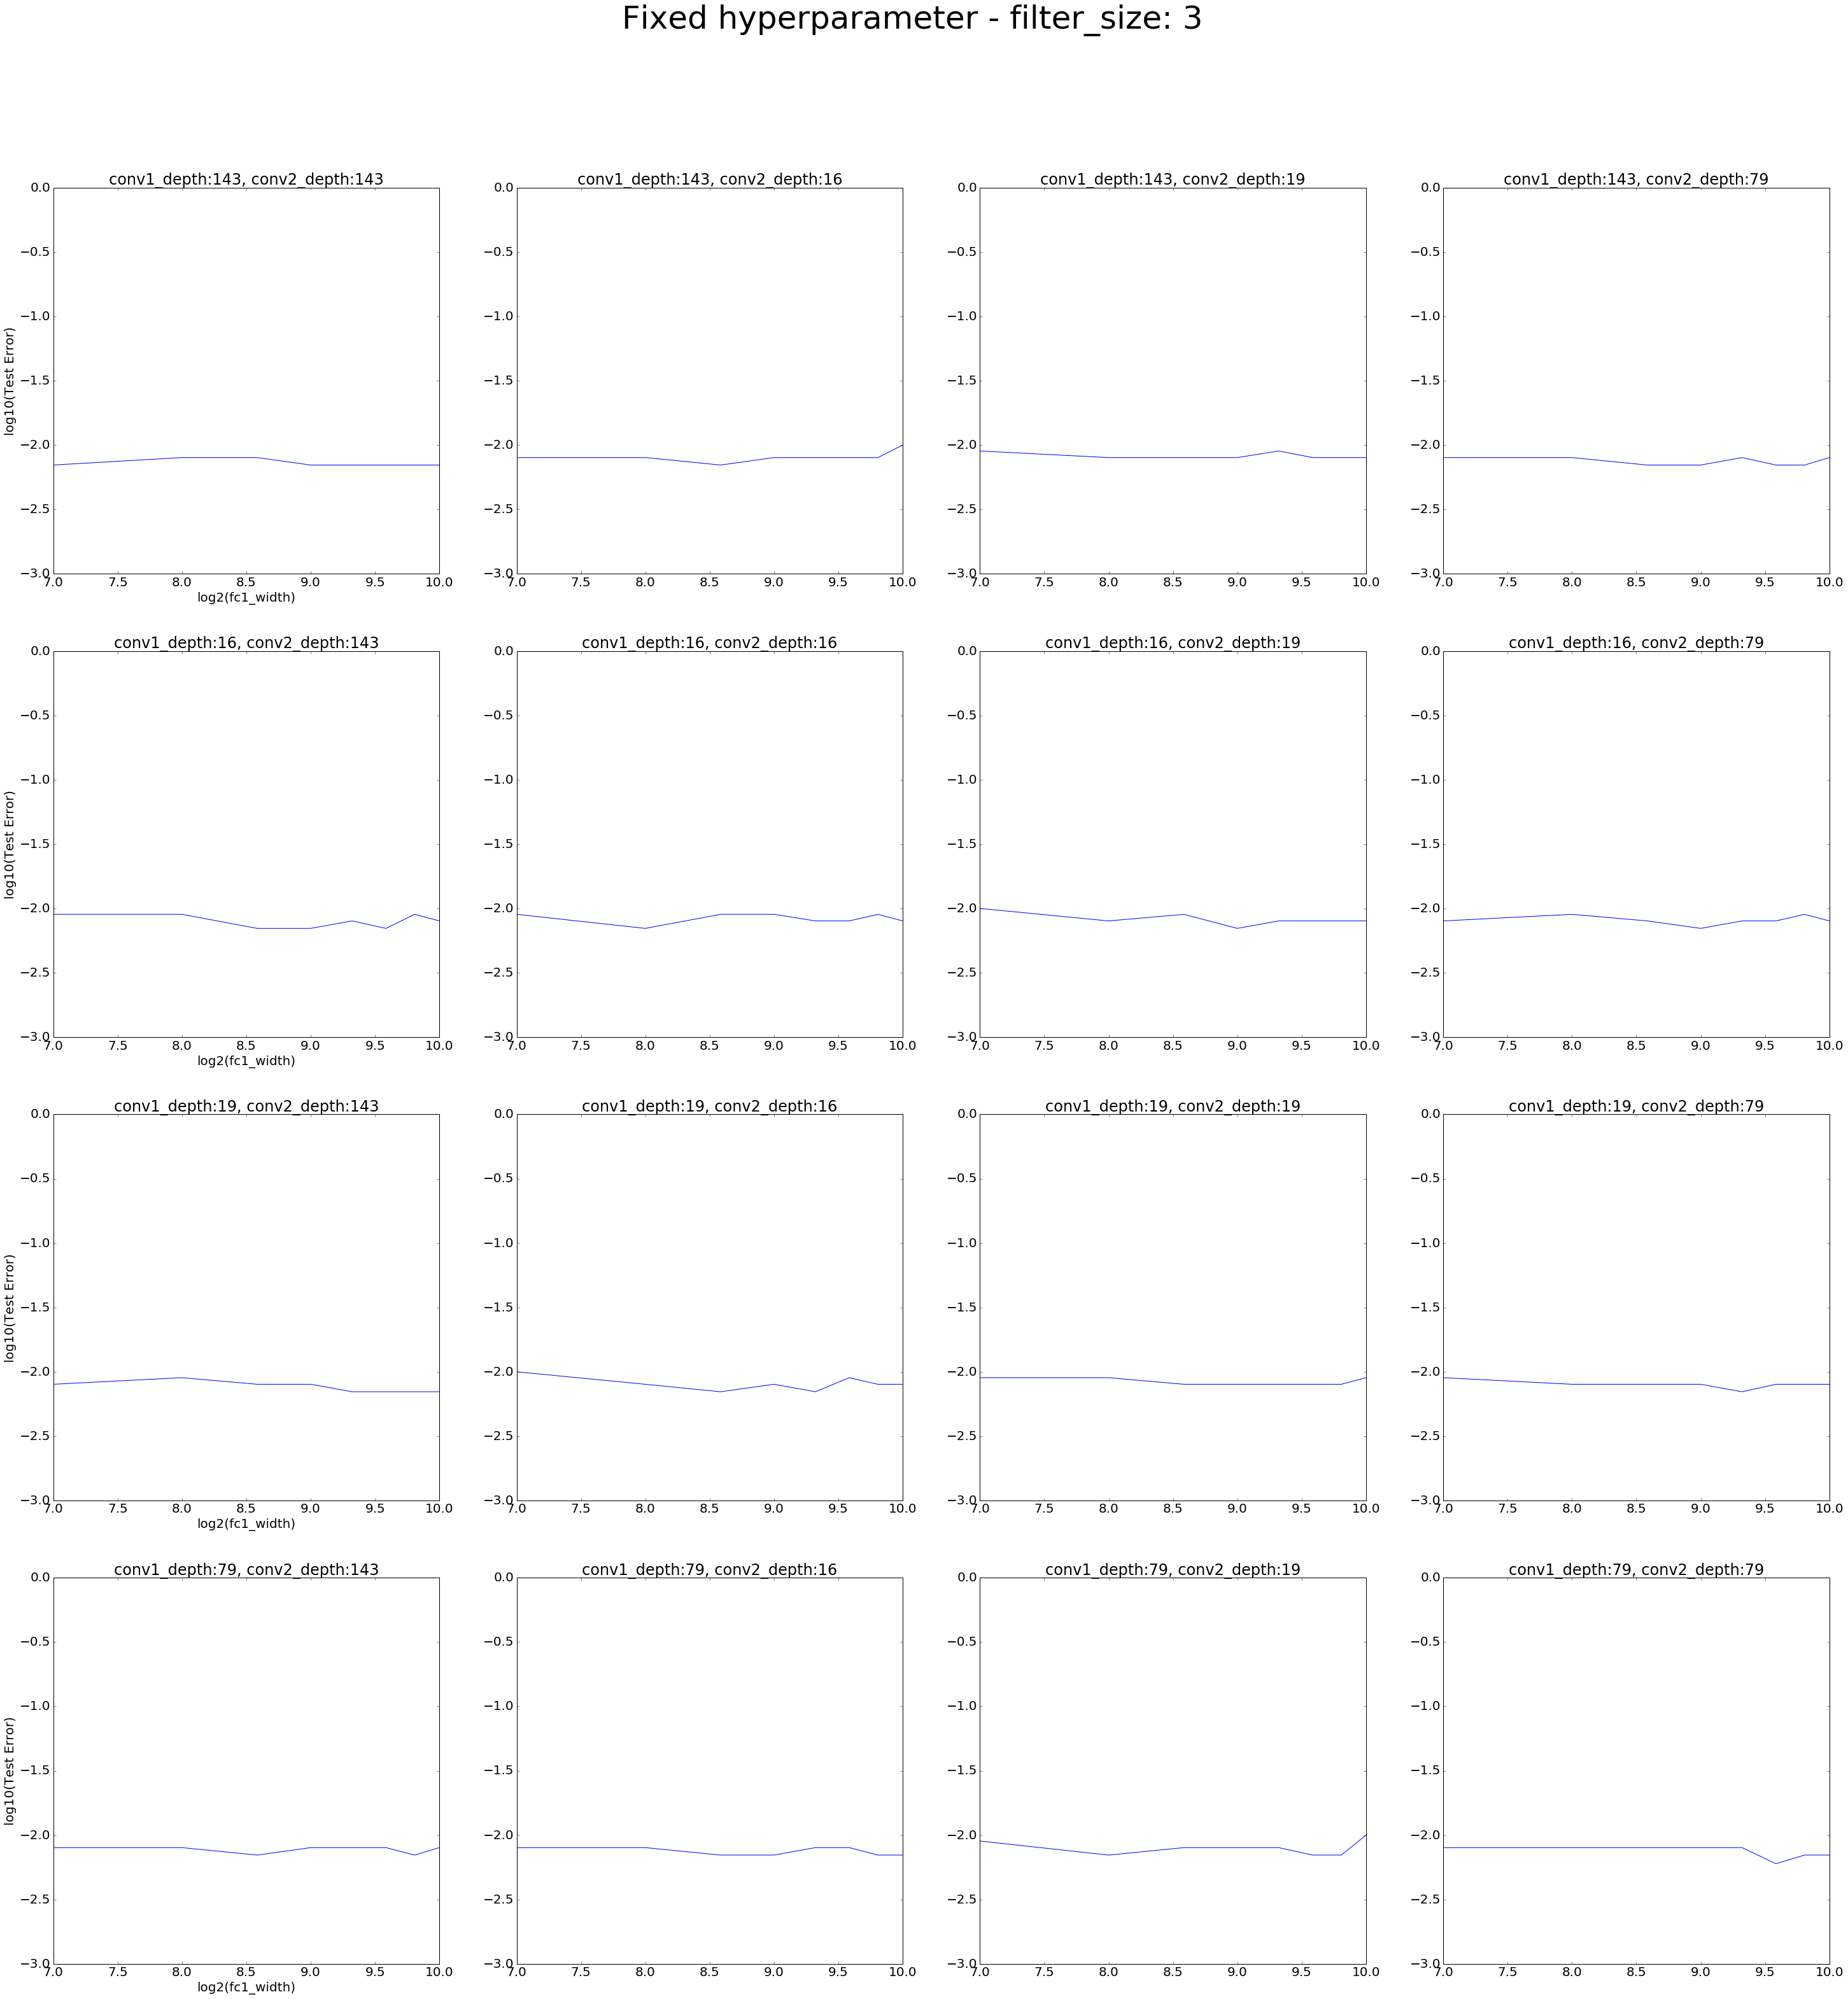

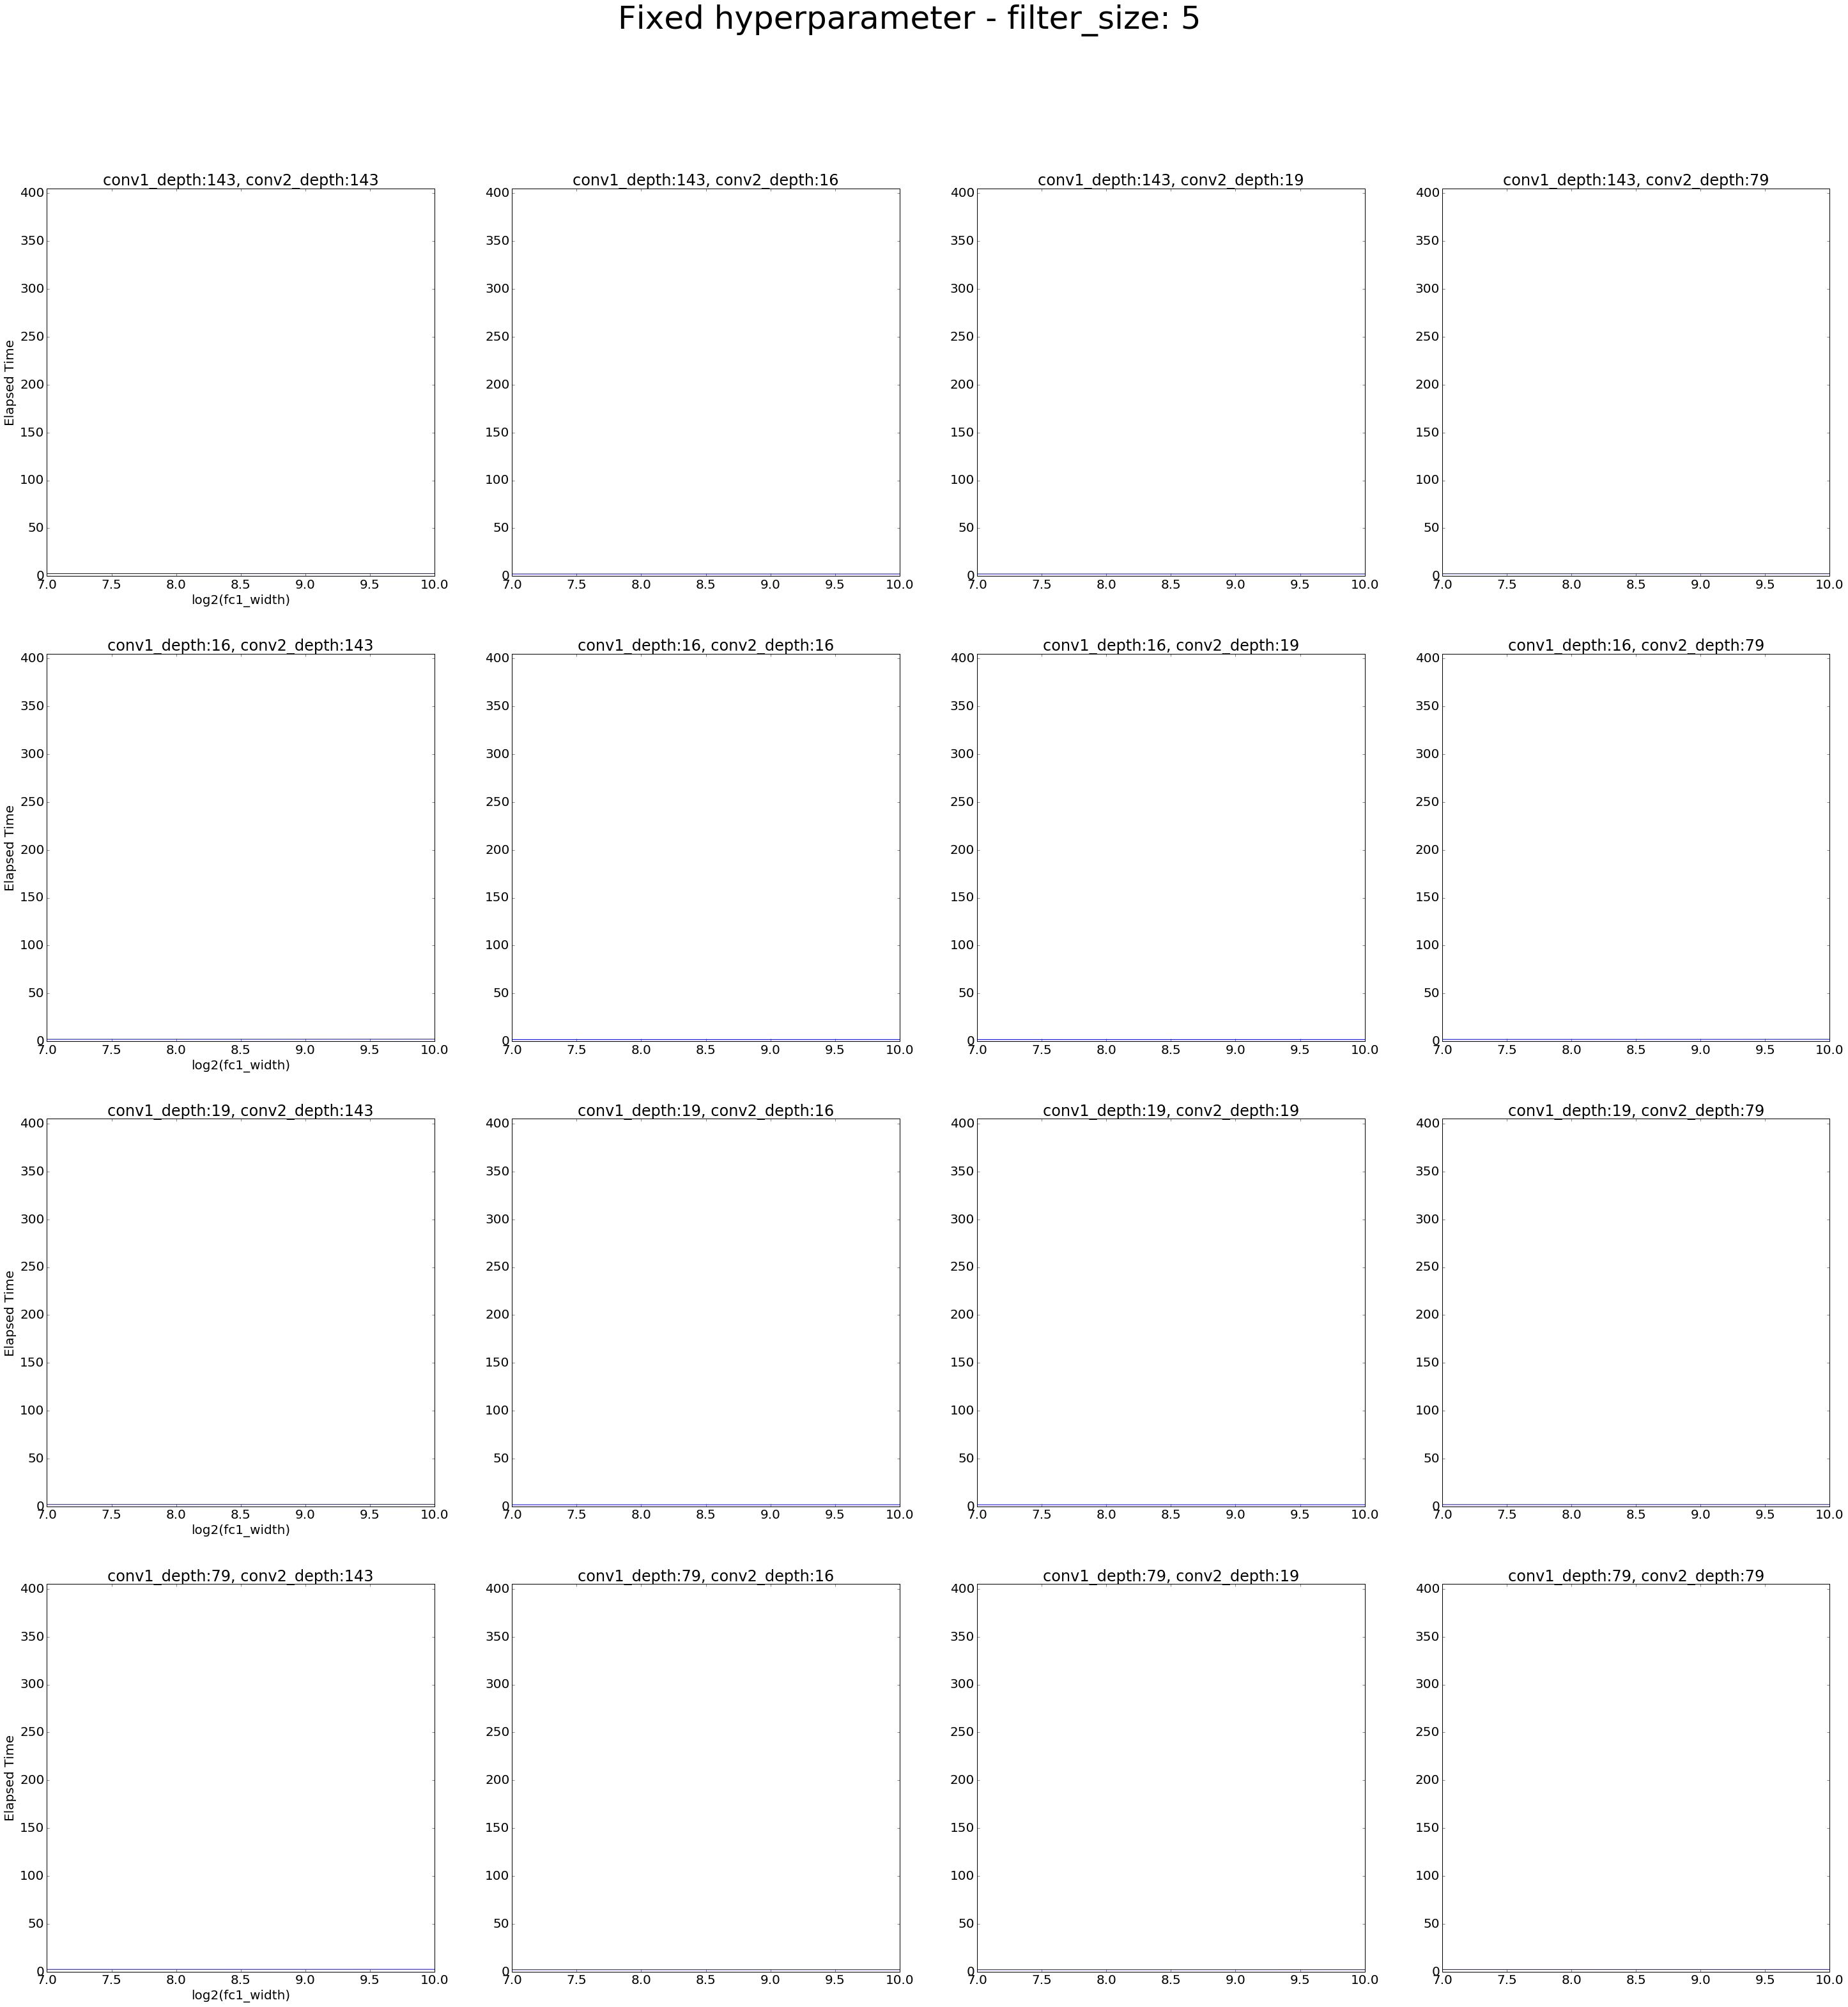

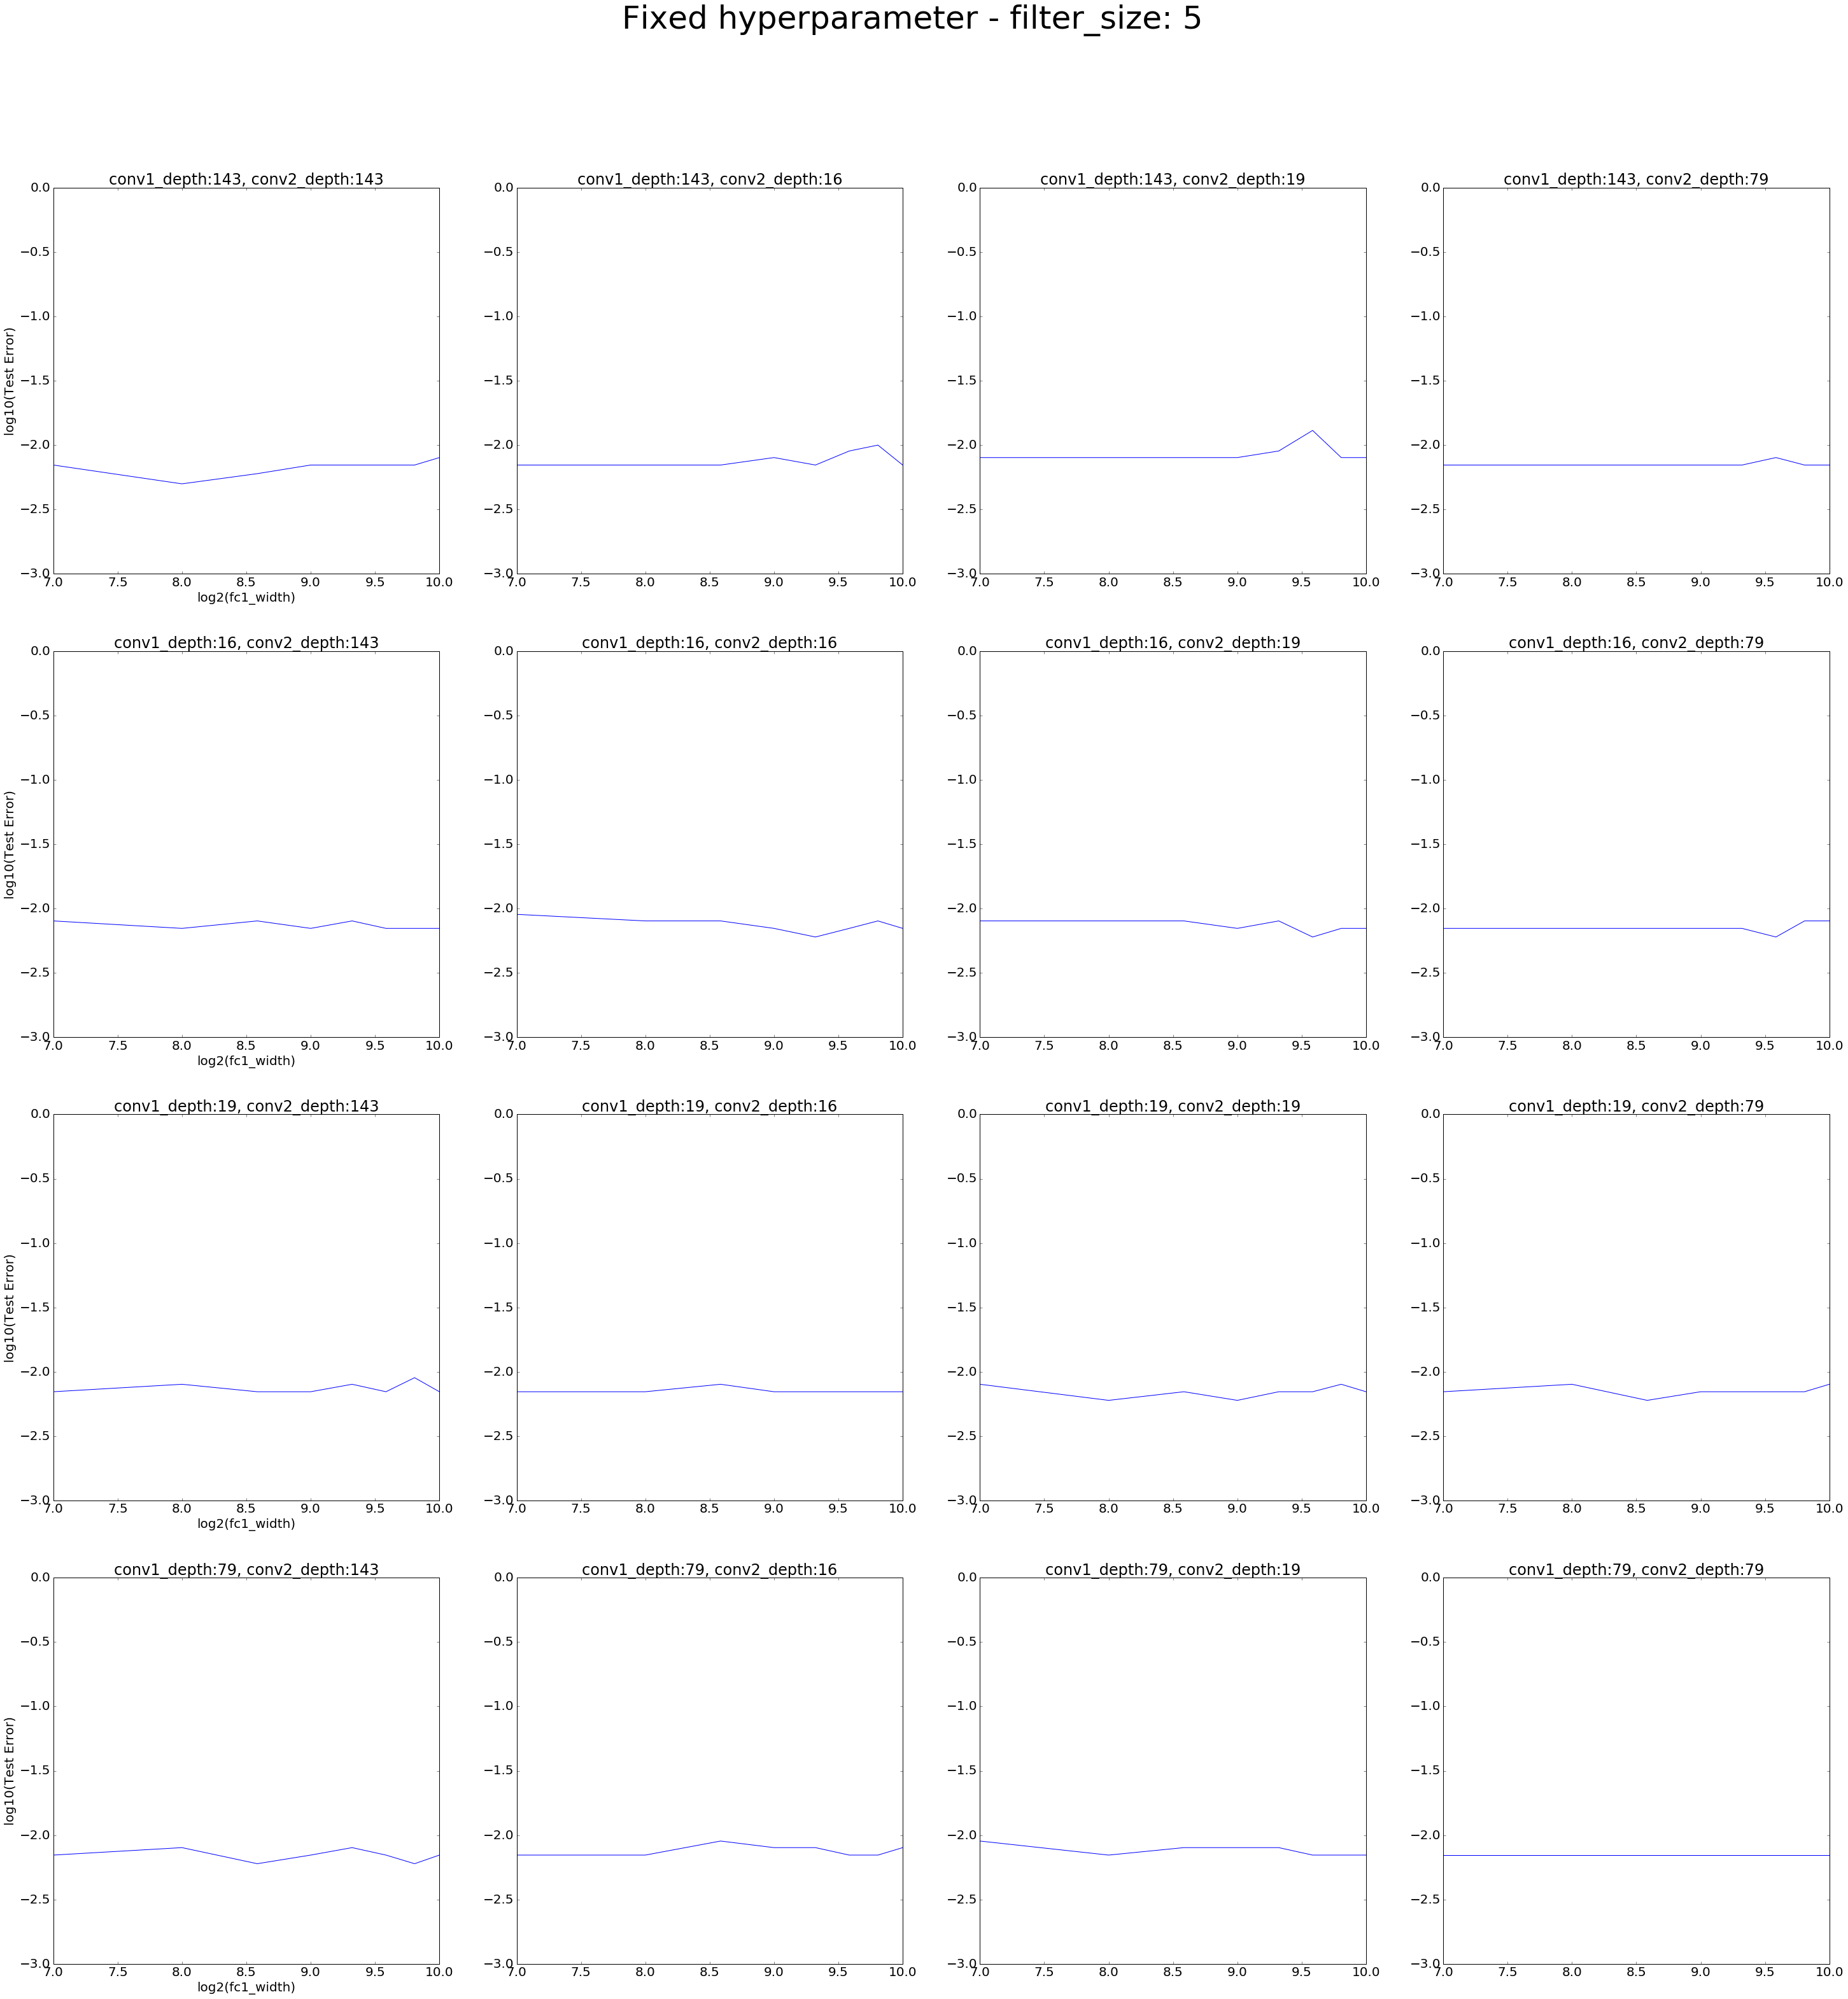

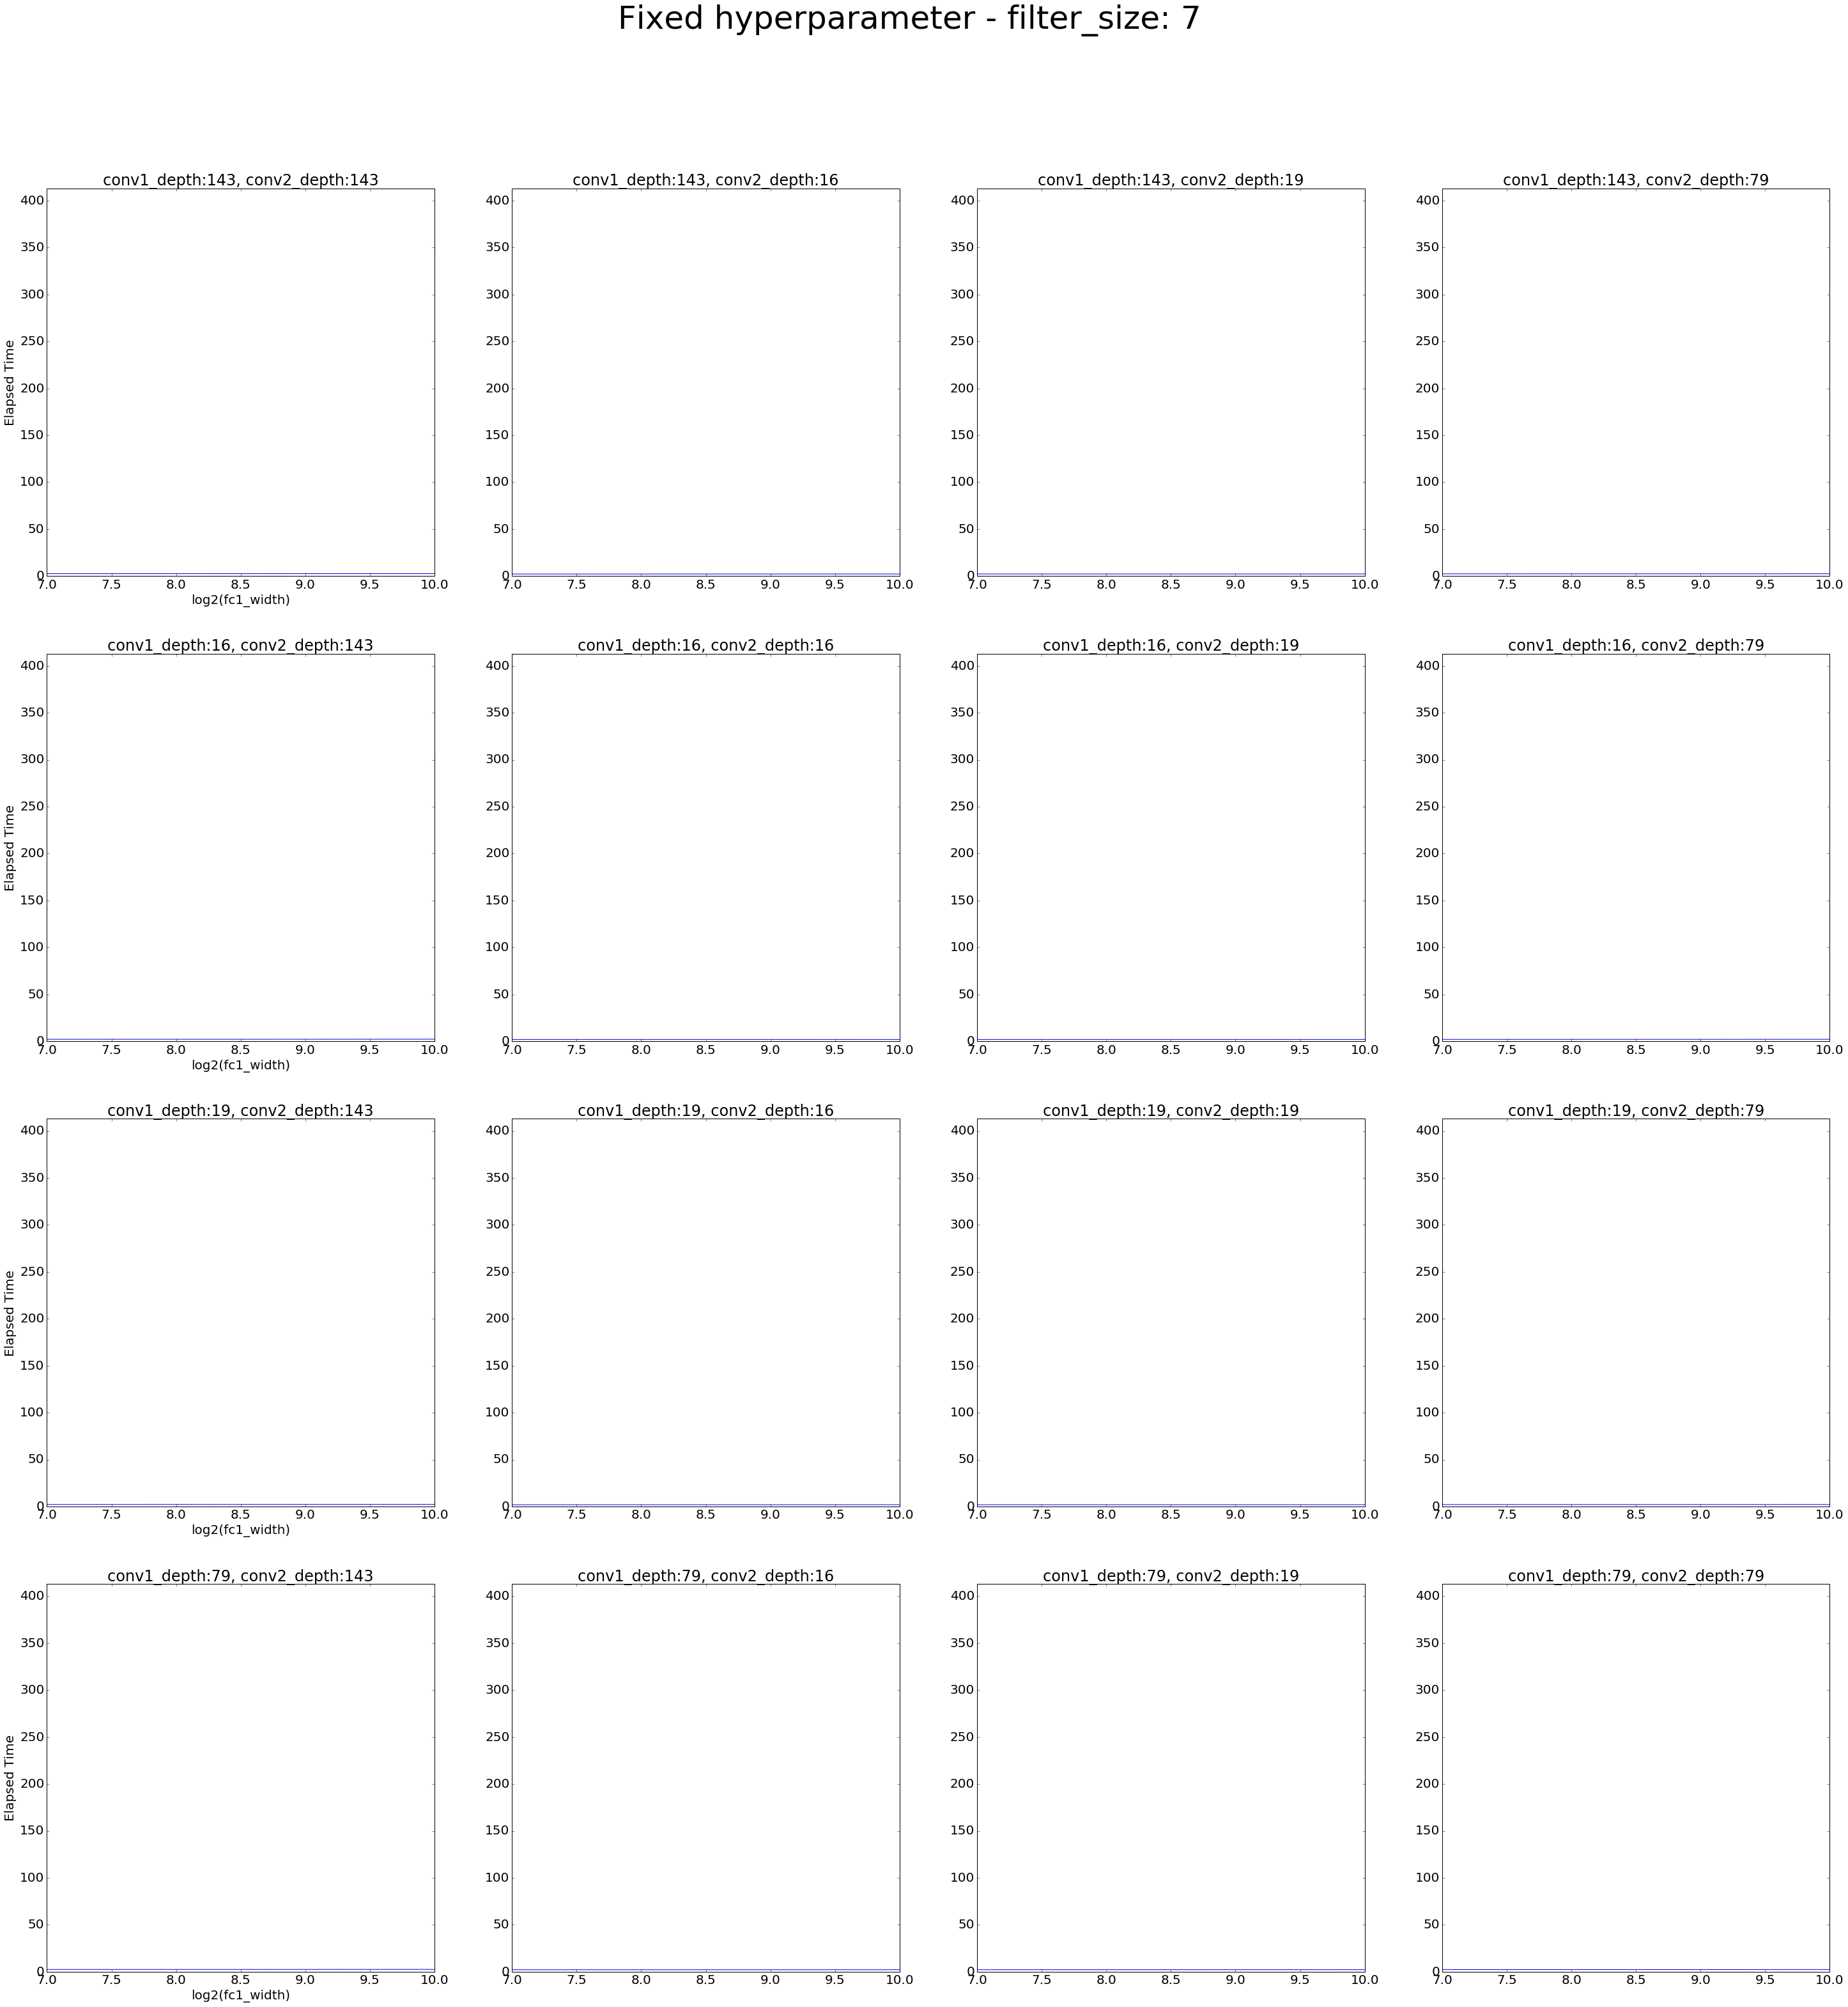

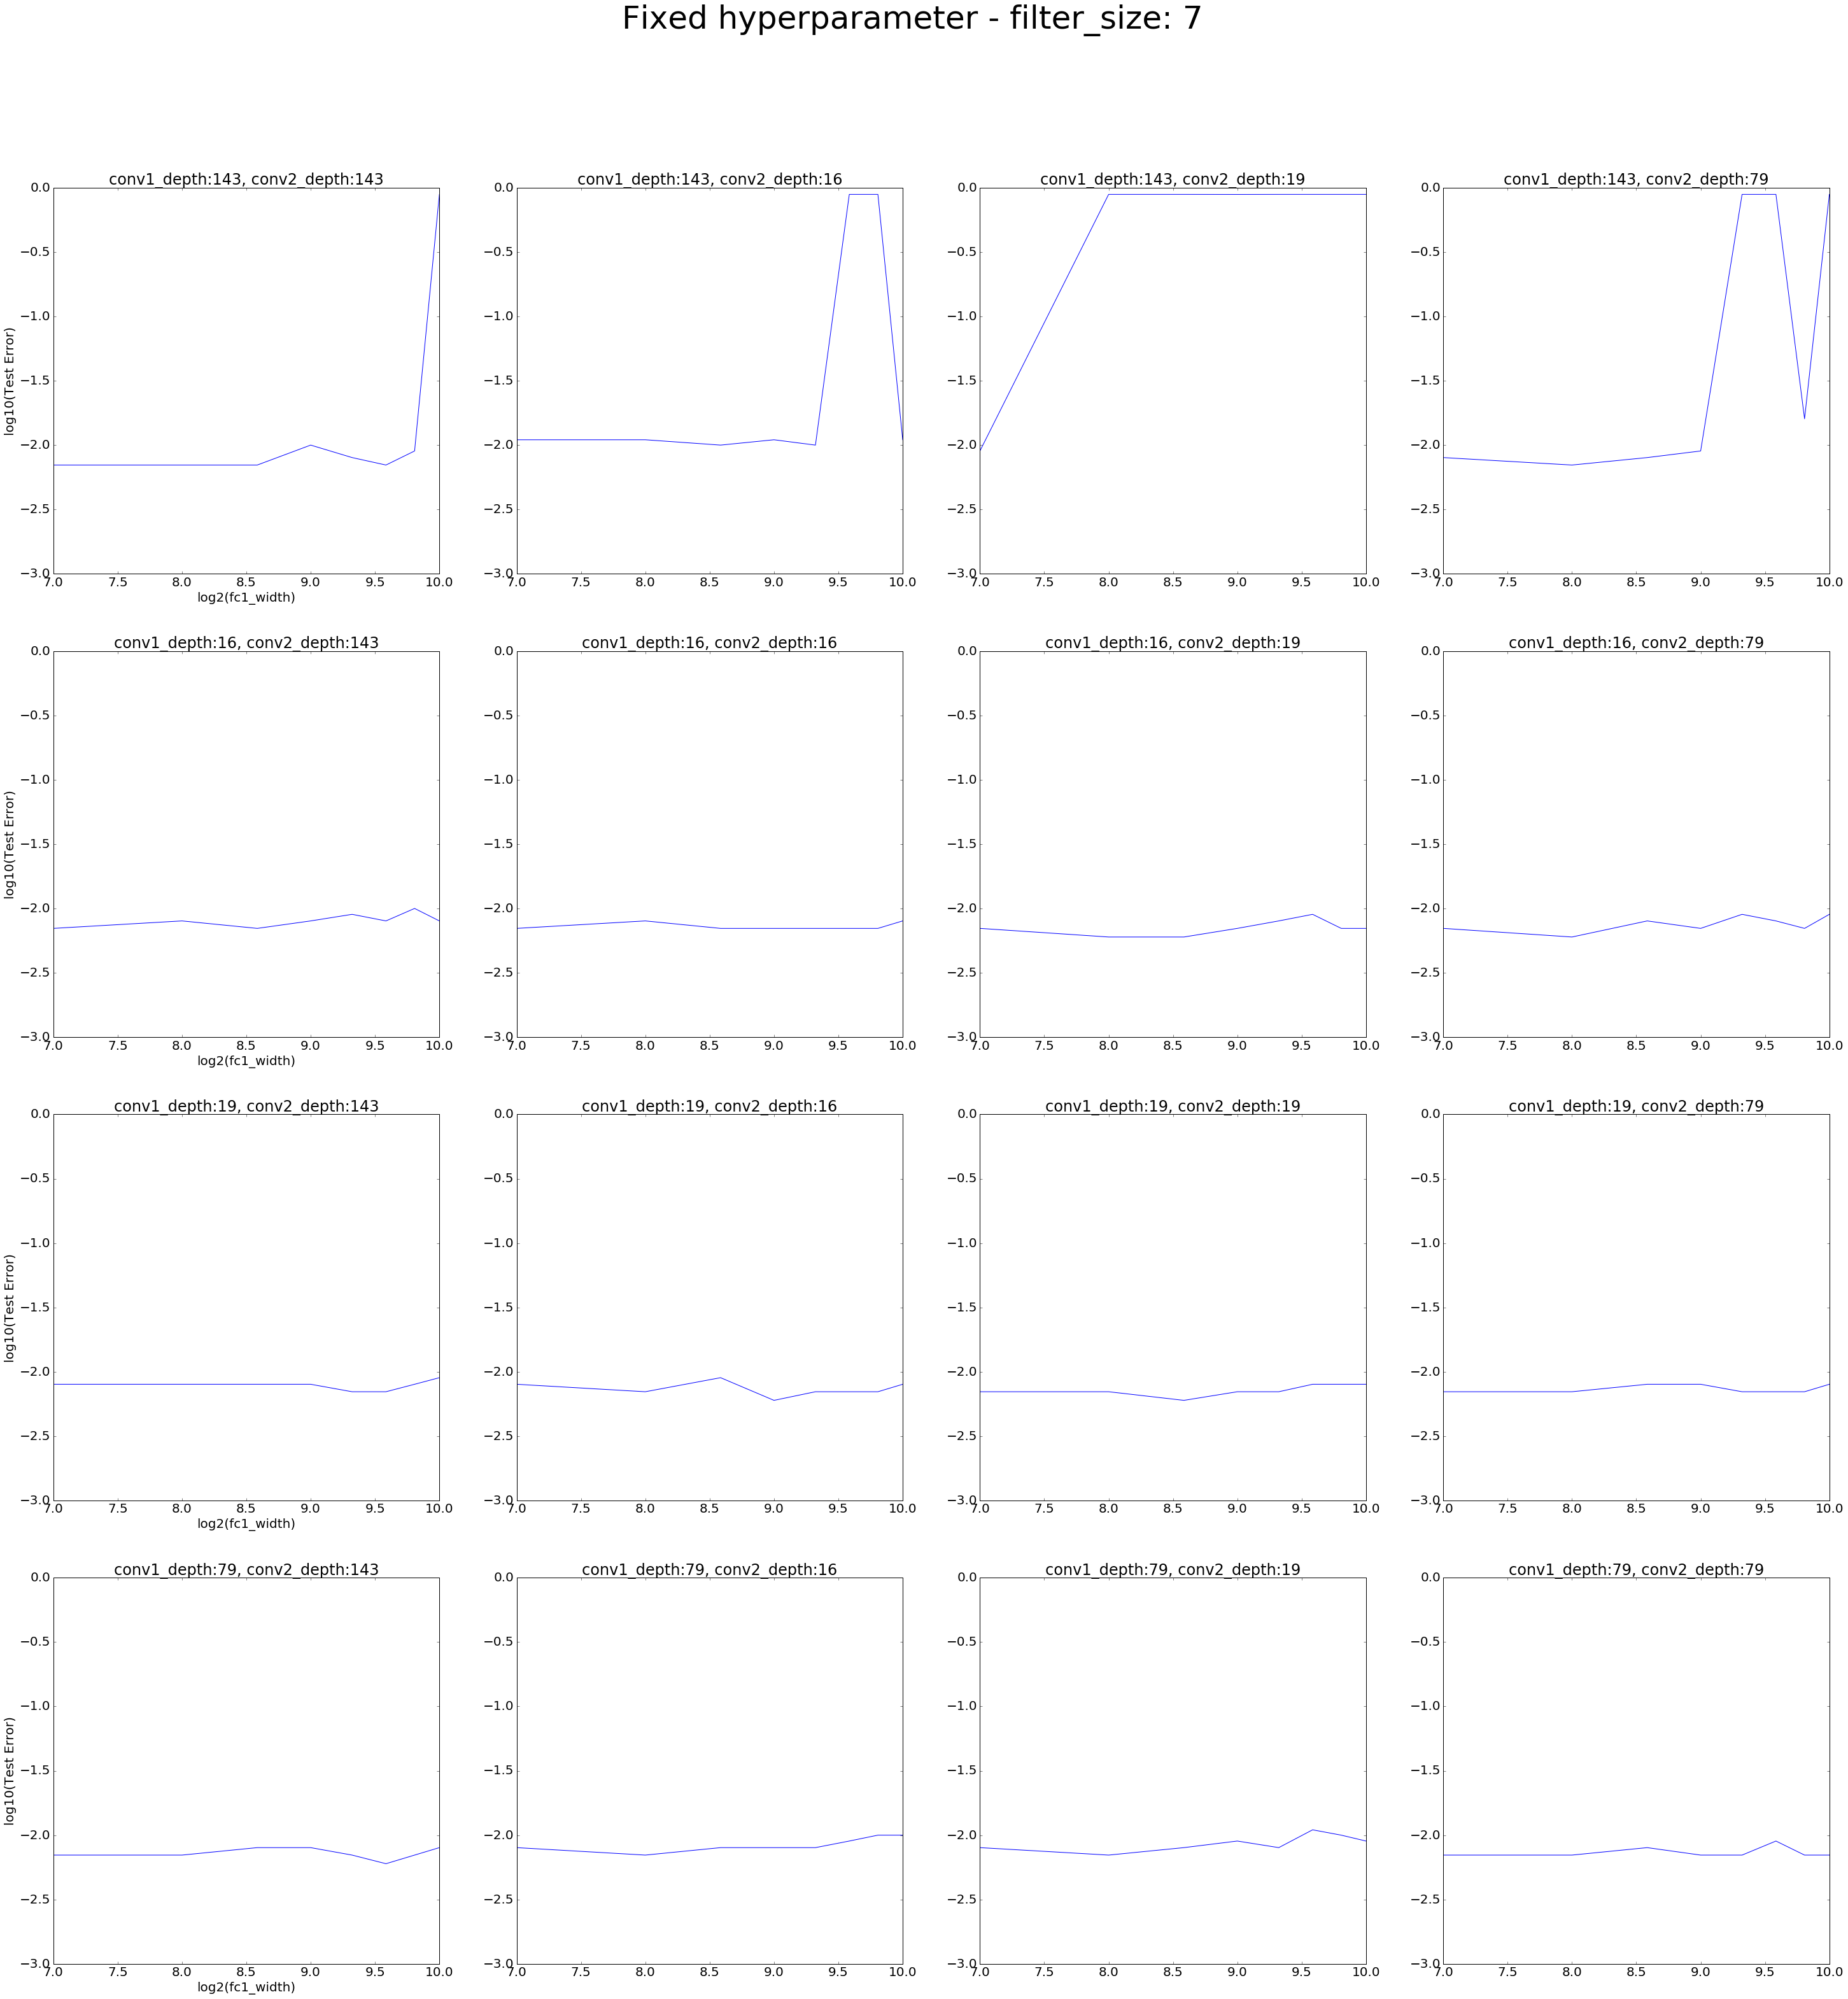

In [30]:
x_axis = {"name" : "conv1_depth", "values" : conv1_depths}
y_axis = {"name" : "conv2_depth", "values" : conv2_depths}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "fc1_width"

for f in filter_sizes:
    for output in outputs:
        fixed = {"name": "filter_size", "value": f}
        draw_n_by_n_plots(total_only_table, fixed, x_axis, y_axis, selected_dim, output, False, True)

fc1_width_128-Elapsed_Time.png is saved successfully.
fc1_width_128-Test_Error.png is saved successfully.
fc1_width_896-Elapsed_Time.png is saved successfully.
fc1_width_896-Test_Error.png is saved successfully.
fc1_width_384-Elapsed_Time.png is saved successfully.
fc1_width_384-Test_Error.png is saved successfully.
fc1_width_640-Elapsed_Time.png is saved successfully.
fc1_width_640-Test_Error.png is saved successfully.


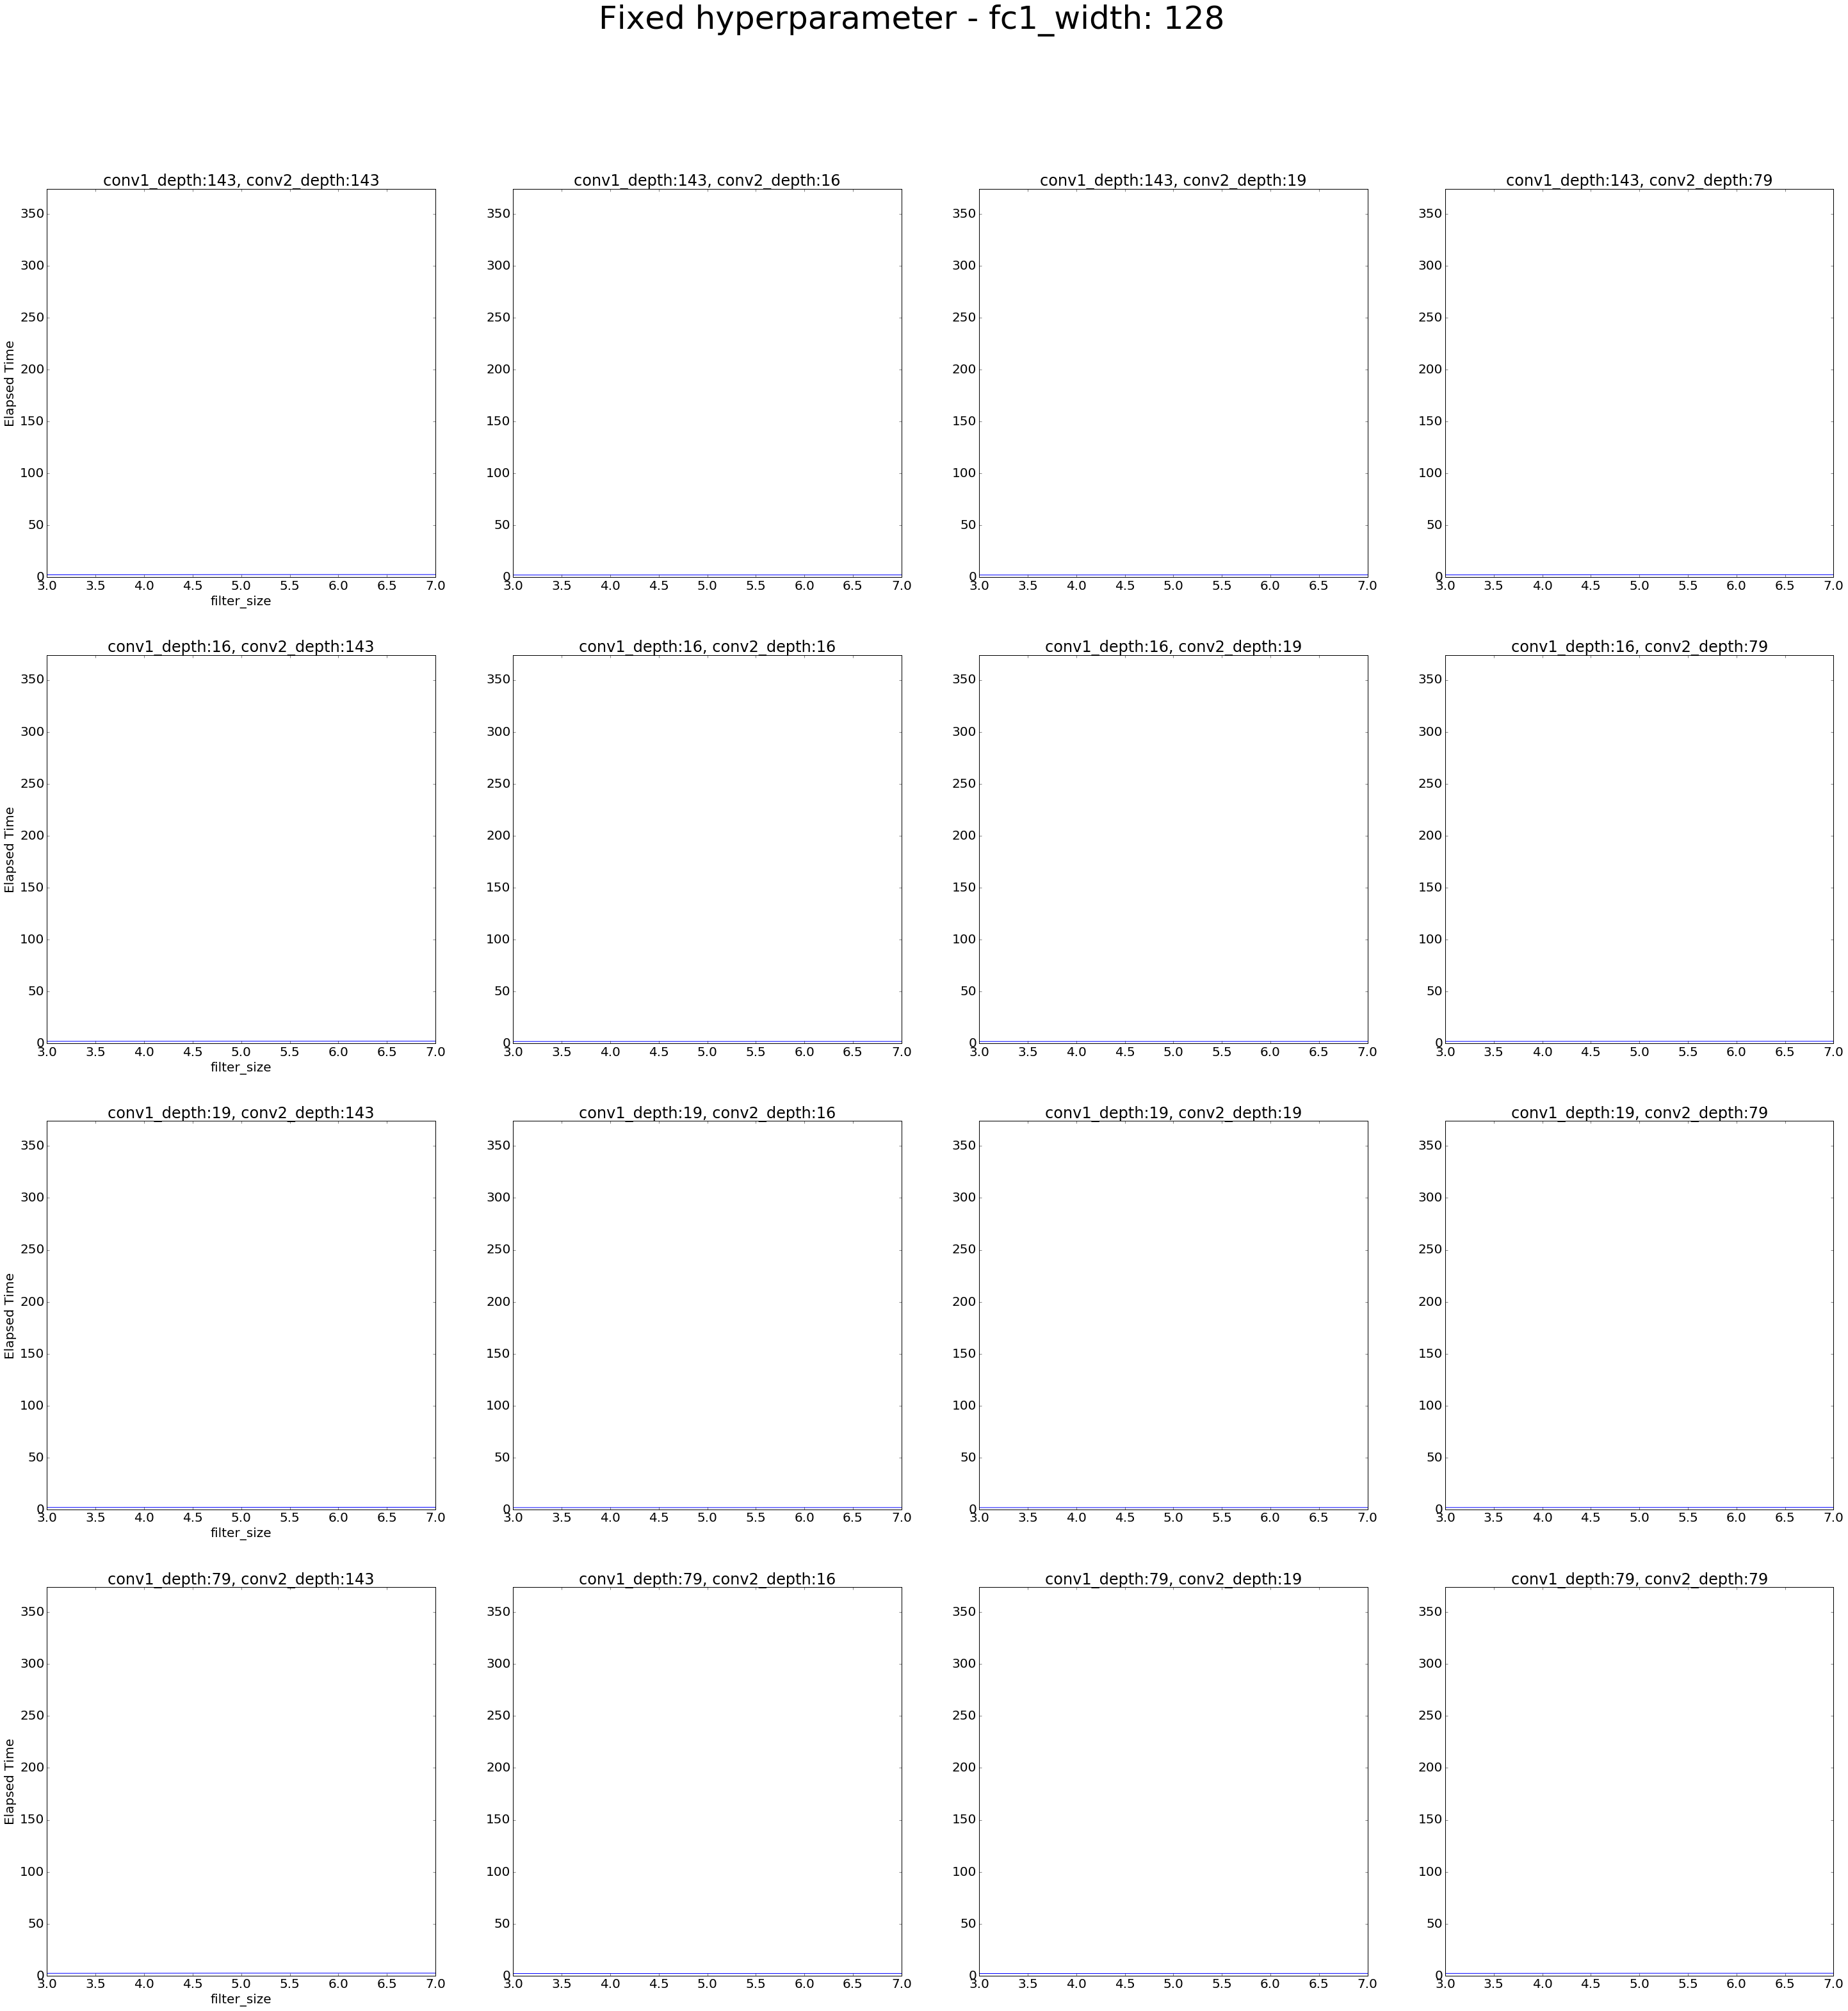

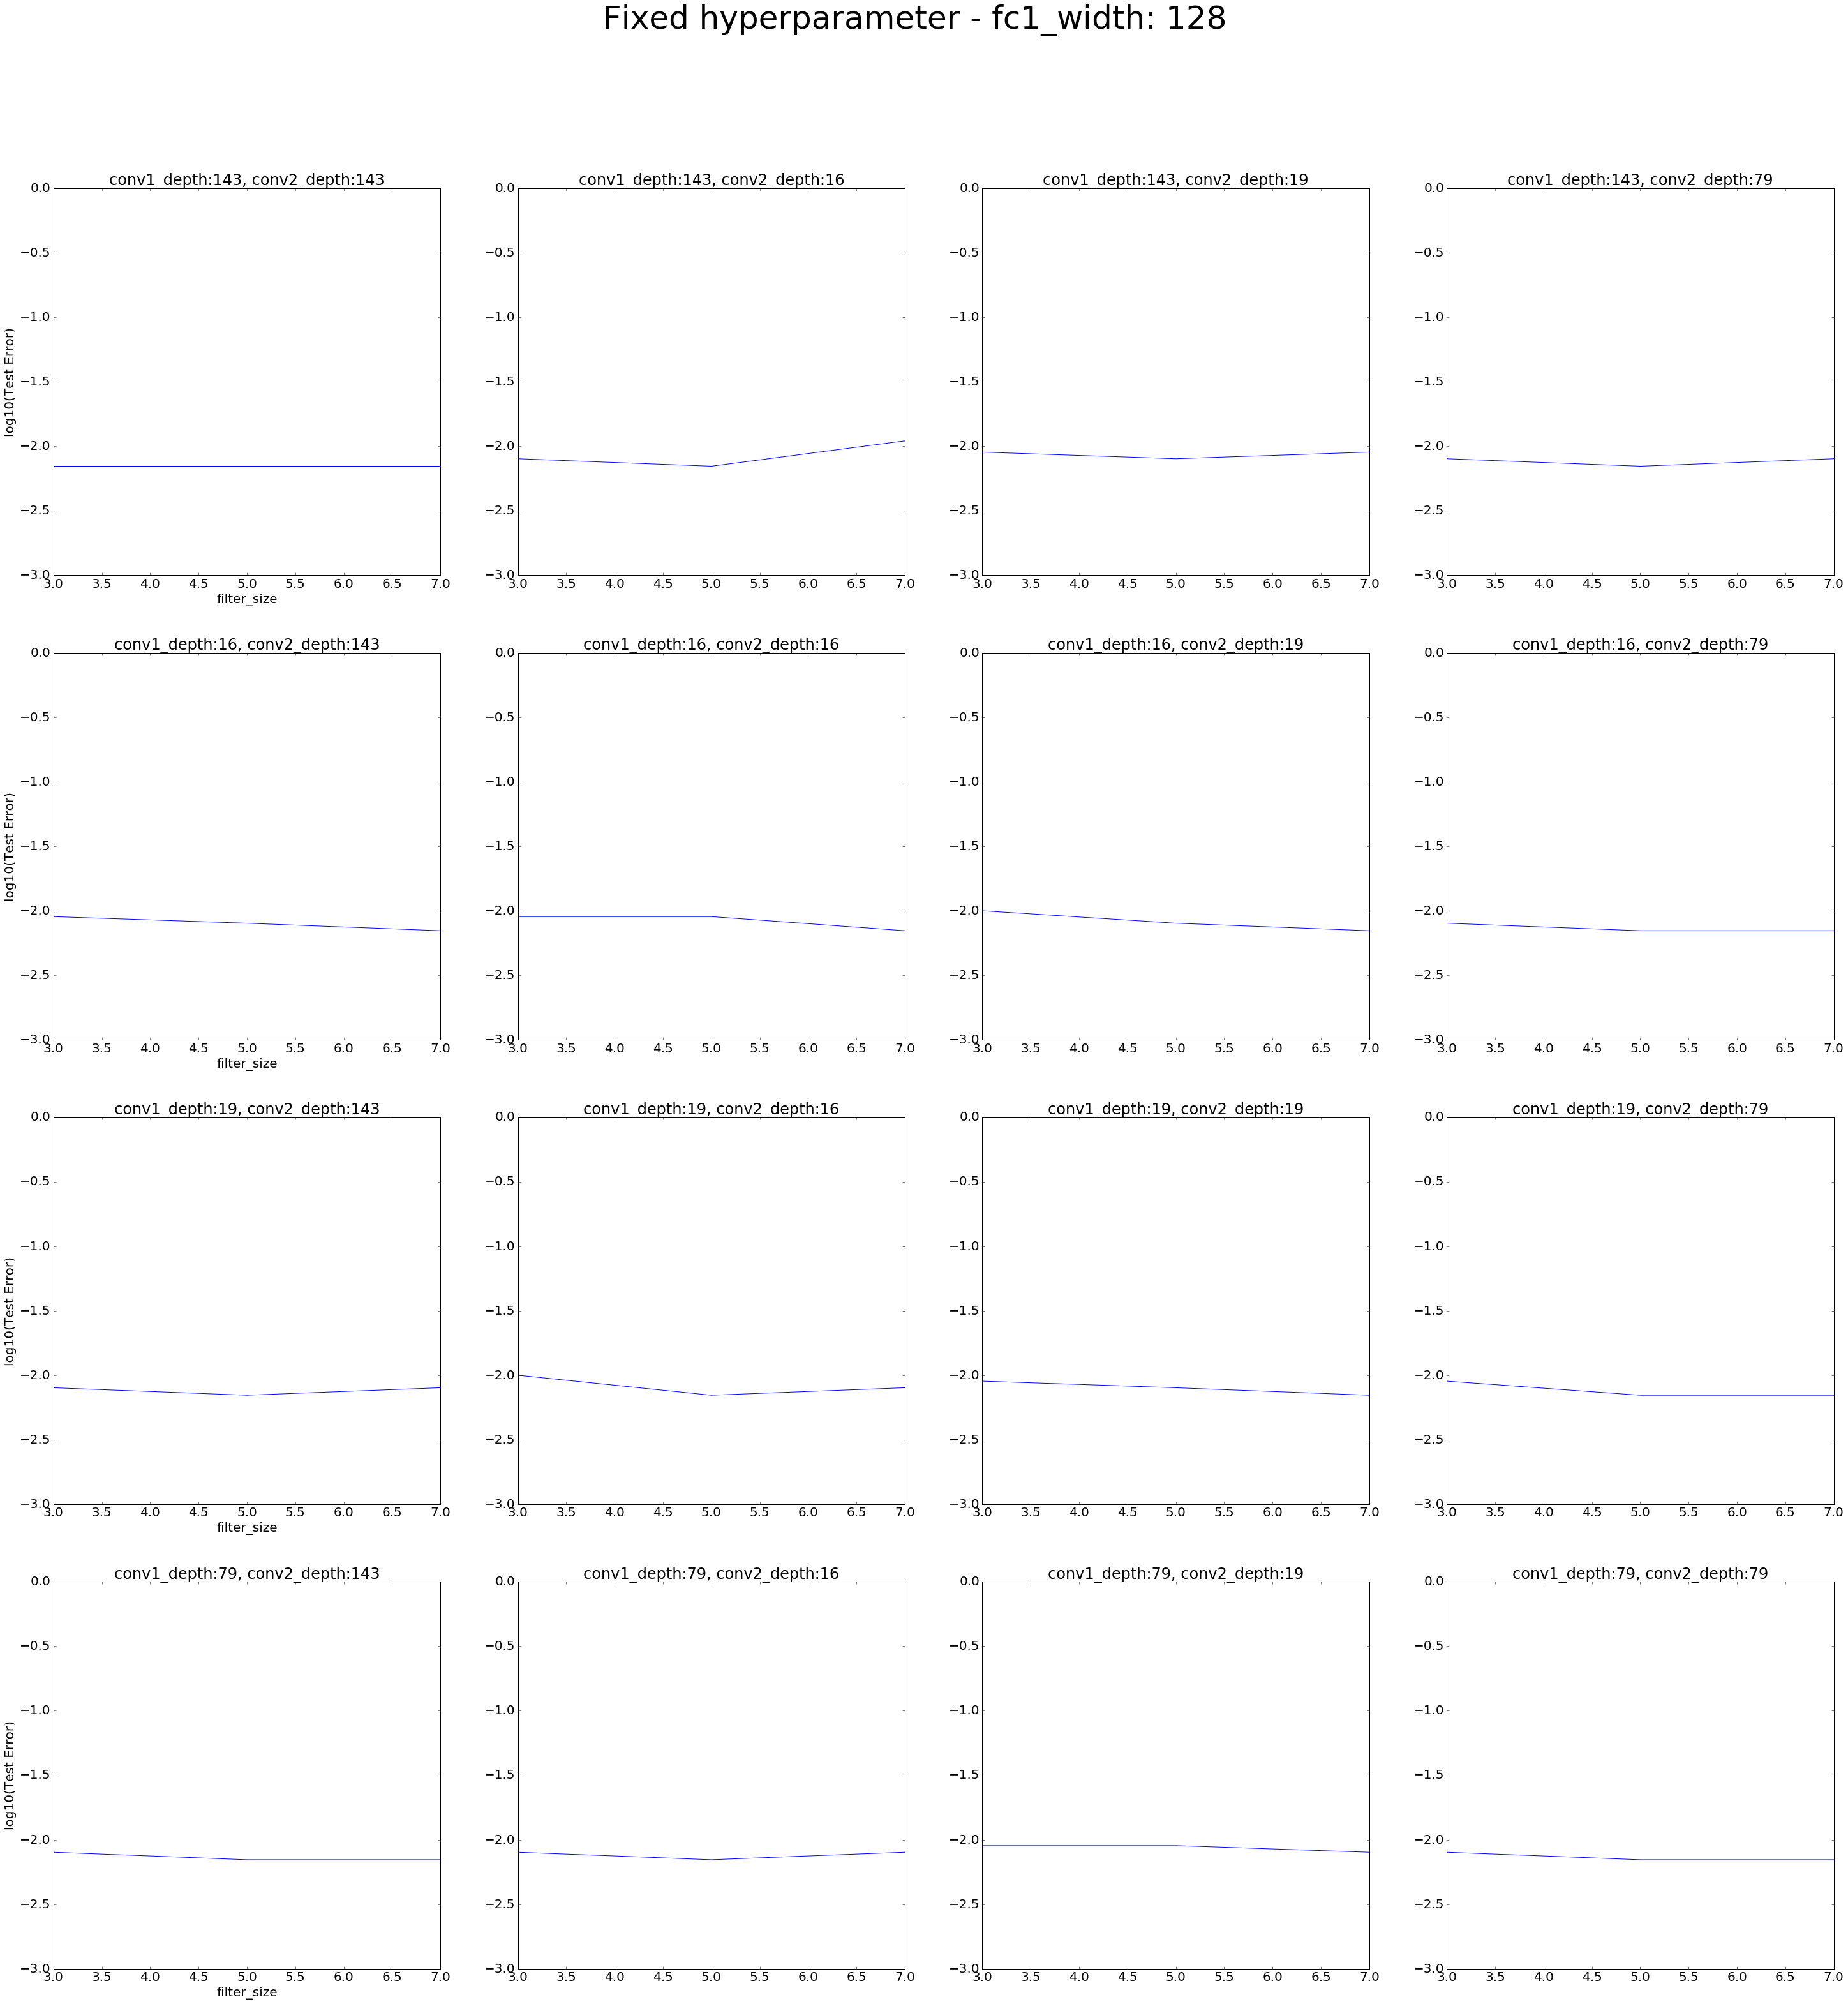

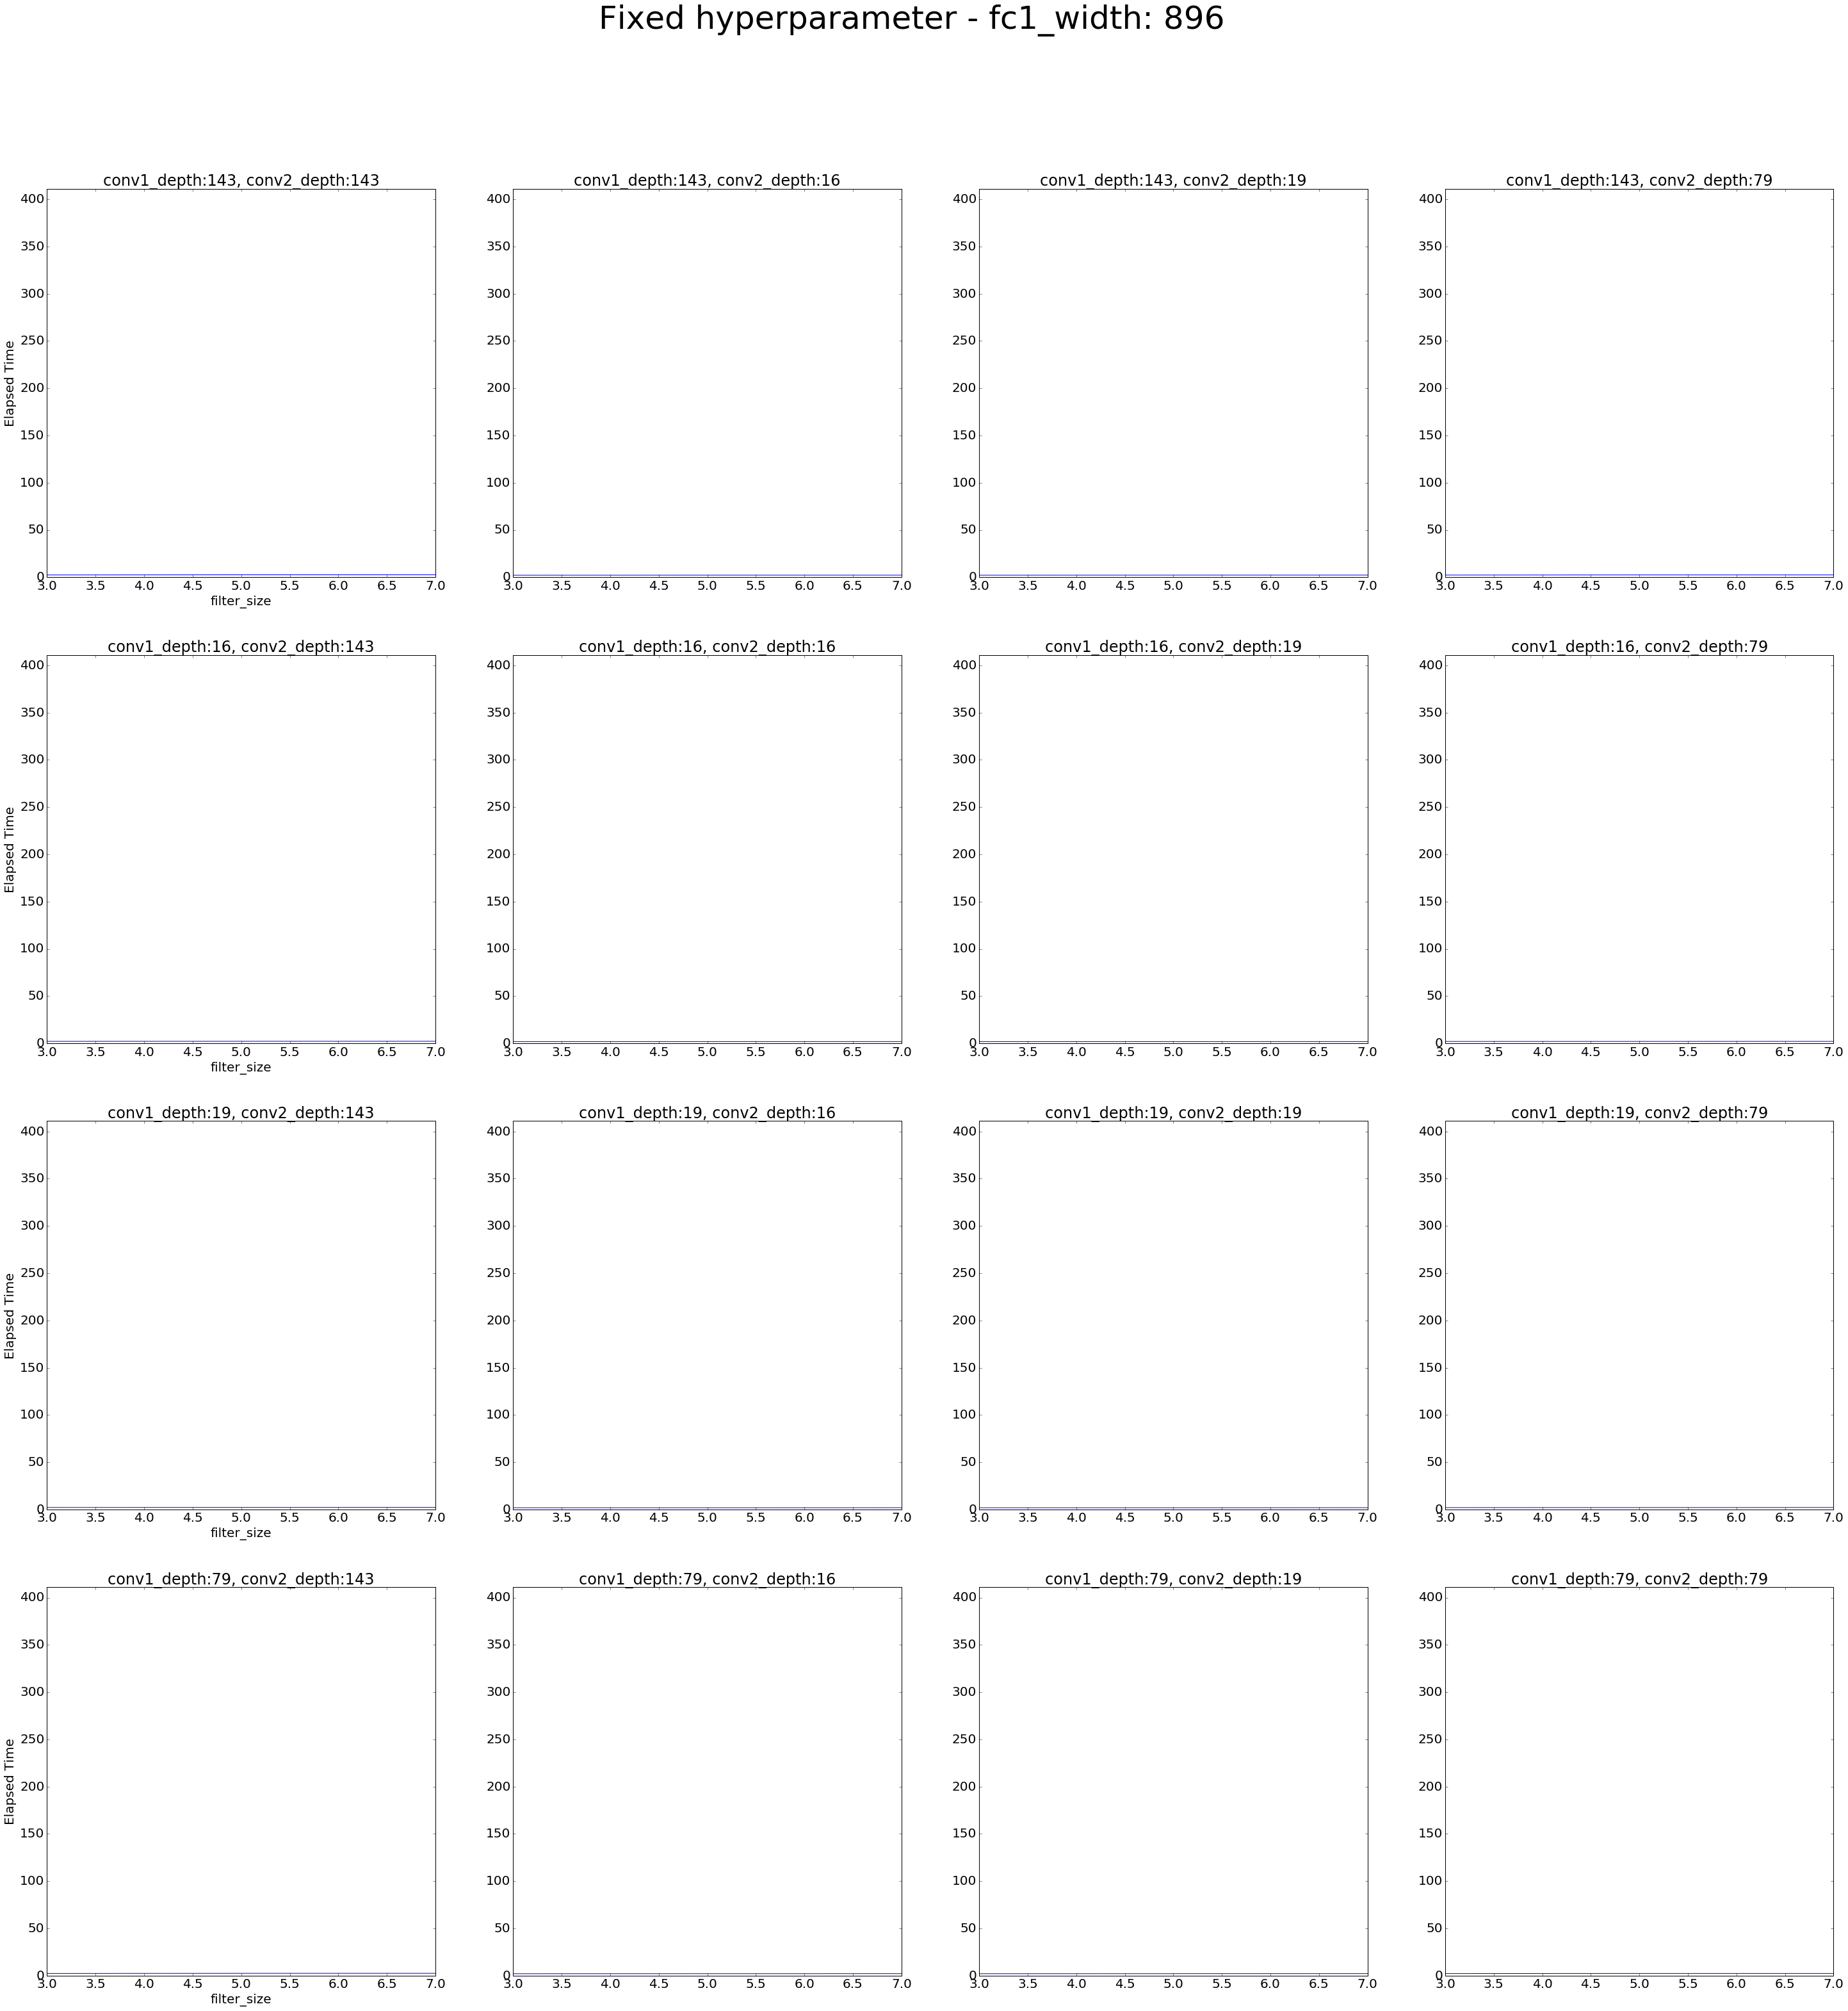

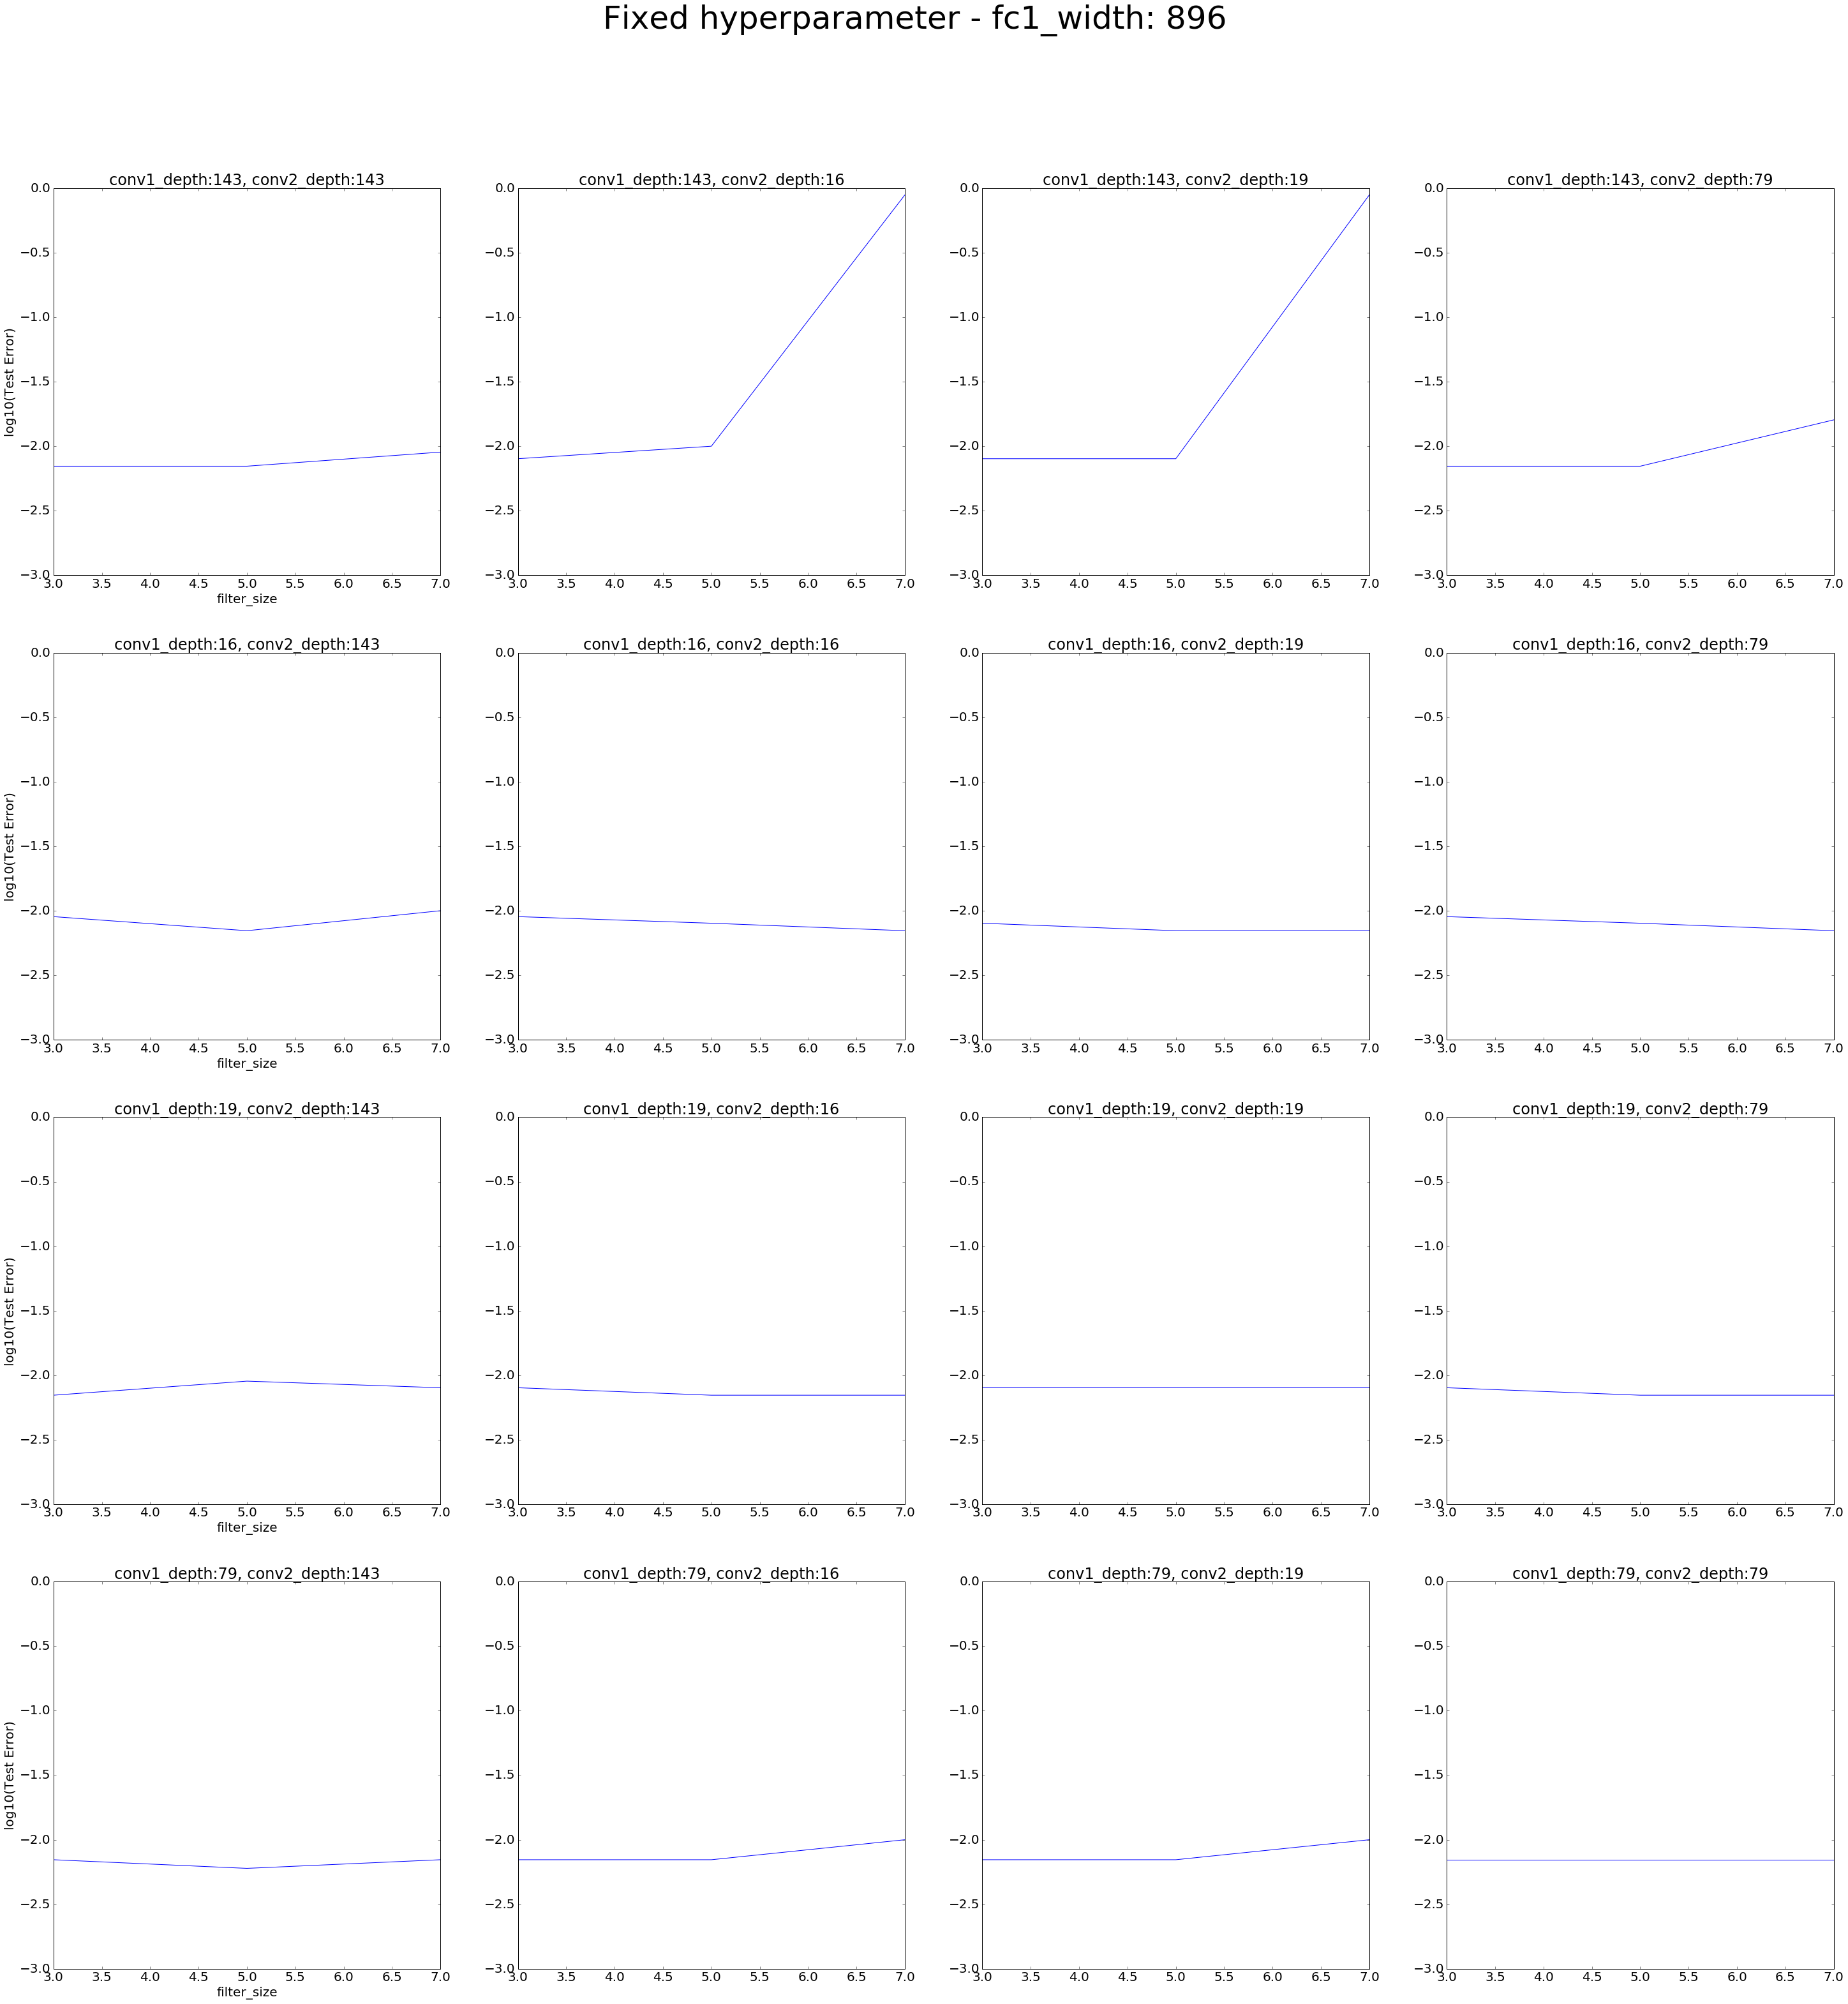

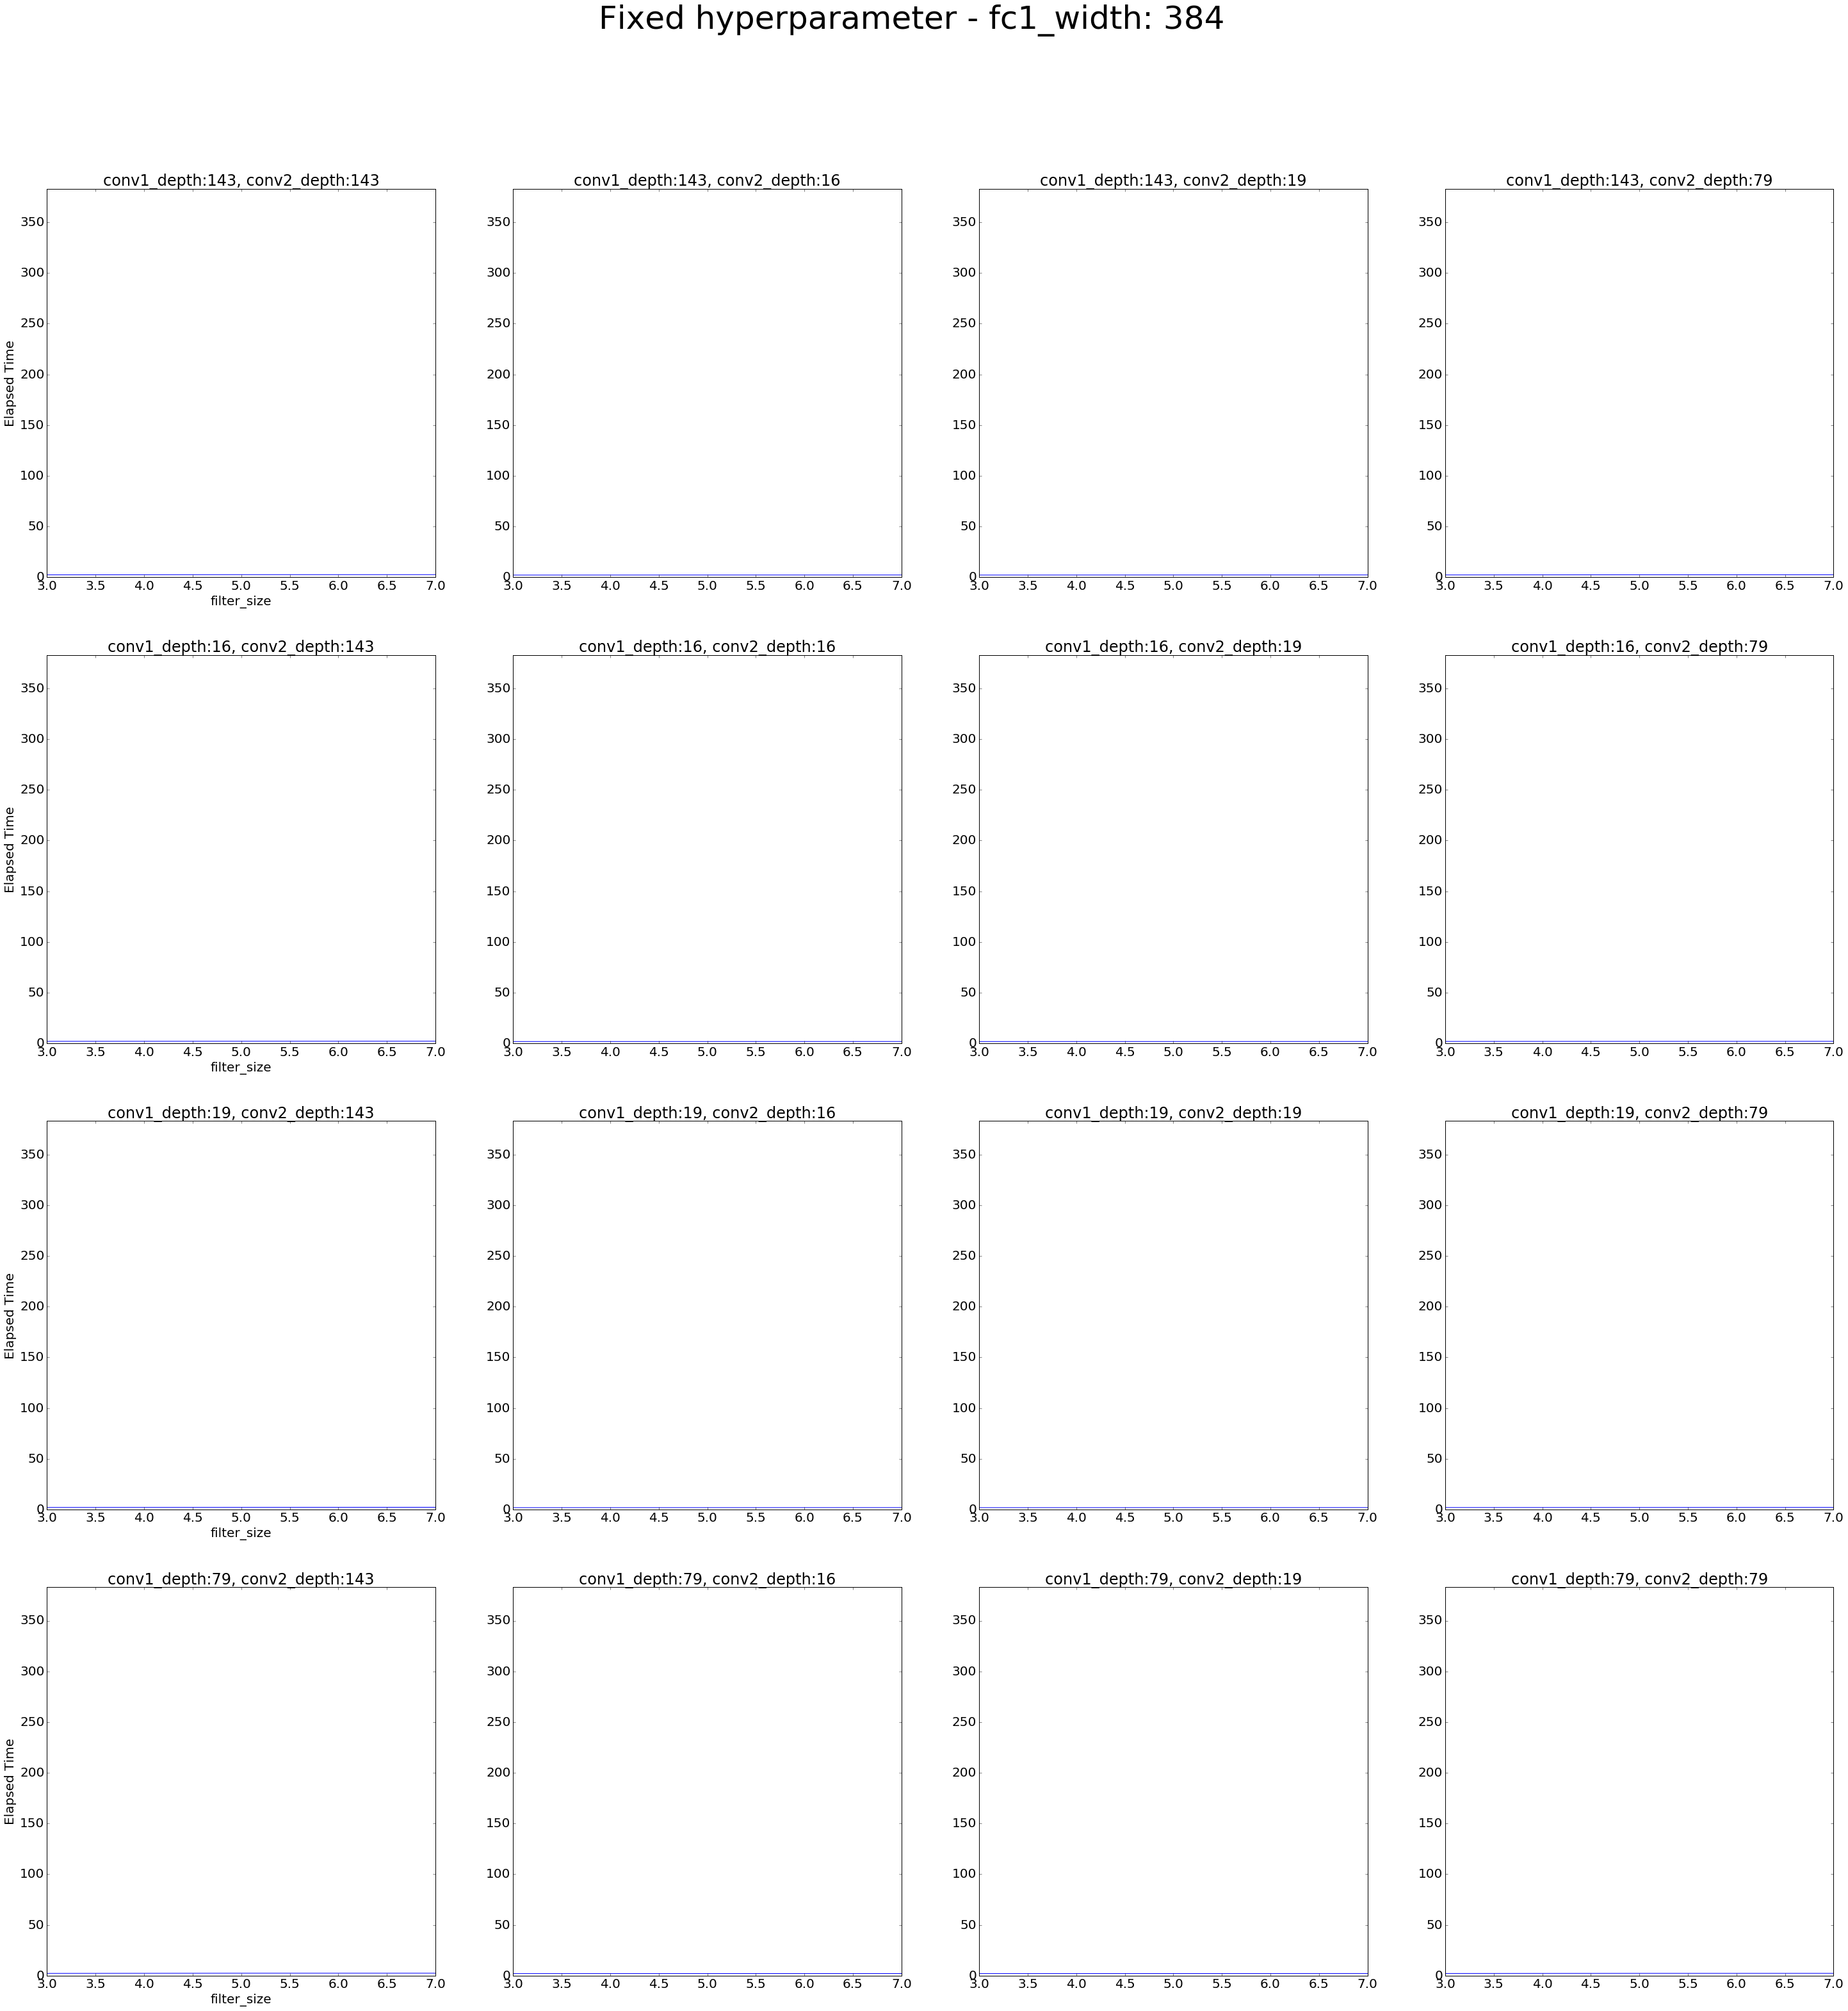

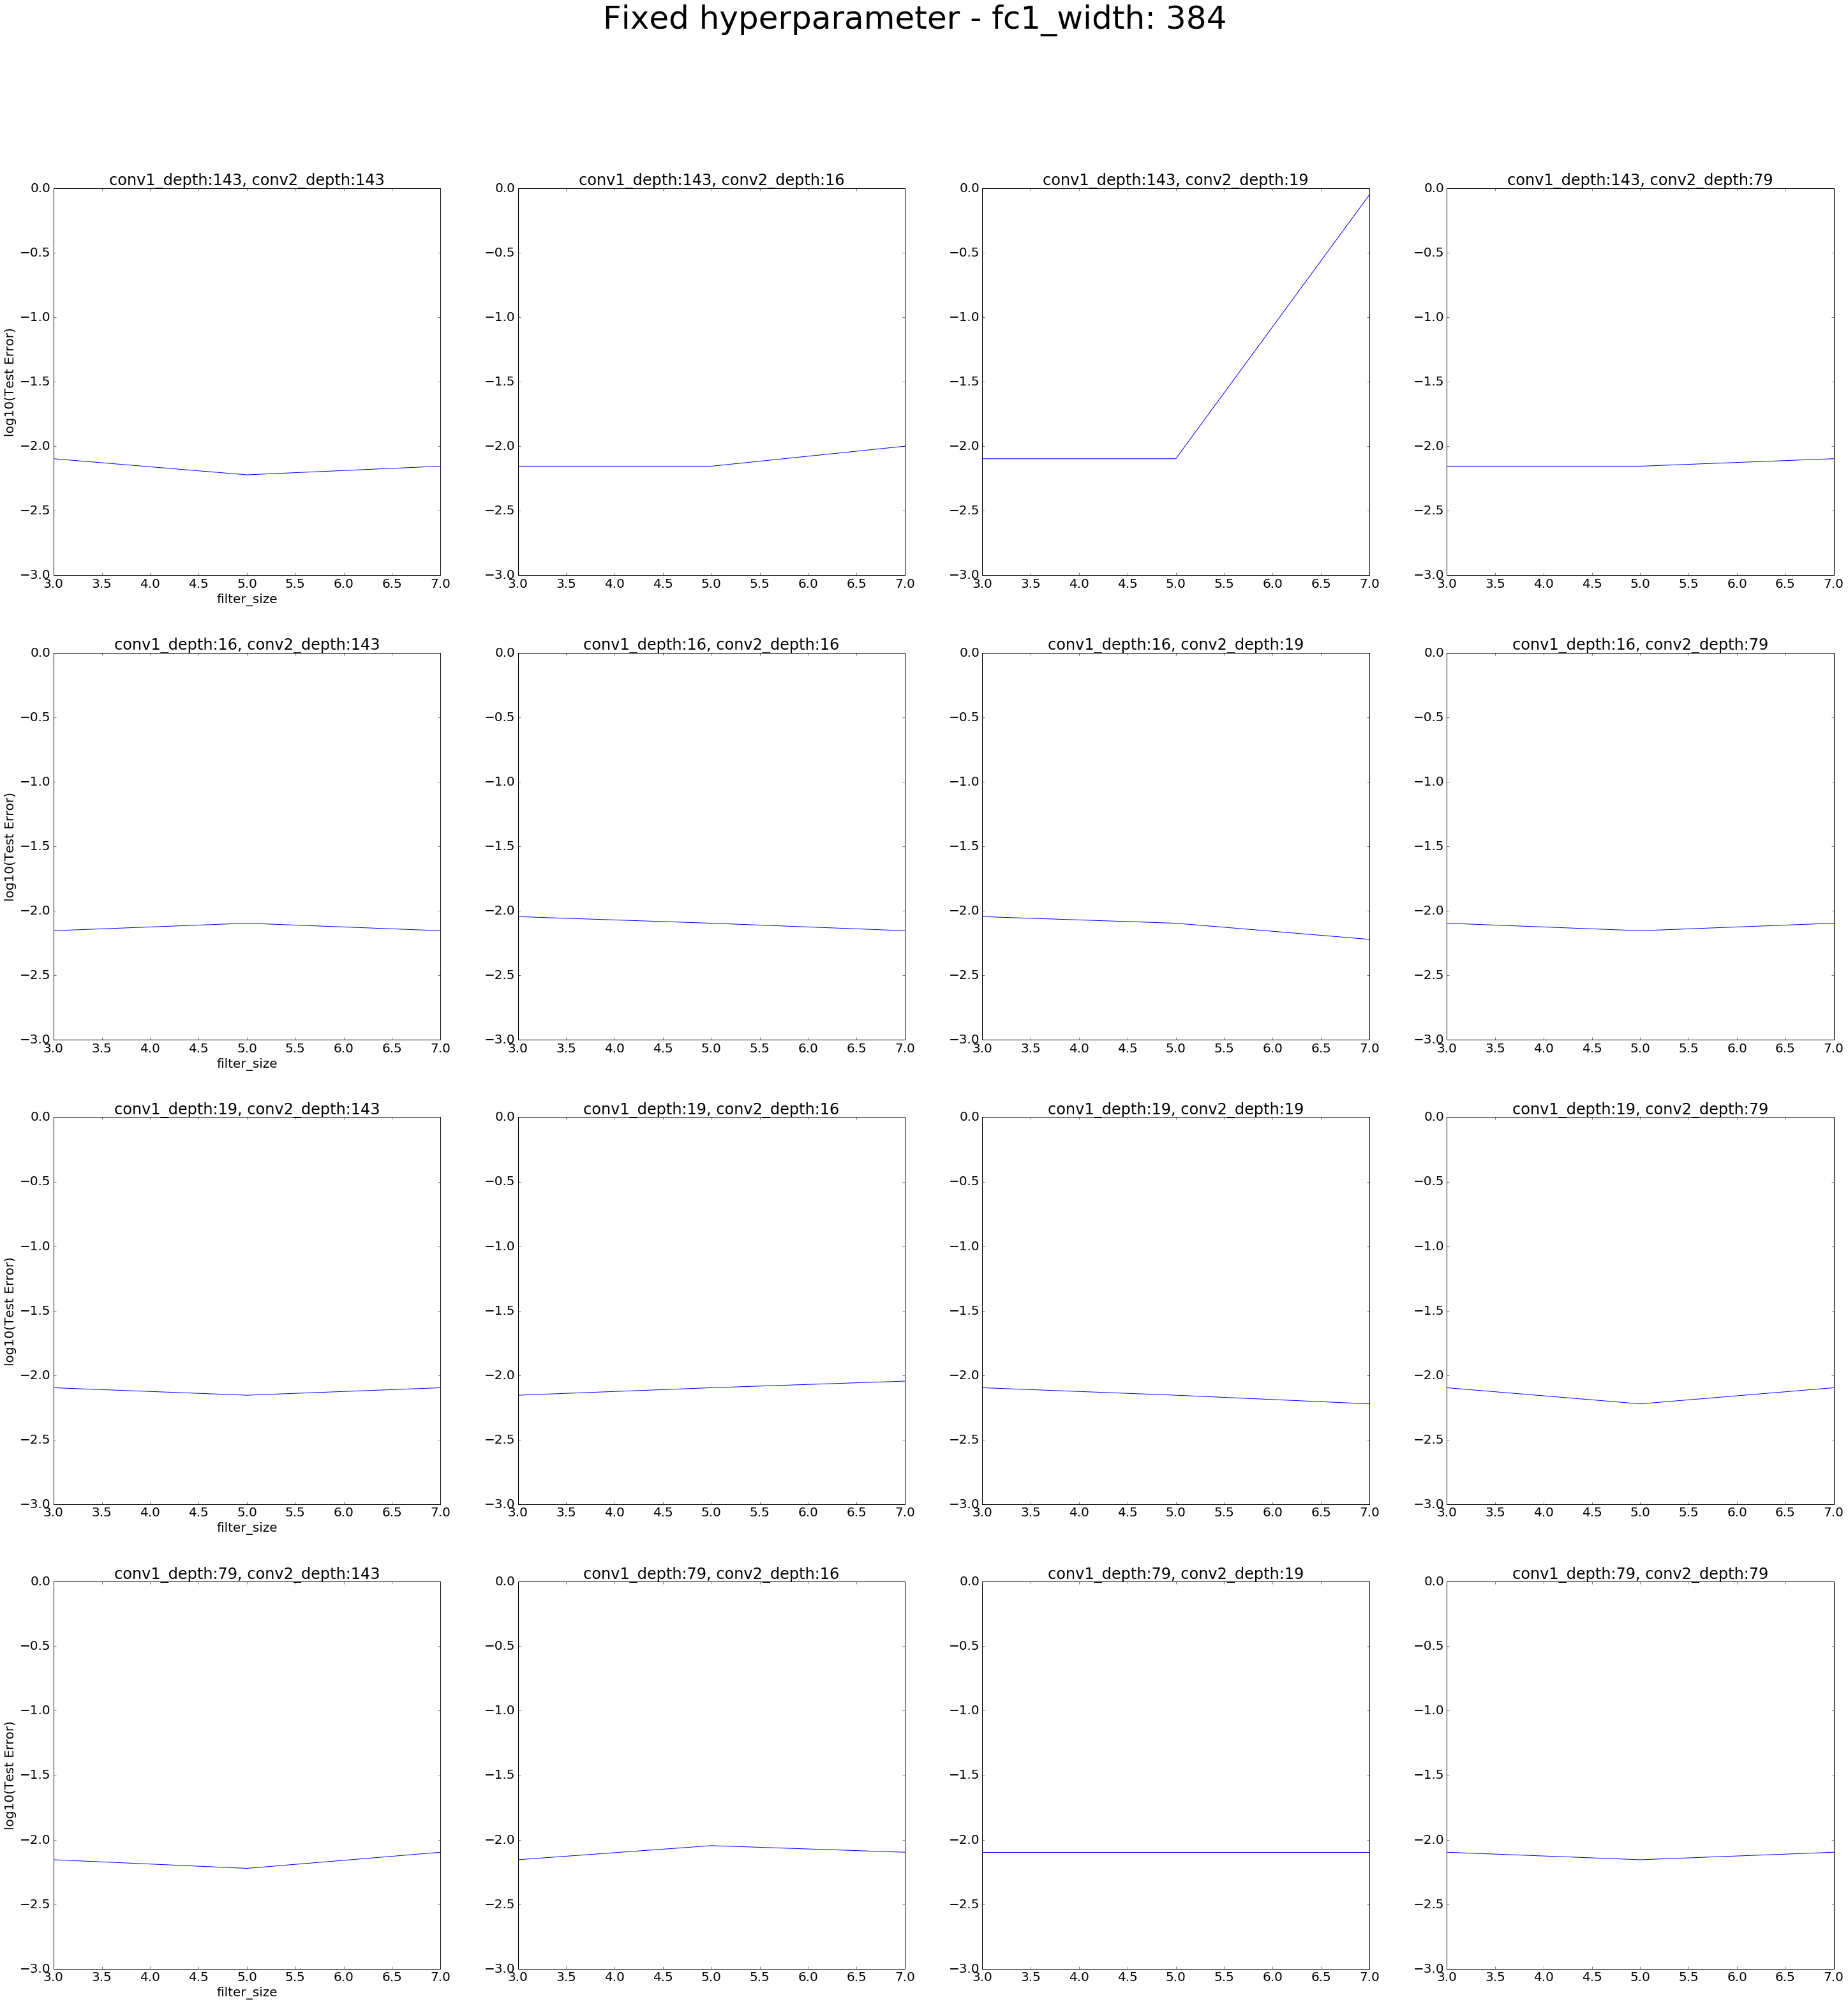

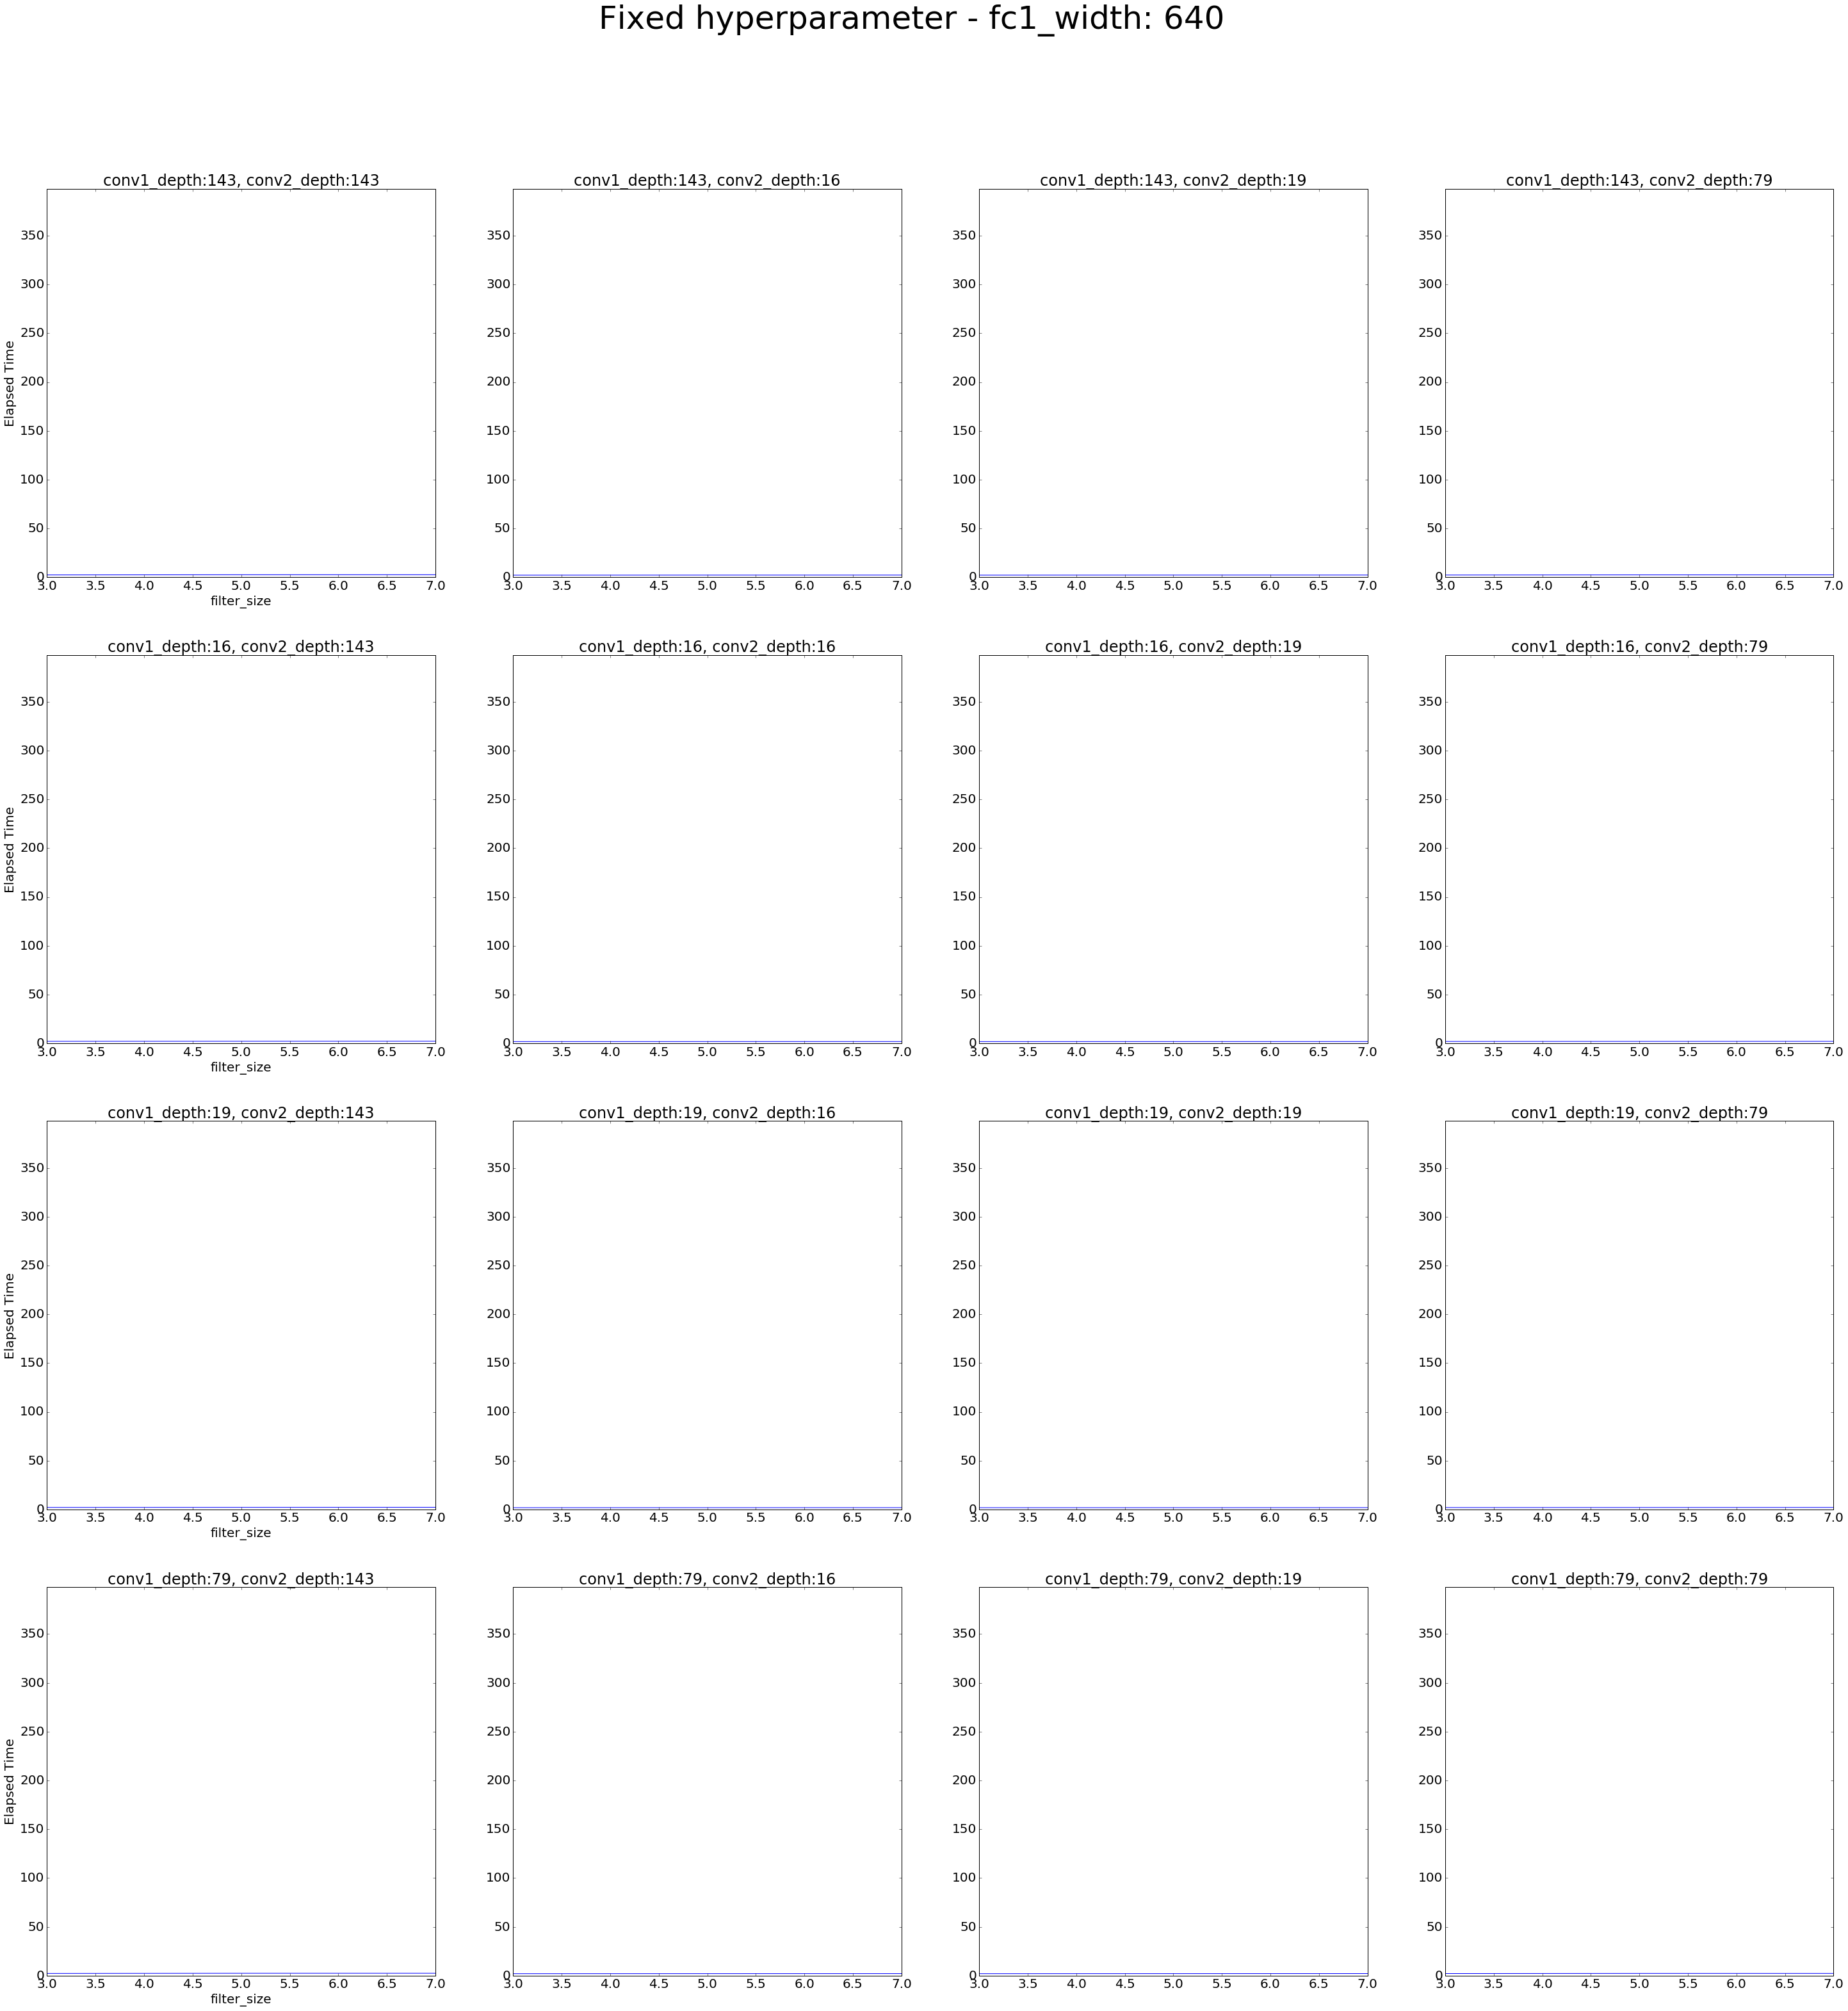

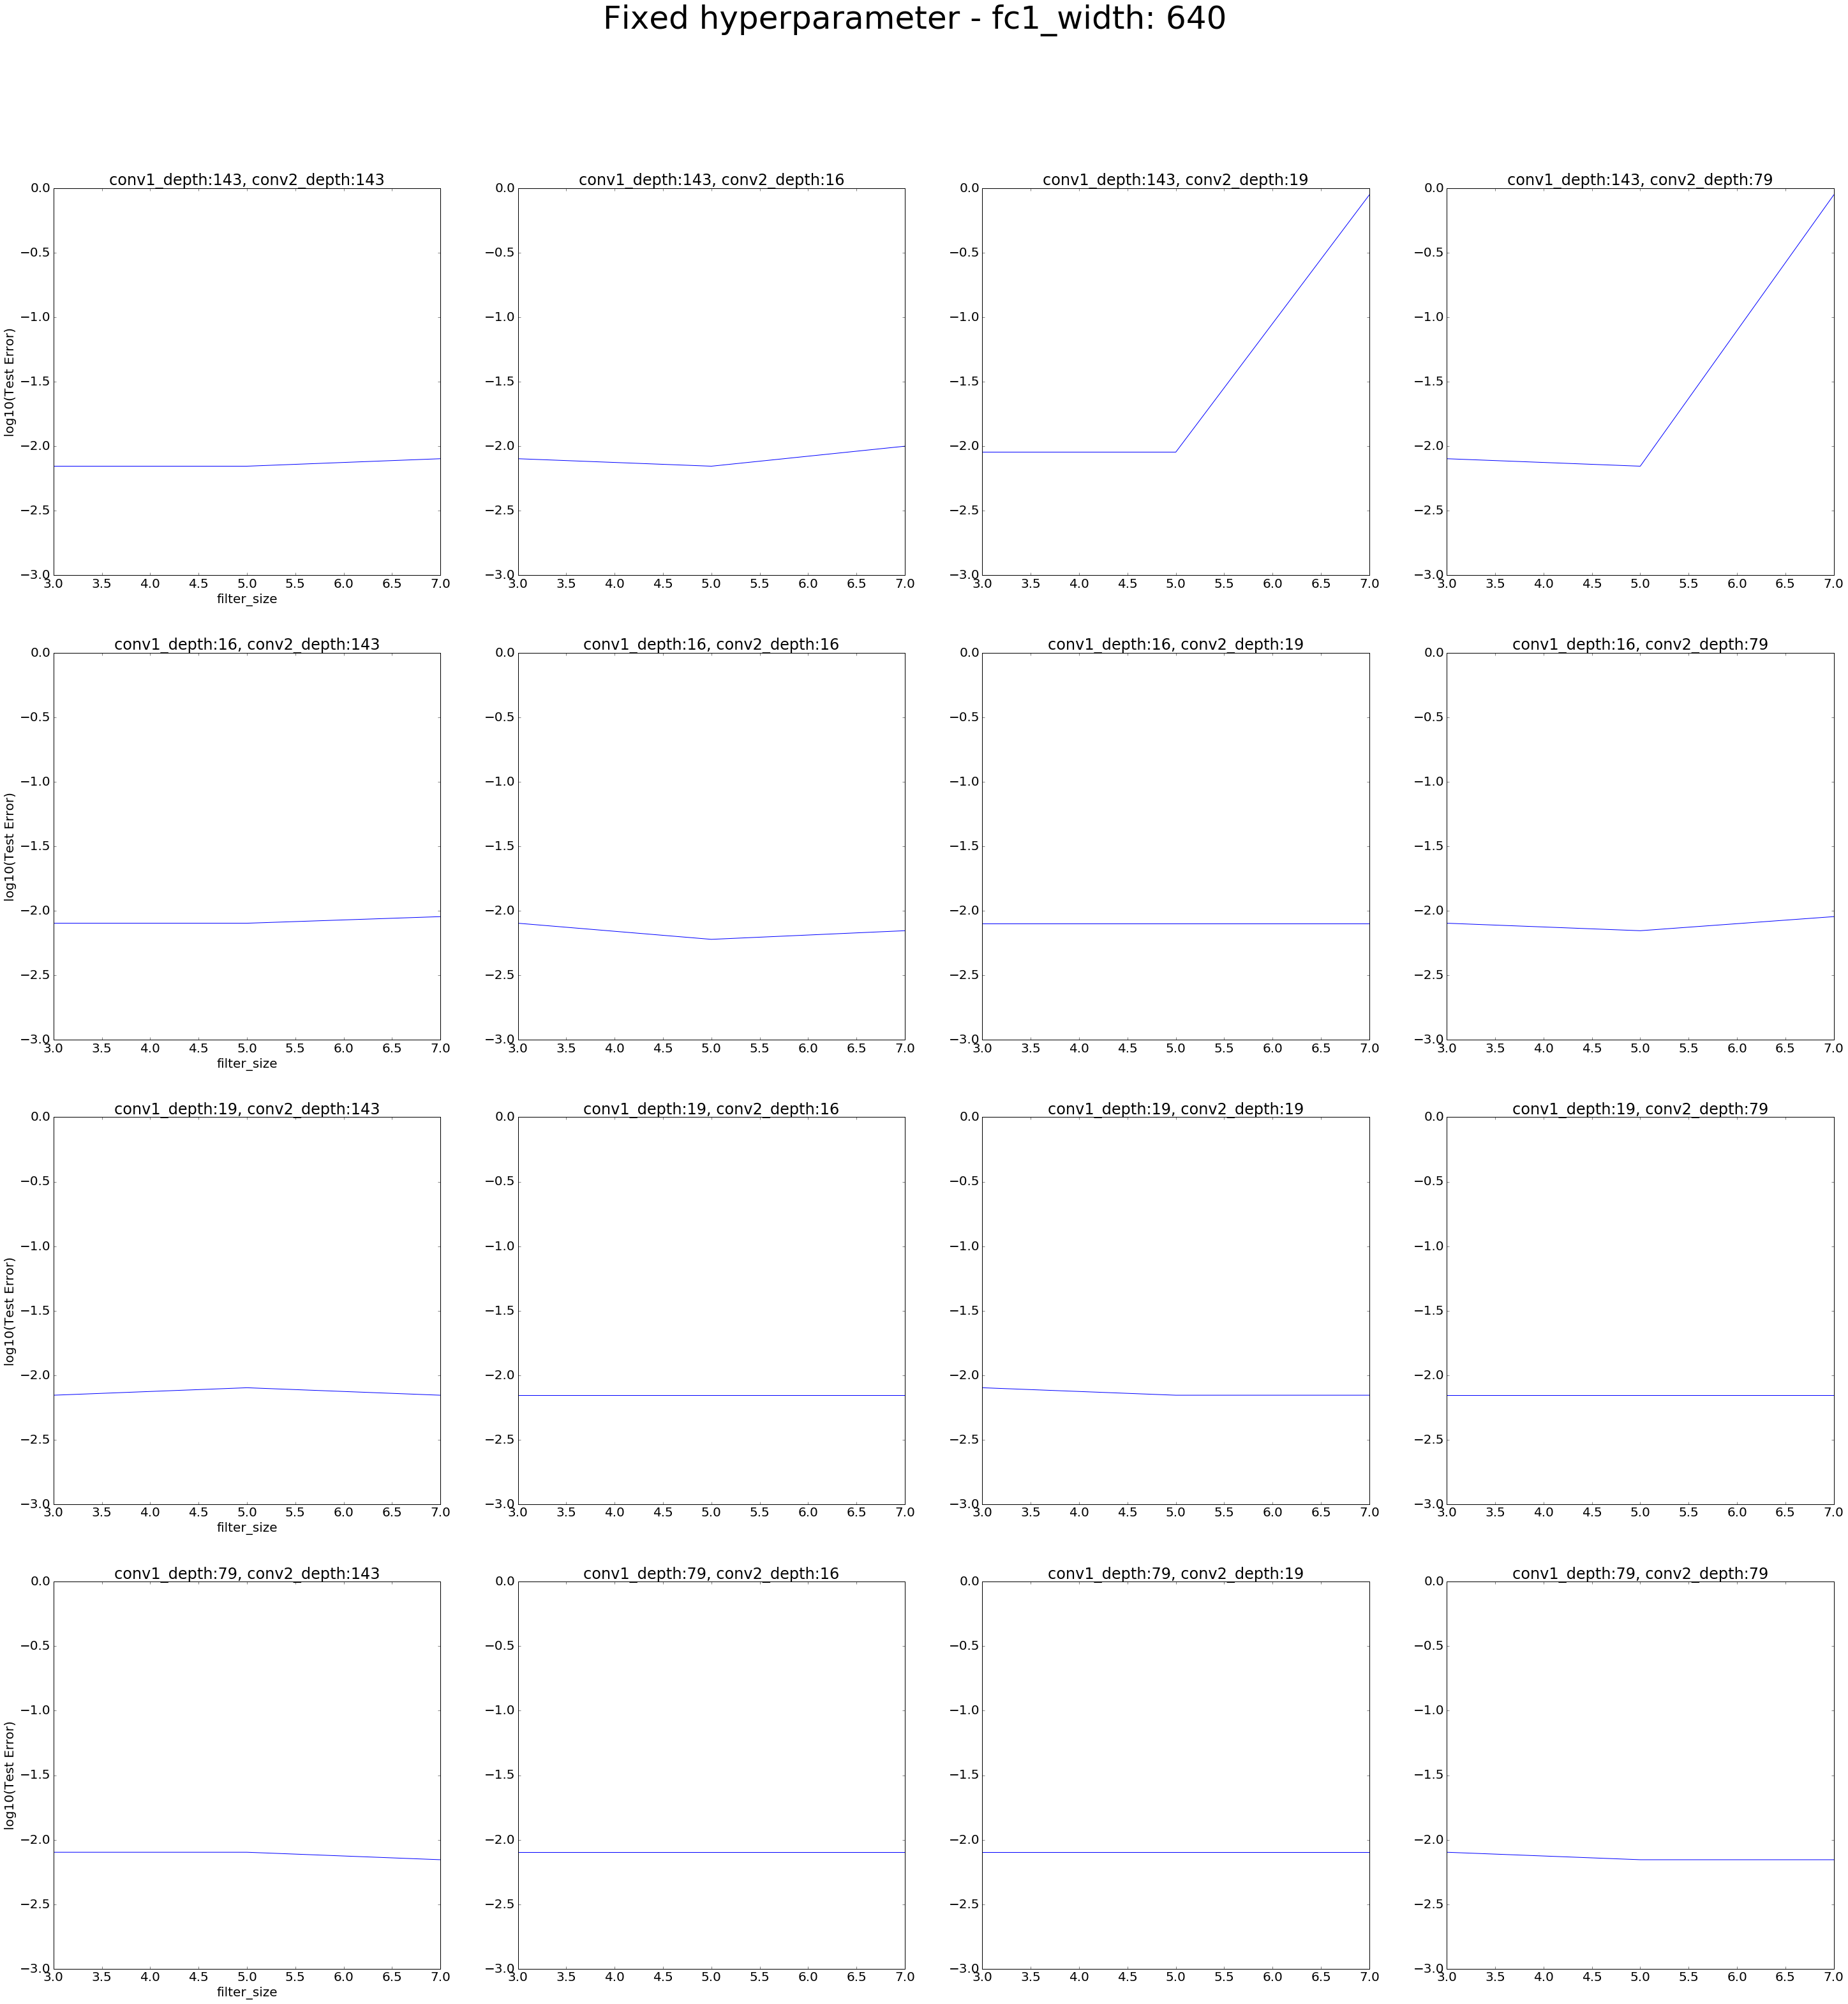

In [31]:
x_axis = {"name" : "conv1_depth", "values" : conv1_depths}
y_axis = {"name" : "conv2_depth", "values" : conv2_depths}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "filter_size"

for fc in fc_depths:
    for output in outputs:
        fixed = {"name": "fc1_width", "value": fc}
        draw_n_by_n_plots(total_only_table, fixed, x_axis, y_axis, selected_dim, output, False, True, False)

In [ ]:
x_axis = {"name" : "filter_size", "values" : filter_sizes}
y_axis = {"name" : "fc1_width", "values" : fc_depths}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "conv1_depth"

for conv2 in conv2_depths:
    for output in outputs:
        fixed = {"name": "conv2_depth", "value": conv2}
        draw_n_by_n_plots(total_only_table, fixed, x_axis, y_axis, selected_dim, output, False, True, True)

In [ ]:
x_axis = {"name" : "filter_size", "values" : filter_sizes}
y_axis = {"name" : "fc1_width", "values" : fc_depths}
outputs = ["Elapsed Time", "Test Error"]
selected_dim = "conv2_depth"

for conv1 in conv1_depths:
    for output in outputs:
        fixed = {"name": "conv1_depth", "value": conv1}
        draw_n_by_n_plots(total_only_table, fixed, x_axis, y_axis, selected_dim, output, False, True, True)